In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
from scipy.stats import circmean
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.special import i0
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr,linregress
from scipy.stats import spearmanr
from scipy.signal import correlate
from scipy.stats import levene
from scipy.stats import circvar
from sklearn.linear_model import HuberRegressor
from matplotlib.cm import plasma
from matplotlib.colors import Normalize,LinearSegmentedColormap

In [2]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay,find_qualified_stopping_period, PVA_strength_during_stopPeriod,permutation_test_median
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import calculate_angle_difference_between_two_time_point,run_ANOVA_for_comparing_across_genotypes,plot_stopping_period_signal,calculate_stop_signal_in_separate_fly,run_fixed_heading_period_analysis_across_trial, plot_fly_data_histograms_fly_wise,plot_fly_data_density_fly_wise,plot_stop_drift_rate_heatmaps
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding,moving_wrapped_plot_by_offset
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude ,calcualteBumpAmplitude_V2_green, calcualteBumpAmplitude_V3, calculateBumpWidth_v1,von_Mises_fitting_dff_TQ, PVA_radian_to_angle,calcualteBumpAmplitude_V4,PVAangleToRoi,strong_PVA_duration,plot_bump_shape_comparison,plot_strong_signal_frame_pva_histogram,plot_circular_variance_distribution_at_turning_slide_window,align_radian_offset_to_zero,plot_aligned_radian_offset_distribution

In [18]:
# run_vonMises_fitting = 0
stable_PVA_threshold = 67.5
genotype = 'R27F02>7b'
celltype = 'EPG-syt7f'
trial_condition = 'dark'
dual_imaging = 0
bump_amplitude_stopping_duration = 20
#200ms bin size
bump_amplitude_stopping_bin_size = 0.2
active_period_before_len =1
ROI_type =2

In [73]:
data_all = run_fixed_heading_period_analysis_across_trial('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dark_cl_Ca_imaging/EPG/EPG_PB(syt)/dark',0,genotype,trial_condition,bump_amplitude_stopping_duration,ROI_type)

/home/tianhaoqiu/Documents/GitHub/2p_analysis/fly2p_function_TQ/imaging_2p_fixed_heading_period_analysis.py:489: RuntimeWarning: Mean of empty slice
  average_per_second_non_abs = np.nanmean(data_non_abs, axis=1)
/home/tianhaoqiu/Documents/GitHub/2p_analysis/fly2p_function_TQ/imaging_2p_fixed_heading_period_analysis.py:490: RuntimeWarning: Mean of empty slice
  average_per_second_abs = np.nanmean(data_abs, axis=1)


In [18]:
data_all.keys()

dict_keys(['output_df_pooled', 'output_bump_amplitude_V3_pooled', 'output_bump_amplitude_V4_pooled', 'output_bump_width_pooled', 'output_PVA_strength_pooled', 'output_Angular_Speed_pooled', 'strong_PVA_chunk_pooled', 'strong_PVA_chunk_behavior_state', 'PVA_at_strong_signal', 'mean_PVA_strength_per_trial_pooled', 'output_stable_PVA_index_pooled', 'circular_variance', 'circular_variance_slide_window_during_walking', 'Average_bump_shape', 'Average_bump_shape_strong_PVA', 'Bump_shape_at_stop', 'Bump_shape_at_stop_more_than_10s_trial_only', 'Bump_shape_at_5s_after_stop', 'Bump_shape_at_10s_after_stop', 'Bump_shape_at_20s_after_stop', 'max_Raw_F_at_stop', 'max_Raw_F_at_10s_after_stop', 'output_flytrial', 'output_flytrial_for_qualified_stop', 'output_second_wise_bump_drift', 'output_second_wise_bump_drift_at_stop_thresholded', 'output_second_wise_bump_drift_at_stop_thresholded_absolute', 'output_second_wise_bump_drift_right_before_stop', 'output_second_wise_bump_drift_right_before_stop_thresh

In [17]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_fly_stops_from_data_all(
    data_all,
    fly_id='TQfly025',
    save_as_pdf=None  # pass None or 'filename.pdf'
):
    fly_data = data_all['dff_8_roi_at_stop'][fly_id]
    pva_strength_data = data_all['PVA_strength_frame_wise_at_stop'][fly_id]
    pva_angle_data = data_all['PVA_Angle_frame_wise_at_stop'][fly_id]

    order = [4, 5, 6, 7, 0, 1, 2, 3]
    pdf_writer = PdfPages(save_as_pdf) if save_as_pdf else None

    for trial_idx, (trial_stops, pva_stops, angle_stops) in enumerate(zip(fly_data, pva_strength_data, pva_angle_data)):
        for stop_idx, (stop_trace, stop_pva_strength, stop_pva_angle) in enumerate(zip(trial_stops, pva_stops, angle_stops)):
            trace_data = stop_trace
            trace_data_shifted = trace_data[order, :]
            pva_strength = stop_pva_strength
            pva_angle = stop_pva_angle

            fig, axs = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

            # ROI heatmap
            im1 = axs[0].imshow(trace_data_shifted, aspect='auto', cmap='Blues')
            axs[0].set_title(f'Imaging Trial {trial_idx + 1}, Stop {stop_idx + 1} - {fly_id}')
            axs[0].set_ylabel('ROI')
            axs[0].set_yticks(np.arange(8))
            axs[0].set_yticklabels(np.array(order) + 1)
            axs[0].set_ylim(0, 7)

            # PVA angle overlay
            scatter_y = 7 * (pva_angle + 180) / 2 / 180
            axs[0].scatter(np.arange(len(pva_angle)), scatter_y, color='black', s=40, label='PVA Angle')
            axs[0].legend(loc='upper right')
            fig.colorbar(im1, ax=axs[0], orientation='vertical', label='dF/F')

            # PVA strength heatmap
            im2 = axs[1].imshow(pva_strength[np.newaxis, :], aspect='auto', cmap='viridis')
            axs[1].set_yticks([])
            axs[1].set_xlabel('Frames')
            axs[1].set_ylabel('PVA Strength')
            fig.colorbar(im2, ax=axs[1], orientation='vertical')

            plt.tight_layout()

            if pdf_writer:
                pdf_writer.savefig(fig)
                plt.close(fig)
            else:
                plt.show()

    if pdf_writer:
        pdf_writer.close()
        print(f"Saved plots to {save_as_pdf}")

In [26]:
plot_fly_stops_from_data_all(data_all, fly_id='TQfly052', save_as_pdf='TQfly052_all_stops.pdf')

Saved plots to TQfly052_all_stops.pdf


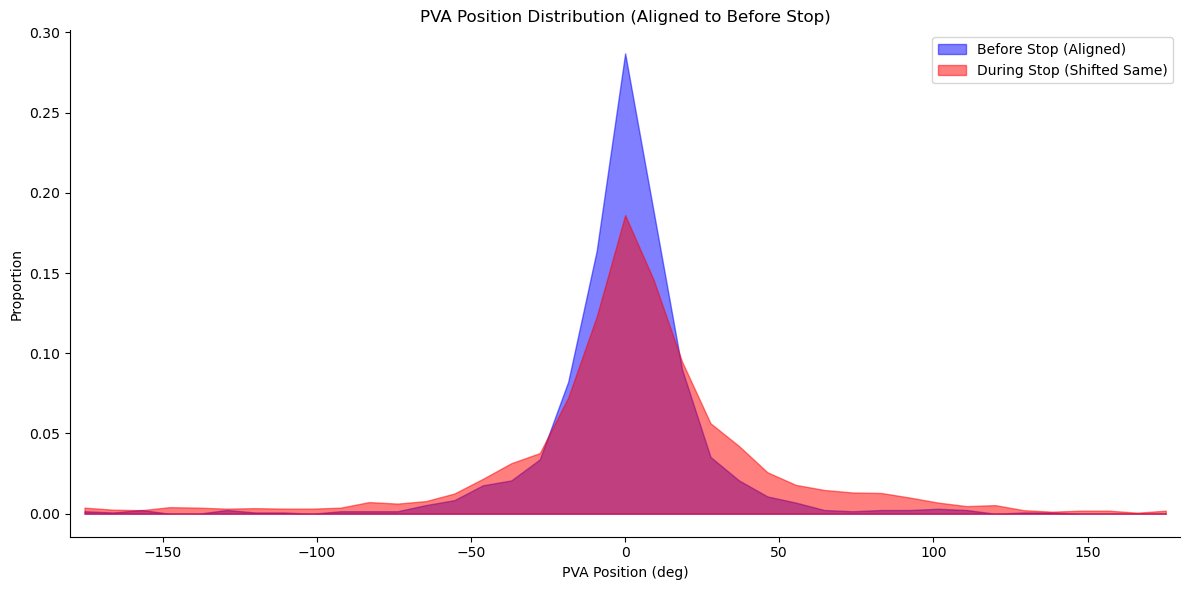

In [19]:
# Extract the relevant data
data_before = data_all['output_second_wise_PVA_position_right_before_stop']
data_during = data_all['output_second_wise_PVA_position_during_stop']

# Set up plotting
fig, ax = plt.subplots(figsize=(12, 6))
bins = np.linspace(-180, 180, 40)
color_before = 'blue'
color_during = 'red'

all_before_shifted = []
all_during_shifted = []

# Loop through animals
for animal in data_before:
    if animal not in data_during:
        continue

    trials_before = data_before[animal]
    trials_during = data_during[animal]

    for trial_before, trial_during in zip(trials_before, trials_during):
        for arr_before, arr_during in zip(trial_before, trial_during):
            if arr_before is None or arr_during is None:
                continue
            if np.isnan(arr_before).any() or np.isnan(arr_during).any():
                continue

            mean_before = circmean(arr_before, high=180, low=-180)
            shift_angle = -mean_before

            # Shift both arrays
            shifted_before = (arr_before + shift_angle + 180) % 360 - 180
            shifted_during = (arr_during + shift_angle + 180) % 360 - 180

            all_before_shifted.extend(shifted_before)
            all_during_shifted.extend(shifted_during)

# Compute histograms
hist_before, bin_edges = np.histogram(all_before_shifted, bins=bins, density=True)
hist_during, _ = np.histogram(all_during_shifted, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Normalize histograms to proportion
hist_before = hist_before / np.sum(hist_before)
hist_during = hist_during / np.sum(hist_during)

# Plot
ax.fill_between(bin_centers, hist_before, alpha=0.5, color=color_before, label="Before Stop (Aligned)")
ax.fill_between(bin_centers, hist_during, alpha=0.5, color=color_during, label="During Stop (Shifted Same)")

# Formatting
ax.set_xlim(-180, 180)
ax.set_xlabel("PVA Position (deg)")
ax.set_ylabel("Proportion")
ax.set_title("PVA Position Distribution (Aligned to Before Stop)")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PVA Angle Change During Stops (Binary Colored by Avg Δ in First 5s)')

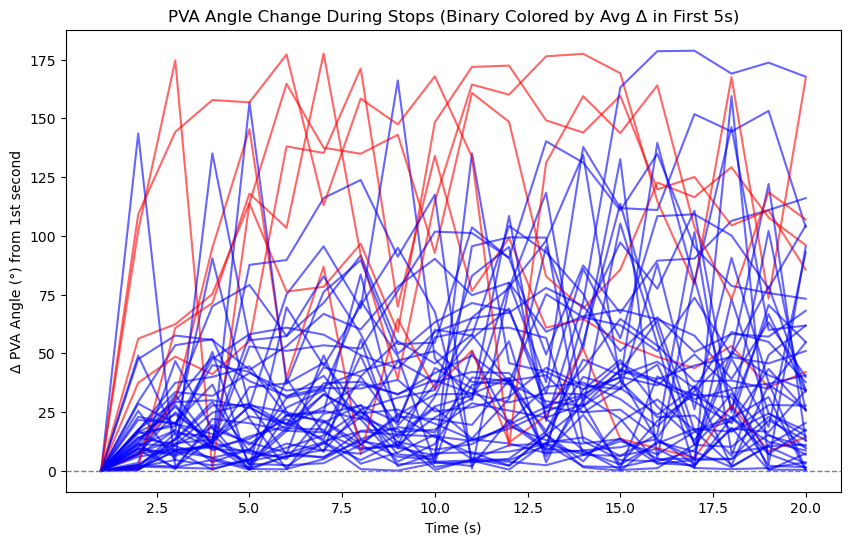

In [20]:
def circular_difference(angle1, angle2):
    """Compute the circular difference between two angles in degrees."""
    diff = angle2 - angle1
    return (diff + 180) % 360 - 180

fig, ax = plt.subplots(figsize=(10, 6))

for fly, all_trials in data_all['output_second_wise_PVA_position_during_stop'].items():
    for trial in all_trials:
        for trial_data in trial:
            if len(trial_data) >= 20:
                # Compute angle difference from the first second
                base_angle = trial_data[0]
                angle_diffs = np.array([circular_difference(base_angle, a) for a in trial_data[:20]])
                
                # Compute average absolute change in first 5s
                avg_change_5s = np.mean(np.abs([circular_difference(base_angle, a) for a in trial_data[1:6]]))

                # Binary color based on threshold
                color = 'red' if avg_change_5s > 60 else 'blue'
                
                ax.plot(np.arange(1, 21), np.abs(angle_diffs), color=color, alpha=0.6)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Δ PVA Angle (°) from 1st second')
ax.set_title('PVA Angle Change During Stops (Binary Colored by Avg Δ in First 5s)')

In [21]:
def plot_pva_angle_change(
    pva_data,
    strength_data,
    strength_window='first',  # 'first', 'last', or 'all'
    strength_filter=True,
    duration=20  # Number of seconds to plot
):
    aligned_changes = []
    mean_strengths = []

    # Collect all strength values for thresholding
    all_strengths = []

    for fly_id in pva_data:
        strength_trials = strength_data[fly_id]
        for strength_trial in strength_trials:
            for chunk in strength_trial:
                if len(chunk) >= duration:
                    if strength_window == 'first':
                        target_chunk = chunk[:5]
                    elif strength_window == 'last':
                        target_chunk = chunk[-5:]
                    else:  # 'all'
                        target_chunk = chunk[:duration]
                    all_strengths.append(np.mean(target_chunk))

    strength_threshold = np.mean(all_strengths) - np.std(all_strengths)

    # Loop through data
    for fly_id in pva_data:
        pva_trials = pva_data[fly_id]
        strength_trials = strength_data[fly_id]

        for pva_trial, strength_trial in zip(pva_trials, strength_trials):
            for stop_chunk, strength_chunk in zip(pva_trial, strength_trial):
                if len(stop_chunk) >= duration and len(strength_chunk) >= duration:
                    stop_chunk = stop_chunk[:duration]
                    strength_chunk = strength_chunk[:duration]

                    # Determine strength for color and filter
                    if strength_window == 'first':
                        window_strength = strength_chunk[:5]
                    elif strength_window == 'last':
                        window_strength = strength_chunk[-5:]
                    else:  # 'all'
                        window_strength = strength_chunk

                    mean_strength = np.mean(window_strength)

                    if strength_filter and mean_strength < strength_threshold:
                        continue

                    # Compute circular difference
                    stop_chunk_rad = np.deg2rad(stop_chunk)
                    ref_angle = stop_chunk_rad[0]
                    delta_angle = np.angle(np.exp(1j * (stop_chunk_rad - ref_angle)))
                    delta_angle_deg = np.abs(np.rad2deg(delta_angle))

                    aligned_changes.append(delta_angle_deg)
                    mean_strengths.append(mean_strength)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if not aligned_changes:
        ax.text(0.5, 0.5, 'No trials passed the filter', ha='center', va='center')
        plt.show()
        return

    norm = Normalize(vmin=min(mean_strengths), vmax=max(mean_strengths))
    colors = plasma(norm(mean_strengths))

    for change, color in zip(aligned_changes, colors):
        ax.plot(np.arange(1, duration + 1), change, color=color, alpha=0.7)

    ax.axhline(0, linestyle='--', color='gray')
    ax.set_xlabel('Time from stop start (s)')
    ax.set_ylabel('|Δ PVA angle| (deg)')
    ax.set_title(
        f'Absolute Change in PVA angle (first {duration}s)\nColored by avg PVA strength ({strength_window} window)'
        + (f' (filtered > 1SD)' if strength_filter else '')
    )

    sm = plt.cm.ScalarMappable(cmap=plasma, norm=norm)
    fig.colorbar(sm, ax=ax, label=f'Mean PVA strength ({strength_window} window)')

    ax.grid(True)
    plt.tight_layout()
    plt.show()


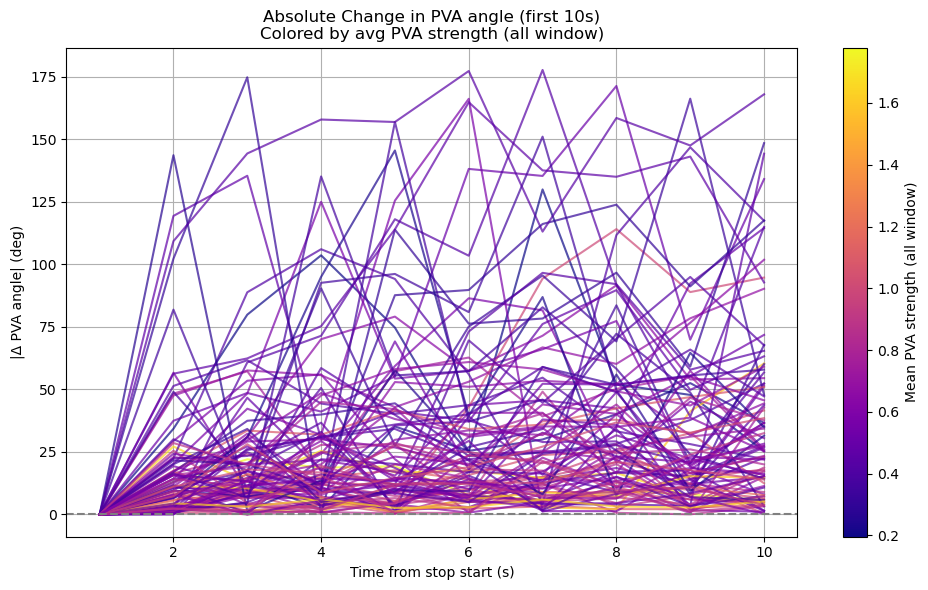

In [22]:
plot_pva_angle_change(
    pva_data = data_all['output_second_wise_PVA_position_during_stop'],
    strength_data = data_all['output_second_wise_PVA_strength'],
    strength_window='all',  # change to 'last' for last 5s coloring
    strength_filter=False,      # set to False to skip threshold filtering
    duration=10
)

In [20]:
def plot_pva_angle_vs_time(
    pva_data,
    strength_data,
    duration=20,  # max seconds to include
    PVA_change='first',  # 'first' or 'adjacent'
    save_as='no'  # filename string to save as SVG, or 'no' to skip
):
    delta_angles = []
    strengths = []
    time_bins = []

    for fly_id in pva_data:
        pva_trials = pva_data[fly_id]
        strength_trials = strength_data[fly_id]

        for pva_trial, strength_trial in zip(pva_trials, strength_trials):
            for stop_chunk, strength_chunk in zip(pva_trial, strength_trial):
                if len(stop_chunk) >= duration and len(strength_chunk) >= duration:
                    stop_chunk = stop_chunk[:duration]
                    strength_chunk = strength_chunk[:duration]

                    stop_chunk_rad = np.deg2rad(stop_chunk)

                    if PVA_change == 'first':
                        ref_angle = stop_chunk_rad[0]
                        delta_angle = np.angle(np.exp(1j * (stop_chunk_rad - ref_angle)))
                    elif PVA_change == 'adjacent':
                        ref_angle = stop_chunk_rad[:-1]
                        next_angle = stop_chunk_rad[1:]
                        delta_angle = np.angle(np.exp(1j * (next_angle - ref_angle)))
                        strength_chunk = strength_chunk[1:]
                        stop_chunk_rad = stop_chunk_rad[1:]
                    else:
                        raise ValueError("PVA_change must be either 'first' or 'adjacent'")

                    delta_angle_deg = np.rad2deg(delta_angle)

                    for t in range(len(delta_angle_deg)):
                        delta_angles.append(delta_angle_deg[t])
                        strengths.append(strength_chunk[t])
                        time_bins.append(t + 1 if PVA_change == 'first' else t + 2)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    if not delta_angles:
        ax.text(0.5, 0.5, 'No valid data to plot', ha='center', va='center')
        plt.show()
        return

    # Seaborn colormap
    sns_palette = sns.color_palette("ch:s=.10,rot=-.60", as_cmap=True)
    norm = Normalize(vmin=min(strengths), vmax=max(strengths))

    scatter = ax.scatter(
        delta_angles,
        time_bins,
        c=strengths,
        cmap=sns_palette,
        norm=norm,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.3
    )

    ax.set_xlabel('Δ PVA angle (deg)')
    ax.set_ylabel('Time from stop start (s)')
    ax.set_title(f'Δ PVA Angle by Time (Change = {PVA_change}, Colored by PVA Strength)')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('PVA Strength (per 1s bin)')

    plt.tight_layout()

    if isinstance(save_as, str) and save_as.lower() != 'no':
        if not save_as.endswith('.svg'):
            save_as += '.svg'
        plt.savefig(save_as, format='svg')
        print(f"Figure saved as: {save_as}")

    plt.show()

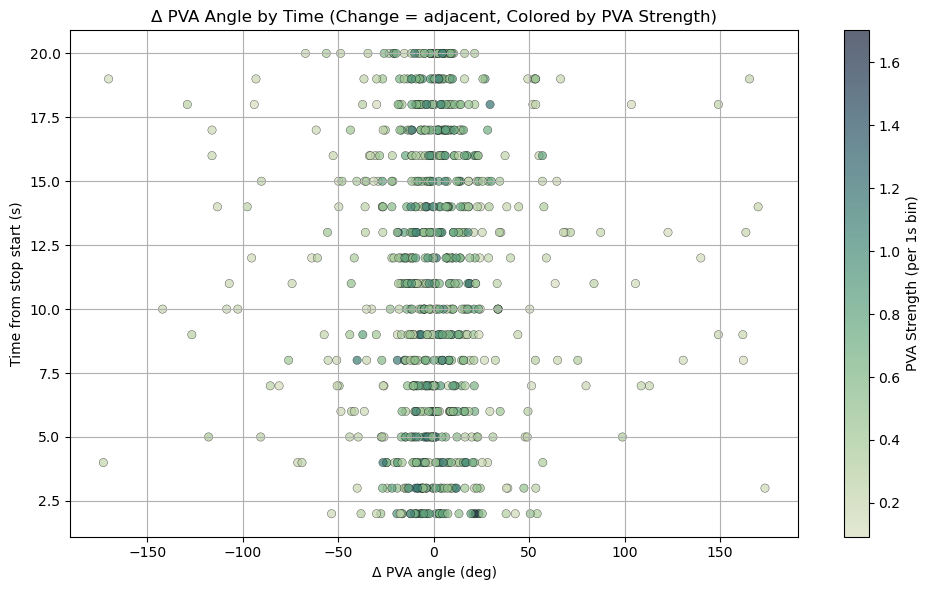

In [25]:
plot_pva_angle_vs_time(
    pva_data = data_all['output_second_wise_PVA_position_during_stop_thresholded'],
    strength_data = data_all['output_second_wise_PVA_strength'],
    duration=20,PVA_change='adjacent',
save_as='no')

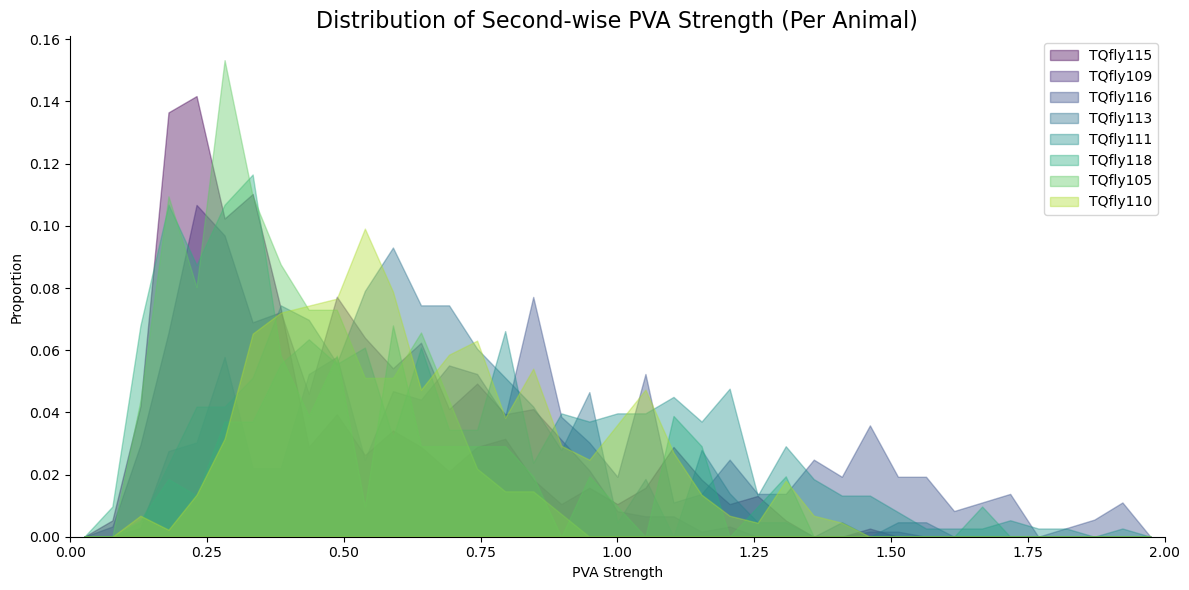

In [12]:
data_all_sample = data_all['output_second_wise_PVA_strength']

# Define colors dynamically
num_animals = len(data_all_sample)
color_list = [plt.cm.viridis(i / num_animals) for i in range(num_animals)]  # Generates distinct colors

# Define bins
bins = np.linspace(0, 2, 40)  # Assuming PVA strength ranges from 0 to ~2

# Plot histograms
fig, ax = plt.subplots(figsize=(12, 6))

for (animal, data), color in zip(data_all_sample.items(), color_list):
    # Flatten all arrays across all trials and nested arrays
    flat_data = np.concatenate([np.asarray(d, dtype=float).flatten() for trial in data for d in trial])
    
    # Compute histogram
    hist, bin_edges = np.histogram(flat_data, bins=bins, density=True)
    hist = hist / hist.sum()
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot
    ax.fill_between(bin_centers, hist, alpha=0.4, color=color, label=f"{animal}")

# Formatting
ax.set_xlim(bins[0], bins[-1])
ax.set_ylim(0, None)
ax.set_xlabel("PVA Strength")
ax.set_ylabel("Proportion")
ax.set_title("Distribution of Second-wise PVA Strength (Per Animal)", fontsize=16)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
# Extract the strength data
strengths_by_fly = data_all['output_second_wise_PVA_strength']

# Calculate 1 SD below average for each fly
one_sd_below_avg = {}
for fly, data_list in strengths_by_fly.items():
    # Flatten all arrays across all trials
    flat_data = np.concatenate([np.asarray(arr).flatten() for trial in data_list for arr in trial])
    mean_val = np.mean(flat_data)
    std_val = np.std(flat_data)
    one_sd_below_avg[fly] = mean_val - std_val

one_sd_below_avg

{'TQfly047': 0.42722904557796276,
 'TQfly028': 0.41159086974056036,
 'TQfly050': 1.1312283619609396,
 'TQfly029': 0.6155416686390942,
 'TQfly052': 0.621862374285138,
 'TQfly048': 0.8191046199384978,
 'TQfly049': 0.6944611812607016,
 'TQfly025': 0.6039350511857919}

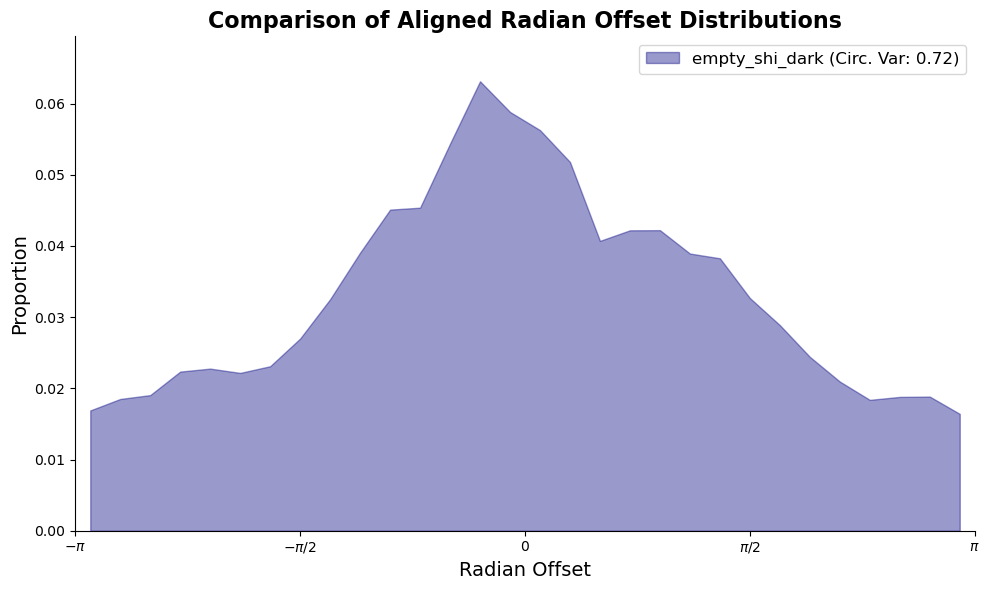

In [13]:
all_aligned_data_combined =align_radian_offset_to_zero(data_all, key_name='output_PVA_heading_offset')
plot_aligned_radian_offset_distribution(all_aligned_data_combined,
                                        label_1="empty_shi_dark",  
                                        color_1="Navy", bins=30)

In [17]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(all_aligned_data_combined, all_aligned_data_combined_2, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={stat}, p-value={p_value}")

NameError: name 'all_aligned_data_combined_2' is not defined

In [27]:
from scipy.stats import ks_2samp

# Assuming `data1` and `data2` contain the raw values for the two datasets
statistic, p_value = ks_2samp(all_aligned_data_combined, all_aligned_data_combined_2)

print(f"Kolmogorov-Smirnov Test: KS-statistic={statistic}, p-value={p_value}")

Kolmogorov-Smirnov Test: KS-statistic=0.06887118390047, p-value=5.4399159400542004e-180


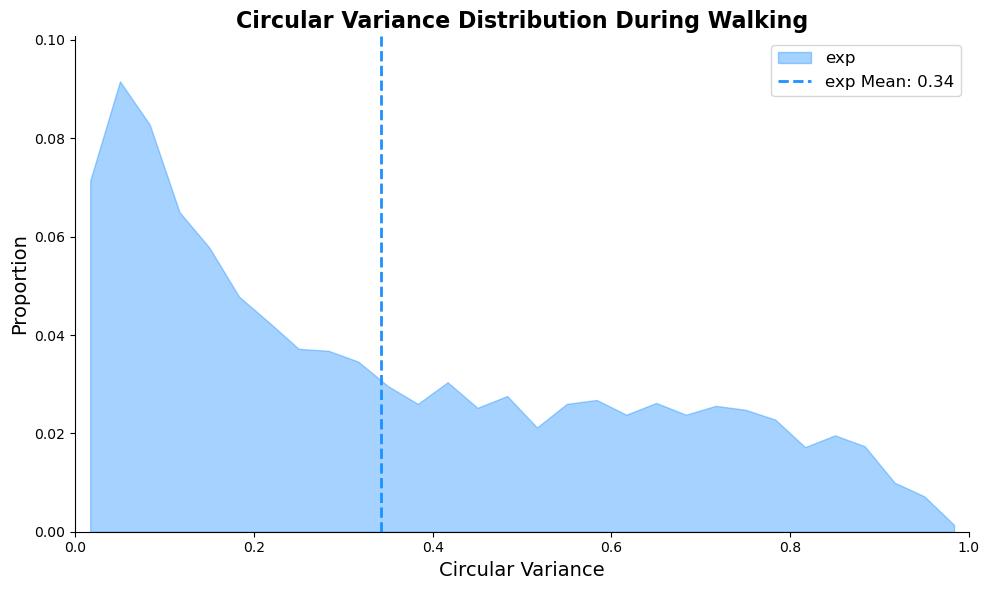

In [7]:
plot_circular_variance_distribution_at_turning_slide_window([data_all['circular_variance_slide_window_during_walking']],['exp'])

In [14]:
#df =data_all['Average_bump_shape']
#df.to_csv('/home/tianhaoqiu/Pictures/Screenshots/Average-bumpshape-d7-6f-shi-dark-31',encoding = 'utf-8', index=False) 

In [15]:
#df = pd.DataFrame(b, columns=['Column_Name'])
#df.to_csv('/home/tianhaoqiu/a.csv',encoding = 'utf-8', index=False) 

In [16]:
#output_bump_amplitude_V4_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V4_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V3_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V3_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)

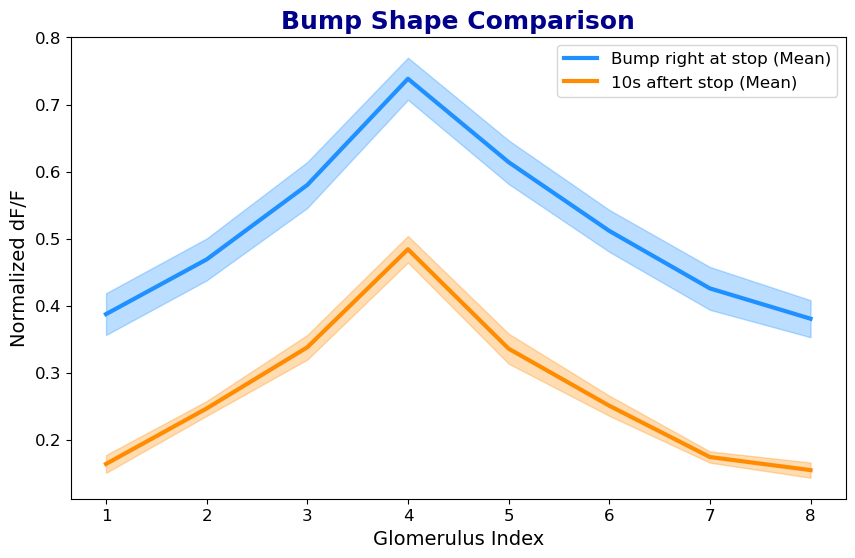

In [9]:
plot_bump_shape_comparison(data_all['Bump_shape_at_stop_more_than_10s_trial_only'], data_all['Bump_shape_at_10s_after_stop'],label2 = '10s aftert stop'
)

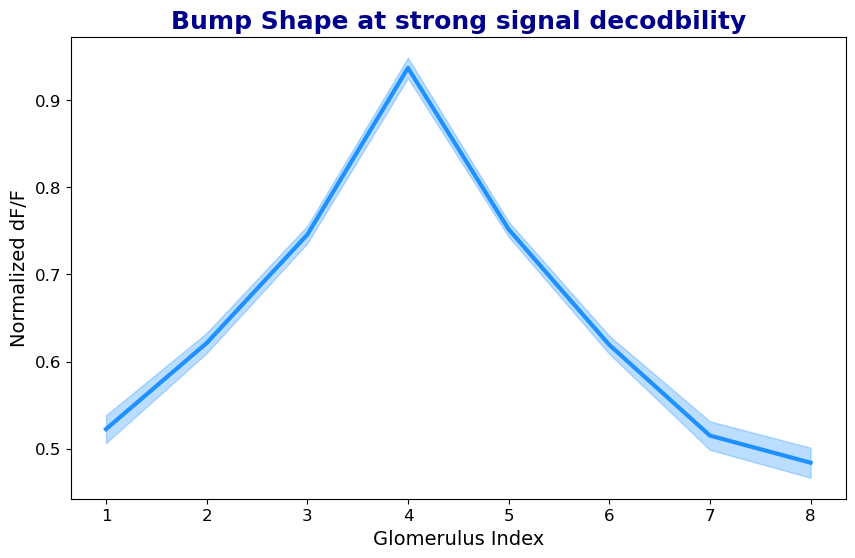

In [52]:
# Assuming both datasets are 2D array-like structures (trials x timepoints)
data_stop_more_than_10s = data_all['Average_bump_shape_strong_signal']

# Calculate the mean and SEM for each dataset (along axis=1)
mean_stop_more_than_10s = np.nanmean(data_stop_more_than_10s, axis=1)
sem_stop_more_than_10s = np.nanstd(data_stop_more_than_10s, axis=1) / np.sqrt(data_stop_more_than_10s.shape[1])


# Create the figure
plt.figure(figsize=(10, 6))

# Plot the first dataset (stop > 10s)
plt.plot(range(1, len(mean_stop_more_than_10s) + 1), mean_stop_more_than_10s, color='dodgerblue', linewidth=3, label='Stop > 10s (Mean)')
plt.fill_between(range(1, len(mean_stop_more_than_10s) + 1), mean_stop_more_than_10s - sem_stop_more_than_10s, 
                 mean_stop_more_than_10s + sem_stop_more_than_10s, color='dodgerblue', alpha=0.3)  # Removed label for SEM

# Add title, labels, and enhance ticks
plt.title("Bump Shape at strong signal decodbility", fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel("Glomerulus Index", fontsize=14)
plt.ylabel("Normalized dF/F", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend for only the mean
#plt.legend(fontsize=12)

# Show the plot
plt.show()

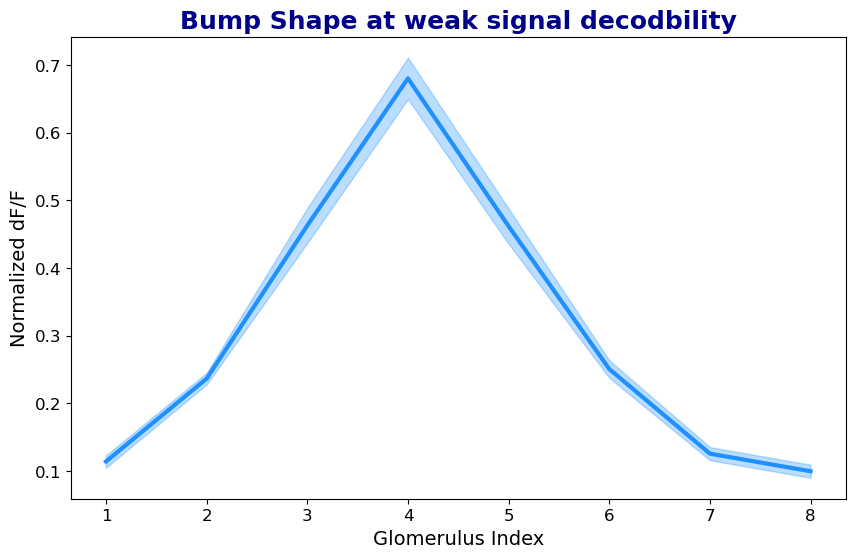

In [53]:
# Assuming both datasets are 2D array-like structures (trials x timepoints)
data_stop_more_than_10s = data_all['Average_bump_shape_weak_signal']

# Calculate the mean and SEM for each dataset (along axis=1)
mean_stop_more_than_10s = np.nanmean(data_stop_more_than_10s, axis=1)
sem_stop_more_than_10s = np.nanstd(data_stop_more_than_10s, axis=1) / np.sqrt(data_stop_more_than_10s.shape[1])


# Create the figure
plt.figure(figsize=(10, 6))

# Plot the first dataset (stop > 10s)
plt.plot(range(1, len(mean_stop_more_than_10s) + 1), mean_stop_more_than_10s, color='dodgerblue', linewidth=3, label='Stop > 10s (Mean)')
plt.fill_between(range(1, len(mean_stop_more_than_10s) + 1), mean_stop_more_than_10s - sem_stop_more_than_10s, 
                 mean_stop_more_than_10s + sem_stop_more_than_10s, color='dodgerblue', alpha=0.3)  # Removed label for SEM

# Add title, labels, and enhance ticks
plt.title("Bump Shape at weak signal decodbility", fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel("Glomerulus Index", fontsize=14)
plt.ylabel("Normalized dF/F", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend for only the mean
#plt.legend(fontsize=12)

# Show the plot
plt.show()

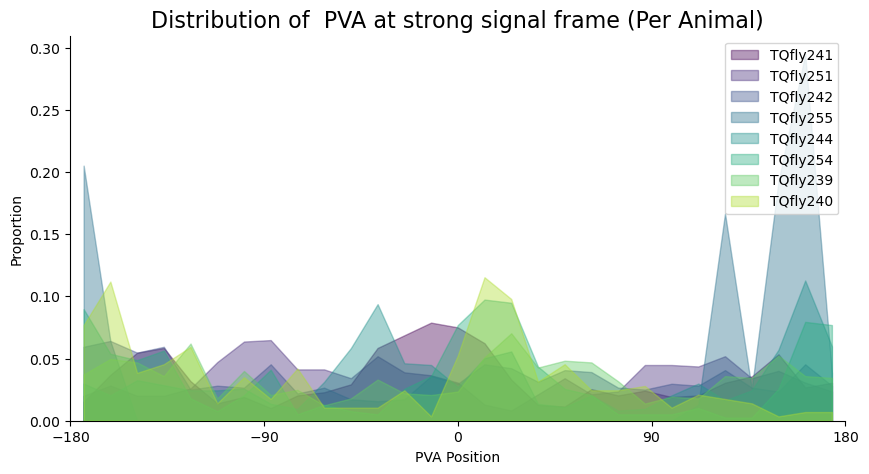

In [10]:
plot_strong_signal_frame_pva_histogram(data_all)


In [11]:
data_all_1 = data_all

In [12]:
data_all_2= data_all

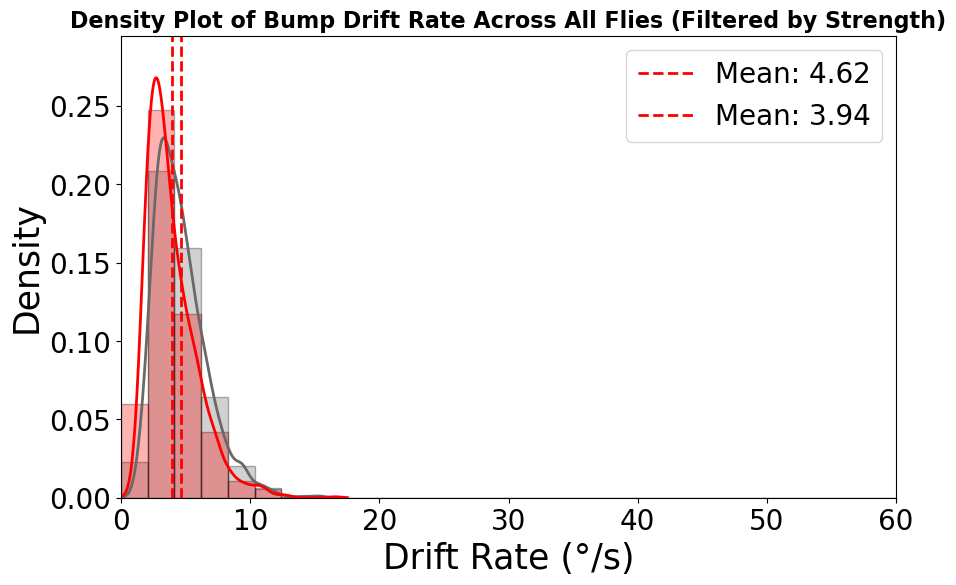

In [30]:
filtered_data_1 =plot_fly_data_density_fly_wise(data_all_1,data_all_1, plot_individual=False, different_color_for_fly=False, label=None, color='dimgray',show_bins=True,fill_under_curve=False, reset_y_lim=False)
filtered_data_2 =plot_fly_data_density_fly_wise(data_all_2,data_all_2, plot_individual=False, different_color_for_fly=False, label=None, color='red', show_bins=True,fill_under_curve=False, reset_y_lim=False)
# Save the plot as an SVG file
#plt.savefig("Drift_rate_EPG_7b_delta7_vglut_cl.svg", format="svg")

# Display the plot (optional, as it’s now saved)
plt.show()


In [15]:
# Combine all filtered data from each dataset
all_data_1 = np.concatenate(list(filtered_data_1.values()))
all_data_2 = np.concatenate(list(filtered_data_2.values()))

# Run the Mann-Whitney U test on the combined raw filtered values
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(all_data_1, all_data_2, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic={stat}, p-value={p_value}")

Mann-Whitney U Test: U-statistic=4663951.0, p-value=2.623208551980835e-43


In [16]:
from scipy.stats import ks_2samp

# Assuming `data1` and `data2` contain the raw values for the two datasets
statistic, p_value = ks_2samp(all_data_1, all_data_2)

print(f"Kolmogorov-Smirnov Test: KS-statistic={statistic}, p-value={p_value}")

Kolmogorov-Smirnov Test: KS-statistic=0.15720205508603077, p-value=2.4491039961125205e-30


In [17]:
# Example usage with your two datasets
observed_diff, p_value = permutation_test_median(all_data_1, all_data_2, num_permutations=10000, significance_level=0.01, effect_size_threshold=2)

print(f"Observed Difference: {observed_diff}, p-value: {p_value}")

Observed Difference in Medians (Adjusted by Effect Size Threshold): -0.3328144278616598
Permutation Test (Median): p-value = 1.0 (Significance level = 0.01)
Result: No significant difference
Observed Difference: -0.3328144278616598, p-value: 1.0


1164
1514


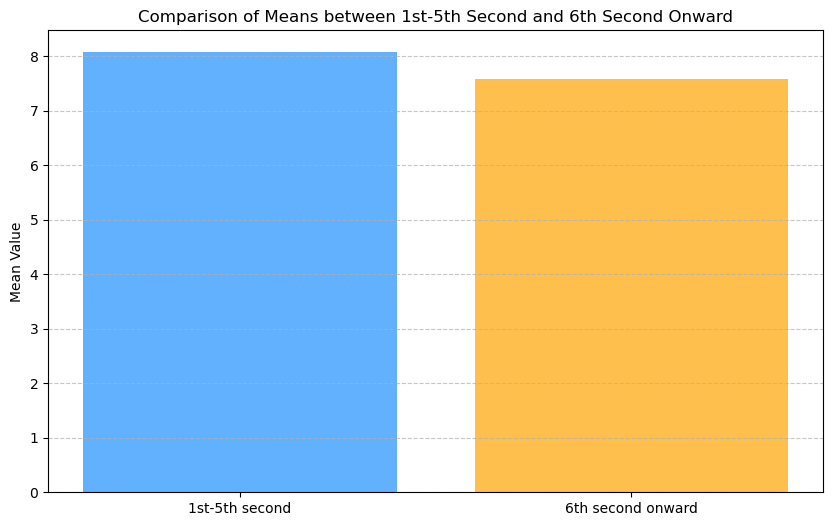

In [8]:
def filter_and_compare_data_with_plot(data_drift, data_strength):
    # Initialize lists to store filtered values for two categories
    category_1 = []
    category_2 = []
    
    # Calculate mean and standard deviation for the entire strength data to find threshold
    all_strength_data = []
    
    # Collect all strength values
    for fly, trials in data_strength.items():
        for trial in trials:
            for bin_data in trial:
                all_strength_data.extend(bin_data)

    # Calculate the overall mean and standard deviation
    mean_strength = np.mean(all_strength_data)
    std_strength = np.std(all_strength_data)
    
    # Threshold for qualifying data (1 SD below mean)
    strength_threshold = mean_strength - std_strength
    
    # Loop through each fly's data and strength data to filter and collect
    for (fly, trials_drift), (_, trials_strength) in zip(data_drift.items(), data_strength.items()):
        for trial_drift, trial_strength in zip(trials_drift, trials_strength):
            # Category 1: 1st to 5th time bin (if fewer, include all available)
            for i in range(min(5, len(trial_drift))):
                if isinstance(trial_drift[i], np.ndarray):
                    # Filter out based on the strength condition
                    valid_data = trial_drift[i][trial_strength[i] >= strength_threshold]
                    category_1.extend(valid_data)
            
            # Category 2: 6th time bin onward (if available)
            for i in range(5, len(trial_drift)):  # From the 6th bin onward
                if isinstance(trial_drift[i], np.ndarray):
                    # Filter out based on the strength condition
                    valid_data = trial_drift[i][trial_strength[i] >= strength_threshold]
                    category_2.extend(valid_data)

    # Create a DataFrame with the filtered data in two columns
    df = pd.DataFrame({
        'Category 1 (1st-5th second)': pd.Series(category_1),
        'Category 2 (6th second onward)': pd.Series(category_2)
    })

    # Calculate the means of both categories
    mean_category_1 = np.mean(category_1)
    print(len(category_1))
    mean_category_2 = np.mean(category_2)
    print(len(category_2))

    # Plot the data in bar plot and compare means
    plt.figure(figsize=(10, 6))
    
    # Bar plot of the means
    categories = ['1st-5th second', '6th second onward']
    means = [mean_category_1, mean_category_2]
    
    plt.bar(categories, means, color=['dodgerblue', 'orange'], alpha=0.7)
    
    # Adding labels and title
    plt.ylabel('Mean Value')
    plt.title('Comparison of Means between 1st-5th Second and 6th Second Onward')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display the plot
    plt.show()
    
    return df

# Example usage
filtered_data_df = filter_and_compare_data_with_plot(data_all['output_second_wise_absolute_bump_drift'], data_all['output_second_wise_PVA_strength'])


In [17]:
filtered_data_df

Category 1 (1st-5th second)  Category 2 (6th second onward)
0                       4.247195                        2.491366
1                       2.400108                        4.614622
2                       5.302008                       11.486999
3                       2.888512                       13.409870
4                       4.903031                       17.198592
..                           ...                             ...
827                          NaN                       11.461123
828                          NaN                       15.226289
829                          NaN                       53.256655
830                          NaN                       20.398895
831                          NaN                       24.563042

[832 rows x 2 columns]

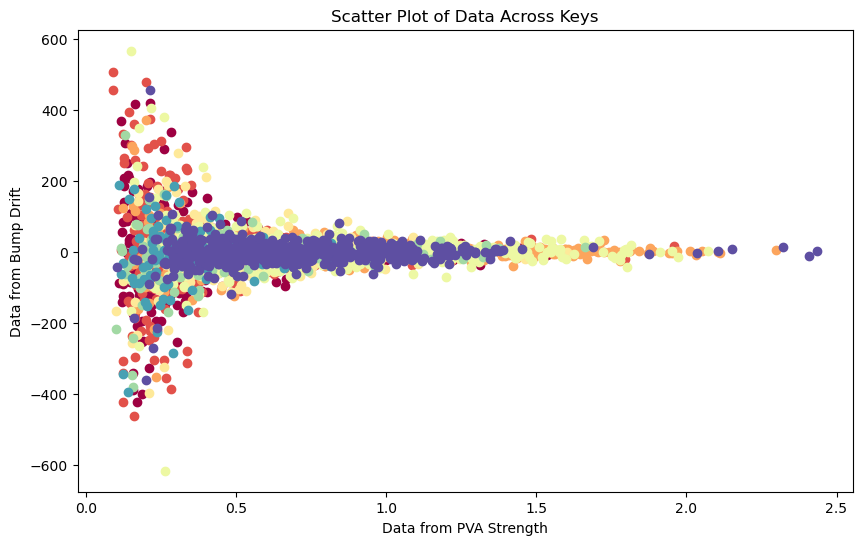

In [12]:
# Prepare the figure
plt.figure(figsize=(10, 6))

# Get a colormap
cmap = plt.get_cmap('Spectral')

# Get all keys from one dictionary (assuming both dictionaries have the same keys)
keys = data_all['output_second_wise_PVA_strength'].keys()
colors = cmap(np.linspace(0, 1, len(keys)))

# Loop through each key
for idx, key in enumerate(keys):
    # Check if the key exists in both dictionaries
    if key in data_all['output_second_wise_bump_drift']:
        # Flatten all arrays from both dictionaries for the current key
        # Modify here to handle lists of arrays
        data1 = np.concatenate([np.ravel(arr) for sublist in data_all['output_second_wise_PVA_strength'][key] for arr in sublist if len(arr) > 0])
        data2 = np.concatenate([np.ravel(arr) for sublist in data_all['output_second_wise_bump_drift'][key] for arr in sublist if len(arr) > 0])
        
        # Ensure that both have the same length
        min_len = min(len(data1), len(data2))
        data1, data2 = data1[:min_len], data2[:min_len]
        
        # Scatter plot for this key
        plt.scatter(data1, data2, color=colors[idx], label=key)

# Adding labels and title
plt.xlabel('Data from PVA Strength')
plt.ylabel('Data from Bump Drift')
plt.title('Scatter Plot of Data Across Keys')
#plt.legend(title='Key', loc='upper right')

# Show plot
plt.show()

In [86]:
# Initialize lists to store the combined data from all keys
all_data1 = []
all_data2 = []

# Loop through each key in the dictionary
for key in data_all['output_second_wise_PVA_strength'].keys():
    if key in data_all['output_second_wise_bump_drift']:
        if len(data_all['output_second_wise_PVA_strength'][key]) > 0:
            # Extract non-empty arrays for data1 and data2
            data1_list = [np.ravel(arr) for sublist in data_all['output_second_wise_PVA_strength'][key] for arr in sublist if len(arr) > 0]
            data2_list = [np.ravel(arr) for sublist in data_all['output_second_wise_bump_drift'][key] for arr in sublist if len(arr) > 0]

            # Ensure that both lists contain valid data
            if len(data1_list) > 0 and len(data2_list) > 0:
                data1 = np.concatenate(data1_list)
                data2 = np.concatenate(data2_list)

                # Ensure that both have the same length
                min_len = min(len(data1), len(data2))
                data1, data2 = data1[:min_len], data2[:min_len]

                # Append to the combined lists
                all_data1.extend(data1)
                all_data2.extend(data2)

# Create a DataFrame and save to CSV
df = pd.DataFrame({'PVA_strength': all_data1, 'Bump_drift': all_data2})
df.to_csv('group2_data.csv', index=False)

In [9]:
def analyze_and_plot_variance_with_bins(group1_csv, group2_csv, num_bins=10, significance_level=0.05, drop_threshold=None):
    """
    Perform variance analysis with optional dropping of extreme low PVA strength values.
    
    Parameters:
        group1_csv (str): Path to CSV for group 1.
        group2_csv (str): Path to CSV for group 2.
        num_bins (int): Number of bins for PVA strength.
        significance_level (float): P-value threshold for significance.
        drop_threshold (float or None): If provided, points below (mean - drop_threshold * std) will be dropped.
    """
    # Read the CSV files for two groups
    group1 = pd.read_csv(group1_csv)
    group2 = pd.read_csv(group2_csv)

    # Extract the data
    group1_x = group1['PVA_strength'].values
    group1_y = np.abs(group1['Bump_drift'].values)
    group2_x = group2['PVA_strength'].values
    group2_y = np.abs(group2['Bump_drift'].values)

    # Optionally drop data points based on PVA strength threshold
    def drop_low_pva(group_x, group_y, threshold):
        if threshold is not None:
            mean_x = np.mean(group_x)
            std_x = np.std(group_x)
            threshold_value = mean_x - threshold * std_x

            # Filter data
            mask = group_x >= threshold_value
            dropped_count = len(group_x) - np.sum(mask)  # Count dropped points

            return group_x[mask], group_y[mask], dropped_count
        else:
            return group_x, group_y, 0

    # Apply threshold dropping if specified
    group1_x, group1_y, dropped_group1 = drop_low_pva(group1_x, group1_y, drop_threshold)
    group2_x, group2_y, dropped_group2 = drop_low_pva(group2_x, group2_y, drop_threshold)

    # Print how many data points were dropped
    print(f"Group 1: Dropped {dropped_group1} points below {drop_threshold} std threshold")
    print(f"Group 2: Dropped {dropped_group2} points below {drop_threshold} std threshold")

    # Define the bins for PVA strength with the specified number of bins
    bins = np.linspace(min(group1_x.min(), group2_x.min()), max(group1_x.max(), group2_x.max()), num_bins)

    # Initialize arrays to store variance for each bin
    variance_group1 = []
    variance_group2 = []
    group1_counts = []
    group2_counts = []
    p_values = []

    # Loop through each bin and calculate variance
    for i in range(len(bins) - 1):
        # Filter data in the current bin for both groups
        bin_group1_y = group1_y[(group1_x >= bins[i]) & (group1_x < bins[i+1])]
        bin_group2_y = group2_y[(group2_x >= bins[i]) & (group2_x < bins[i+1])]
        
        # Calculate variance for both groups in this bin
        var_group1 = np.var(bin_group1_y) if len(bin_group1_y) > 1 else np.nan
        var_group2 = np.var(bin_group2_y) if len(bin_group2_y) > 1 else np.nan
        
        # Store the variances
        variance_group1.append(var_group1)
        variance_group2.append(var_group2)
        
        # Store the counts of data points
        group1_counts.append(len(bin_group1_y))
        group2_counts.append(len(bin_group2_y))
        
        # Perform Levene's test to compare variance between the two groups
        if len(bin_group1_y) > 1 and len(bin_group2_y) > 1:
            stat, p = levene(bin_group1_y, bin_group2_y)
            p_values.append(p)
        else:
            p_values.append(np.nan)

    # Plot the variances across bins
    plt.figure(figsize=(10, 7))
    plt.plot(bins[:-1], variance_group1, label='EPG_7b_delta7_attp40_cl Variance', marker='o')
    plt.plot(bins[:-1], variance_group2, label='EPG_7b_delta7_vglut_cl Variance', marker='o')

    # Add asterisks where the result is significant based on p-value thresholds
    for i, p in enumerate(p_values):
        if p is not np.nan:
            if p < 0.0001:
                significance = '****'
            elif p < 0.001:
                significance = '***'
            elif p < 0.01:
                significance = '**'
            elif p < 0.05:
                significance = '*'
            else:
                significance = ''
            
            if significance:
                plt.text(bins[i], max(variance_group1[i], variance_group2[i]) * 1.01, significance, 
                         fontsize=16, color='red', ha='center')
    # Adding labels, title, and legend
    plt.xlabel('PVA Strength', fontsize =12)
    plt.ylabel('Variance in Bump Drift',fontsize =12)
    plt.title(f'Variance in Bump Drift Across PVA Strength Bins',fontsize =15)
    plt.legend()
    plt.show()

    # Print the p-values from Levene's test
    print("P-values from Levene's test for each bin:", p_values)
    
    # Print the number of data points in each bin for both groups
    print("\nNumber of data points in each bin for Group 1:", group1_counts)
    print("Number of data points in each bin for Group 2:", group2_counts)

Group 1: Dropped 178 points below 1 std threshold
Group 2: Dropped 12 points below 1 std threshold


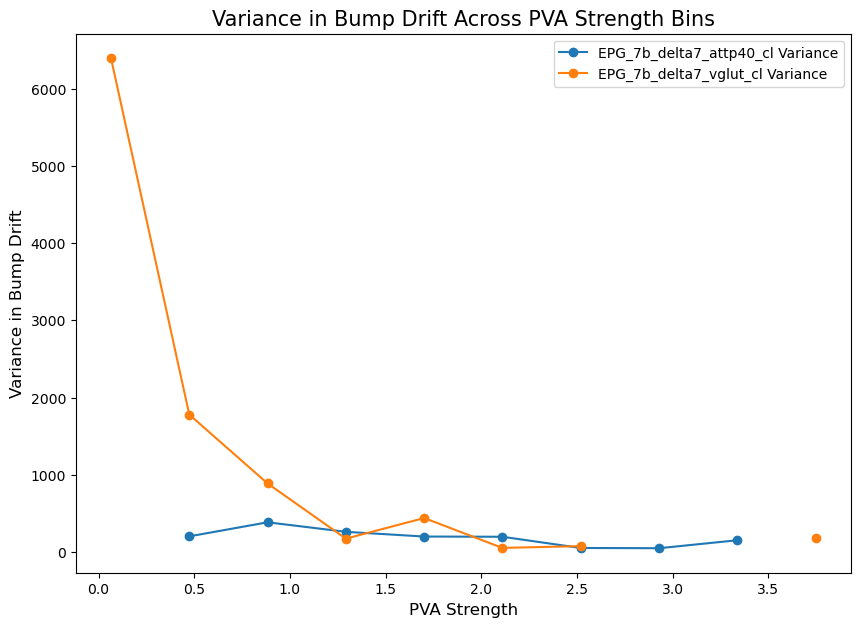

P-values from Levene's test for each bin: [nan, 0.055992923527679705, 0.28320090428467265, 0.954877653017181, 0.14748745542843456, 0.5335405519543462, 0.38539454344563495, nan, nan, nan]

Number of data points in each bin for Group 1: [0, 17, 256, 299, 195, 51, 18, 11, 2, 0]
Number of data points in each bin for Group 2: [685, 283, 97, 51, 21, 7, 2, 0, 1, 2]


In [35]:
analyze_and_plot_variance_with_bins('group1_data.csv','group2_data.csv', num_bins=11, significance_level=0.05, drop_threshold=1)

Processing dataset: output_second_wise_bump_drift
Processing experiment: TQfly047


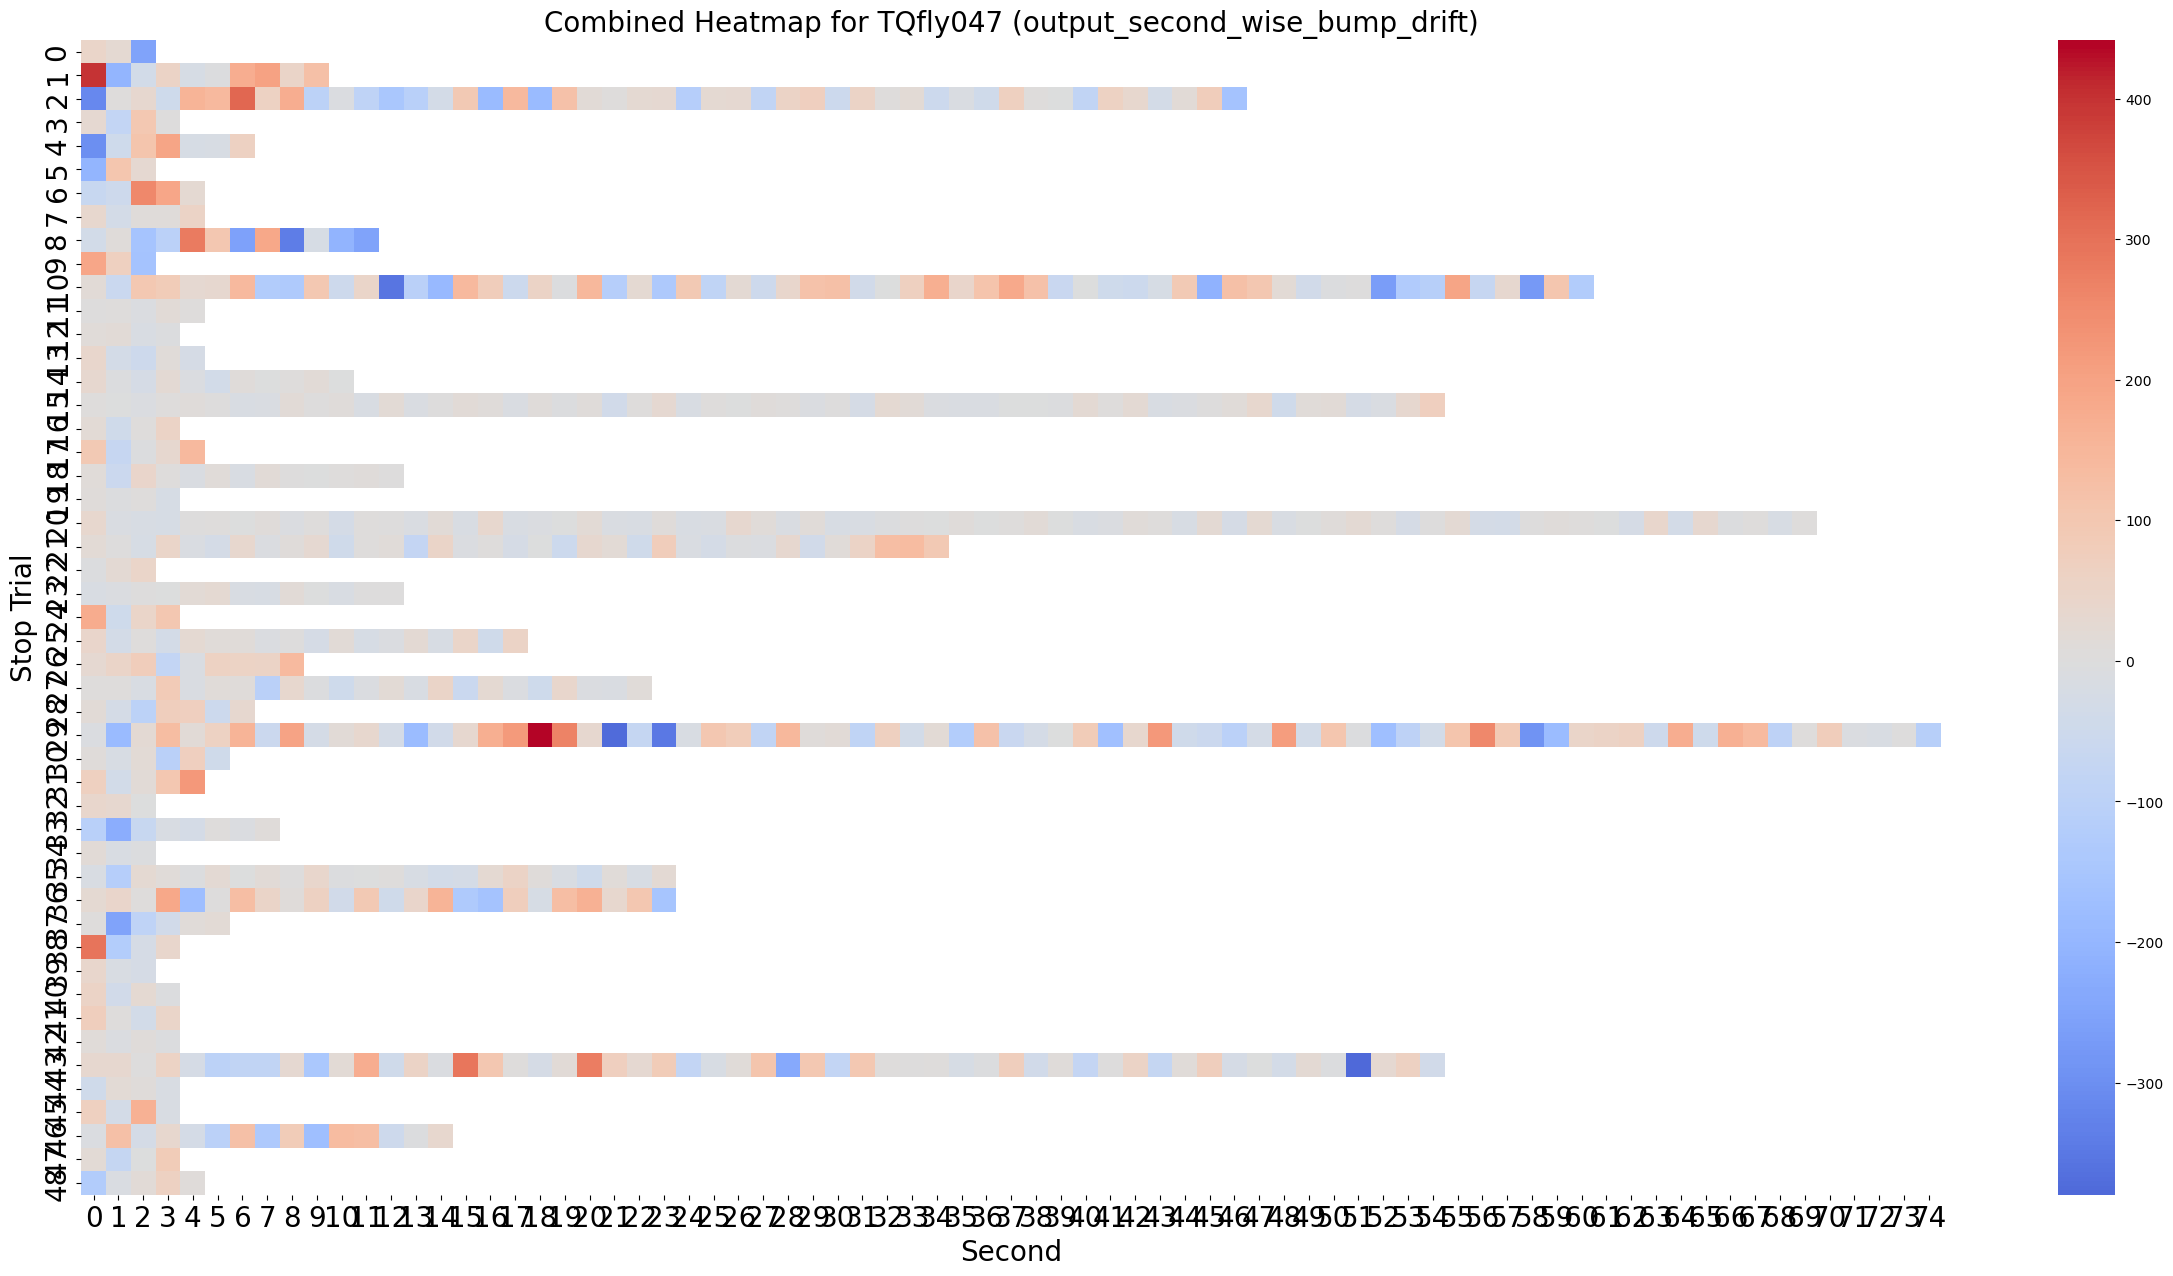

Processing experiment: TQfly028


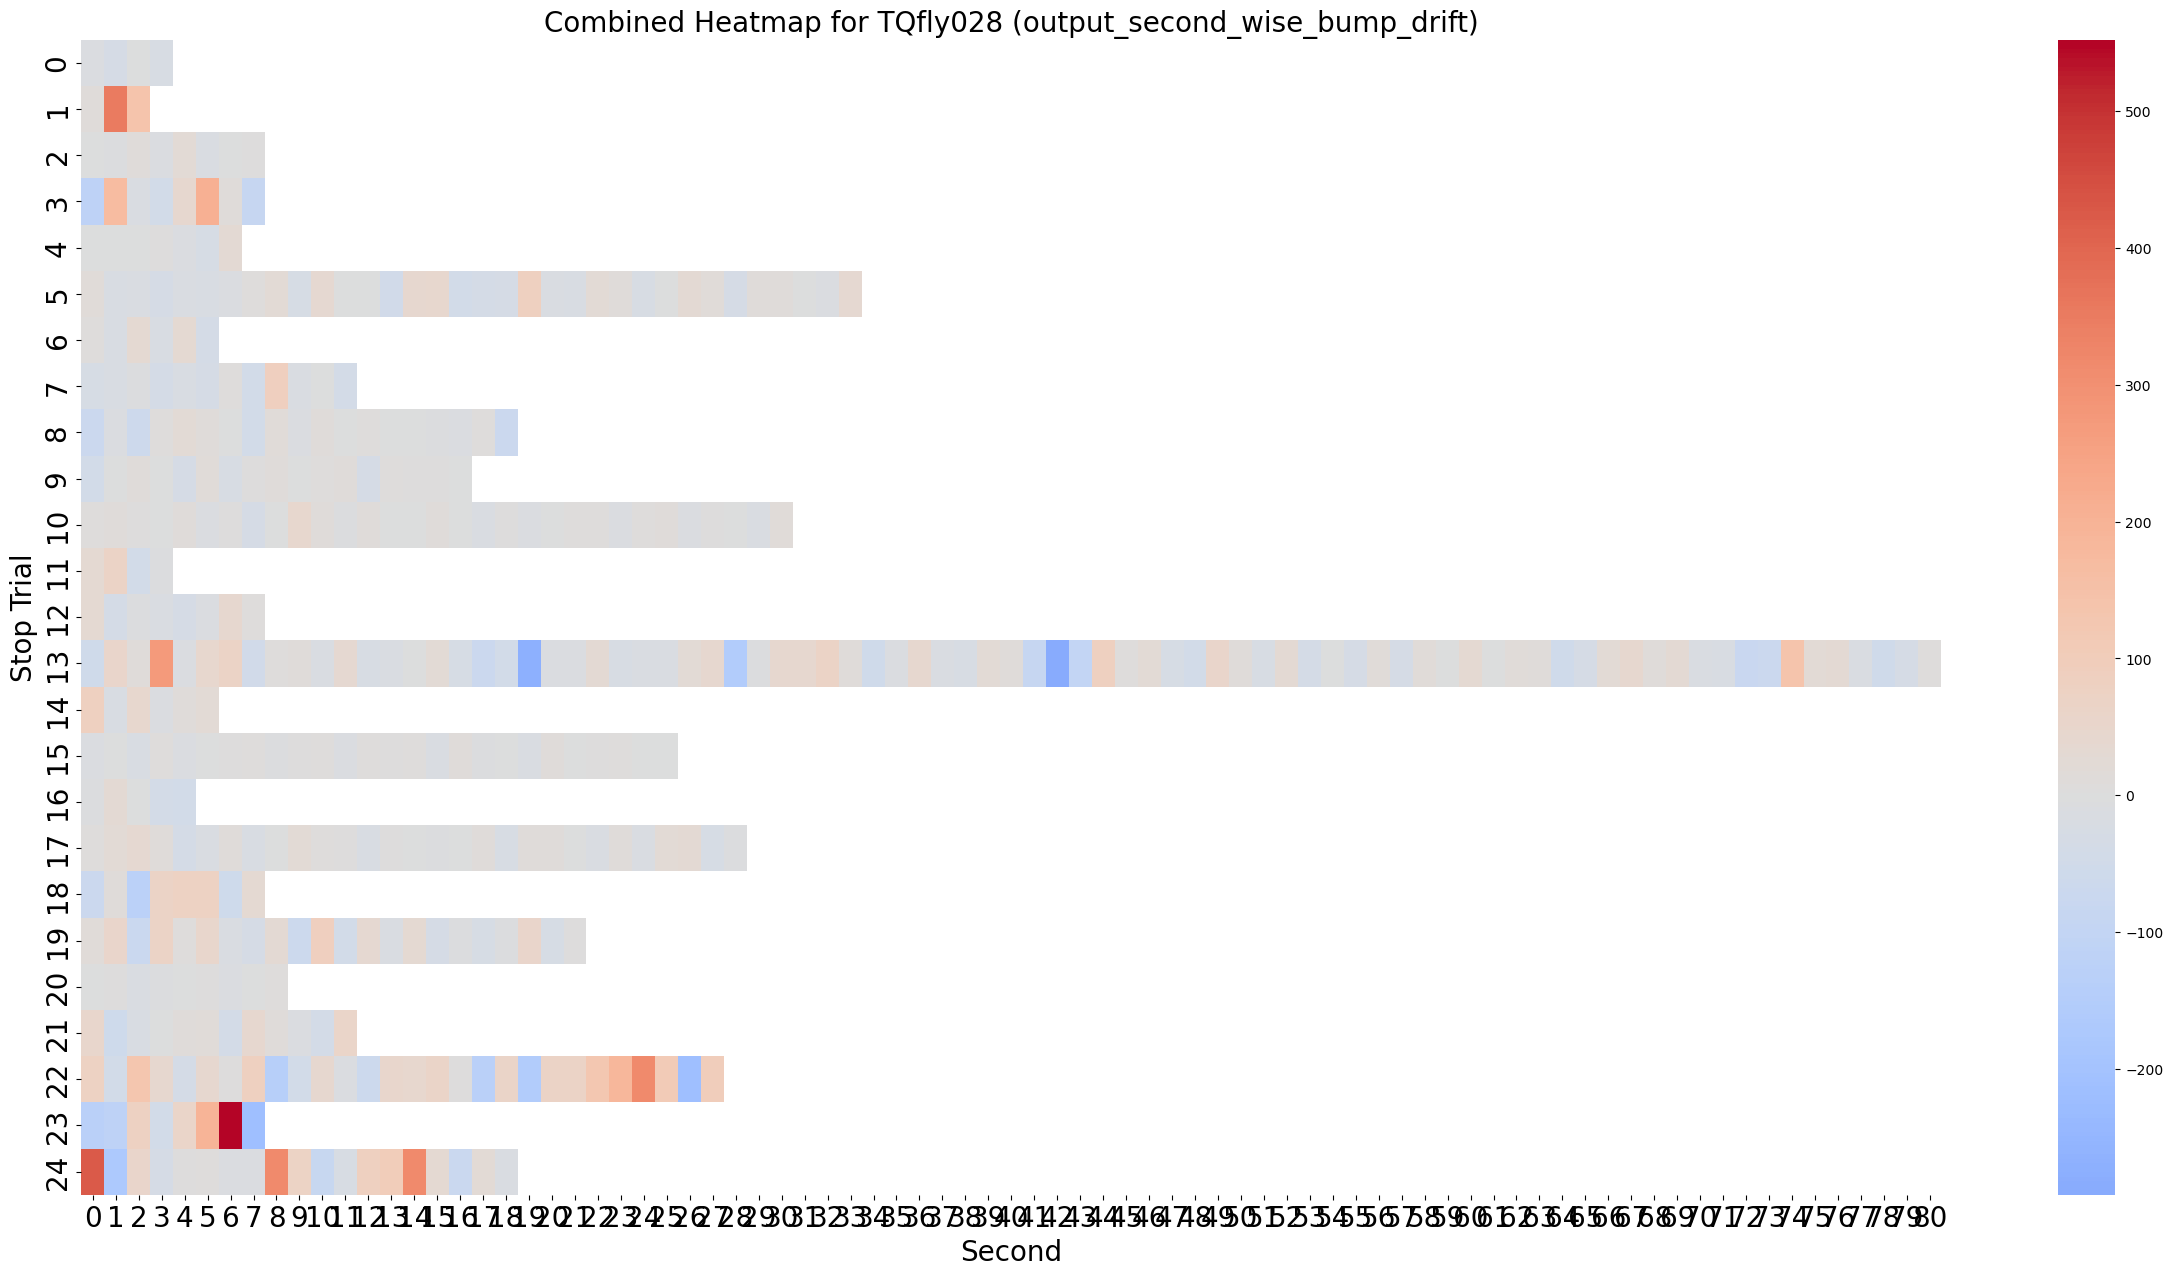

Processing experiment: TQfly050


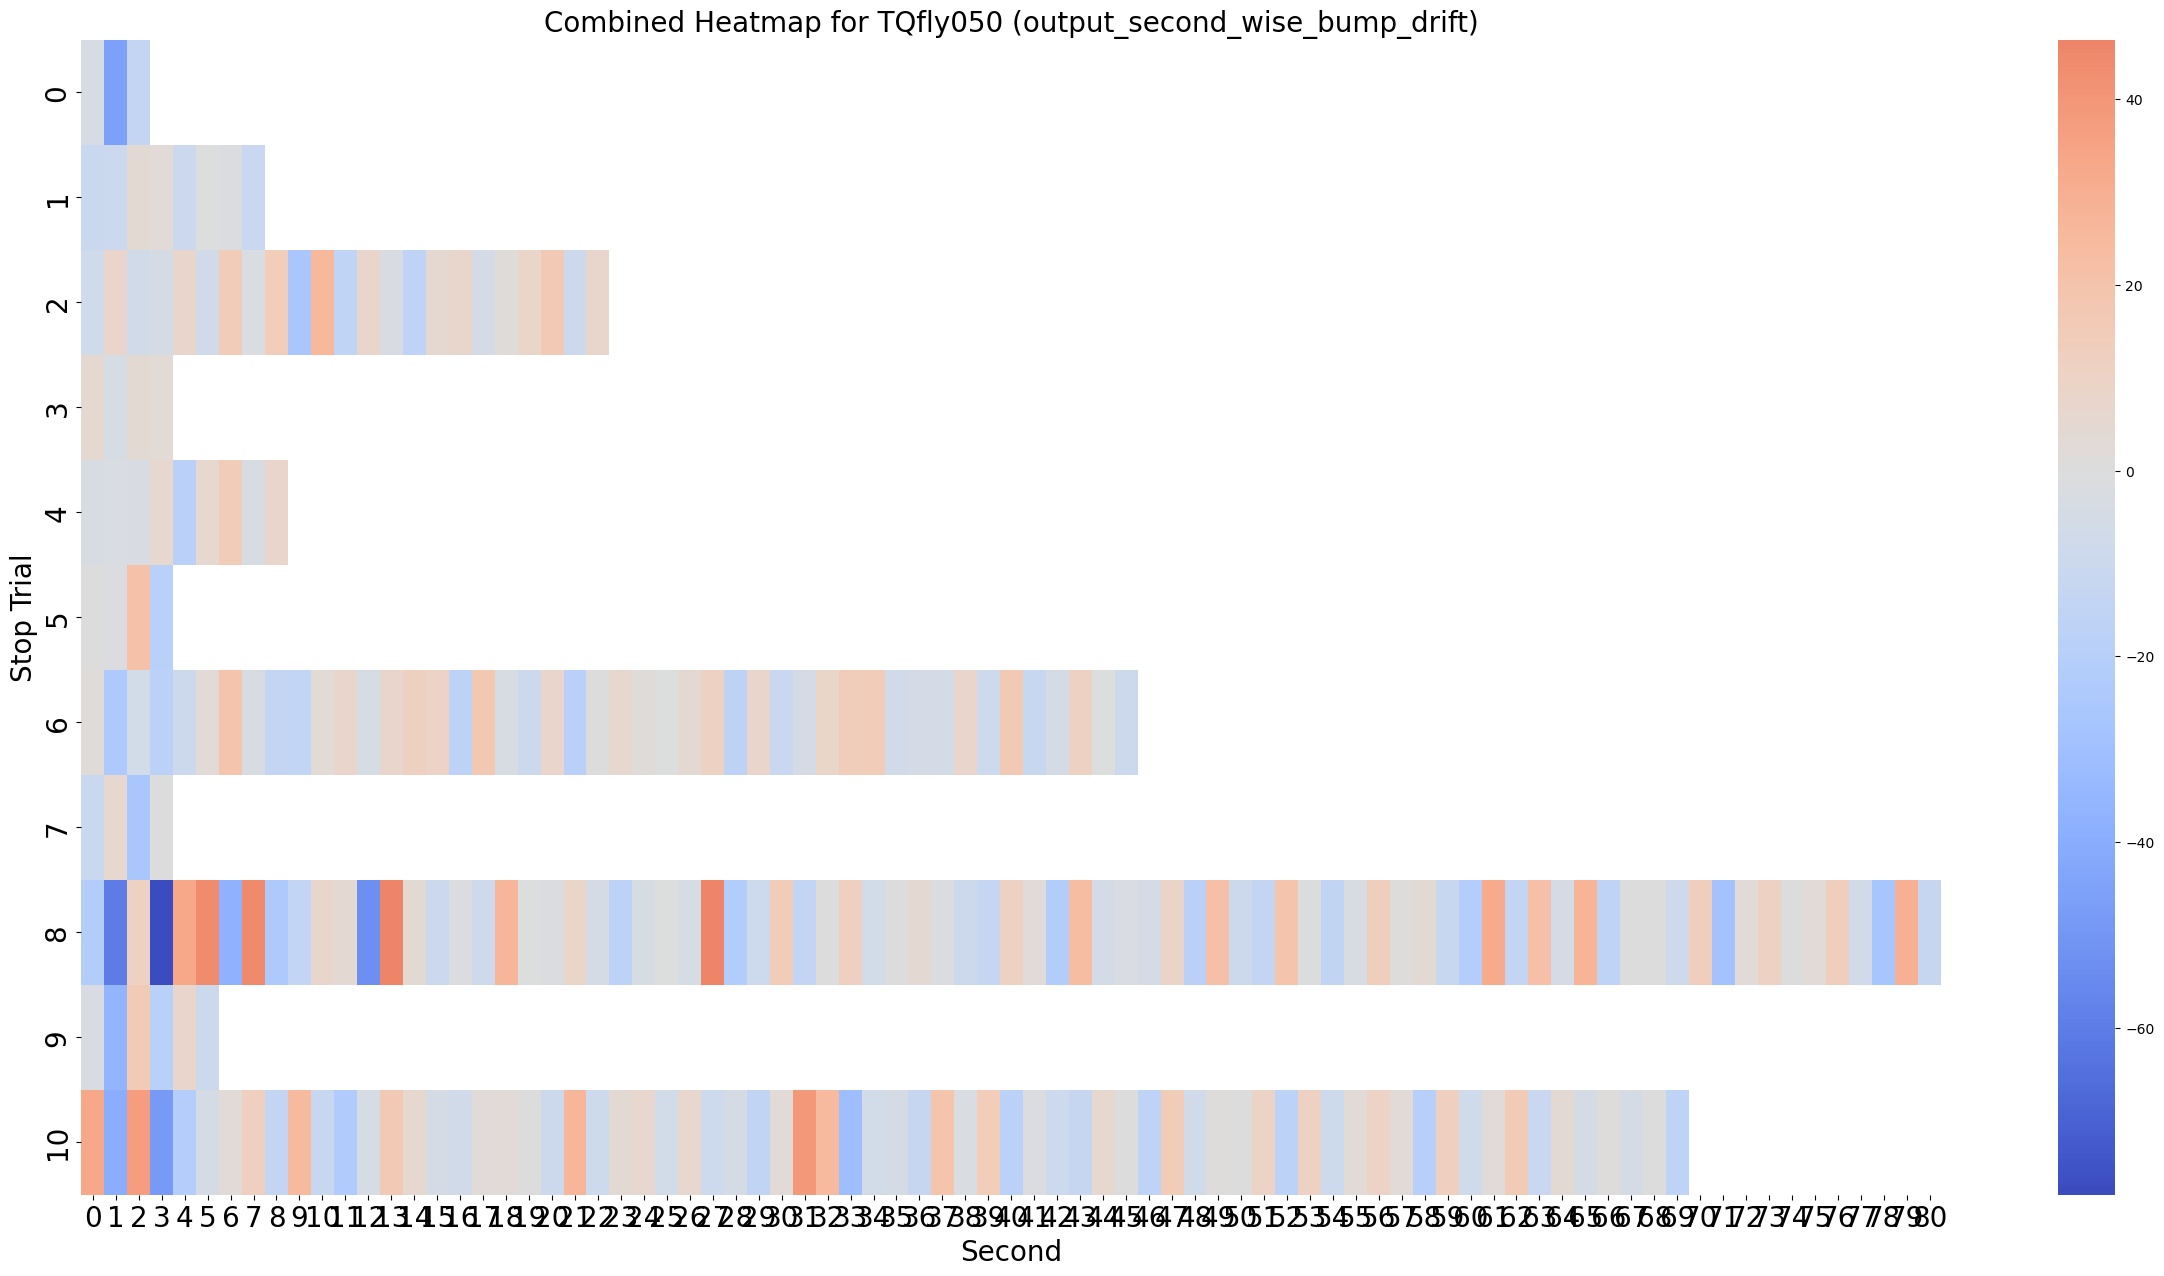

Processing experiment: TQfly029


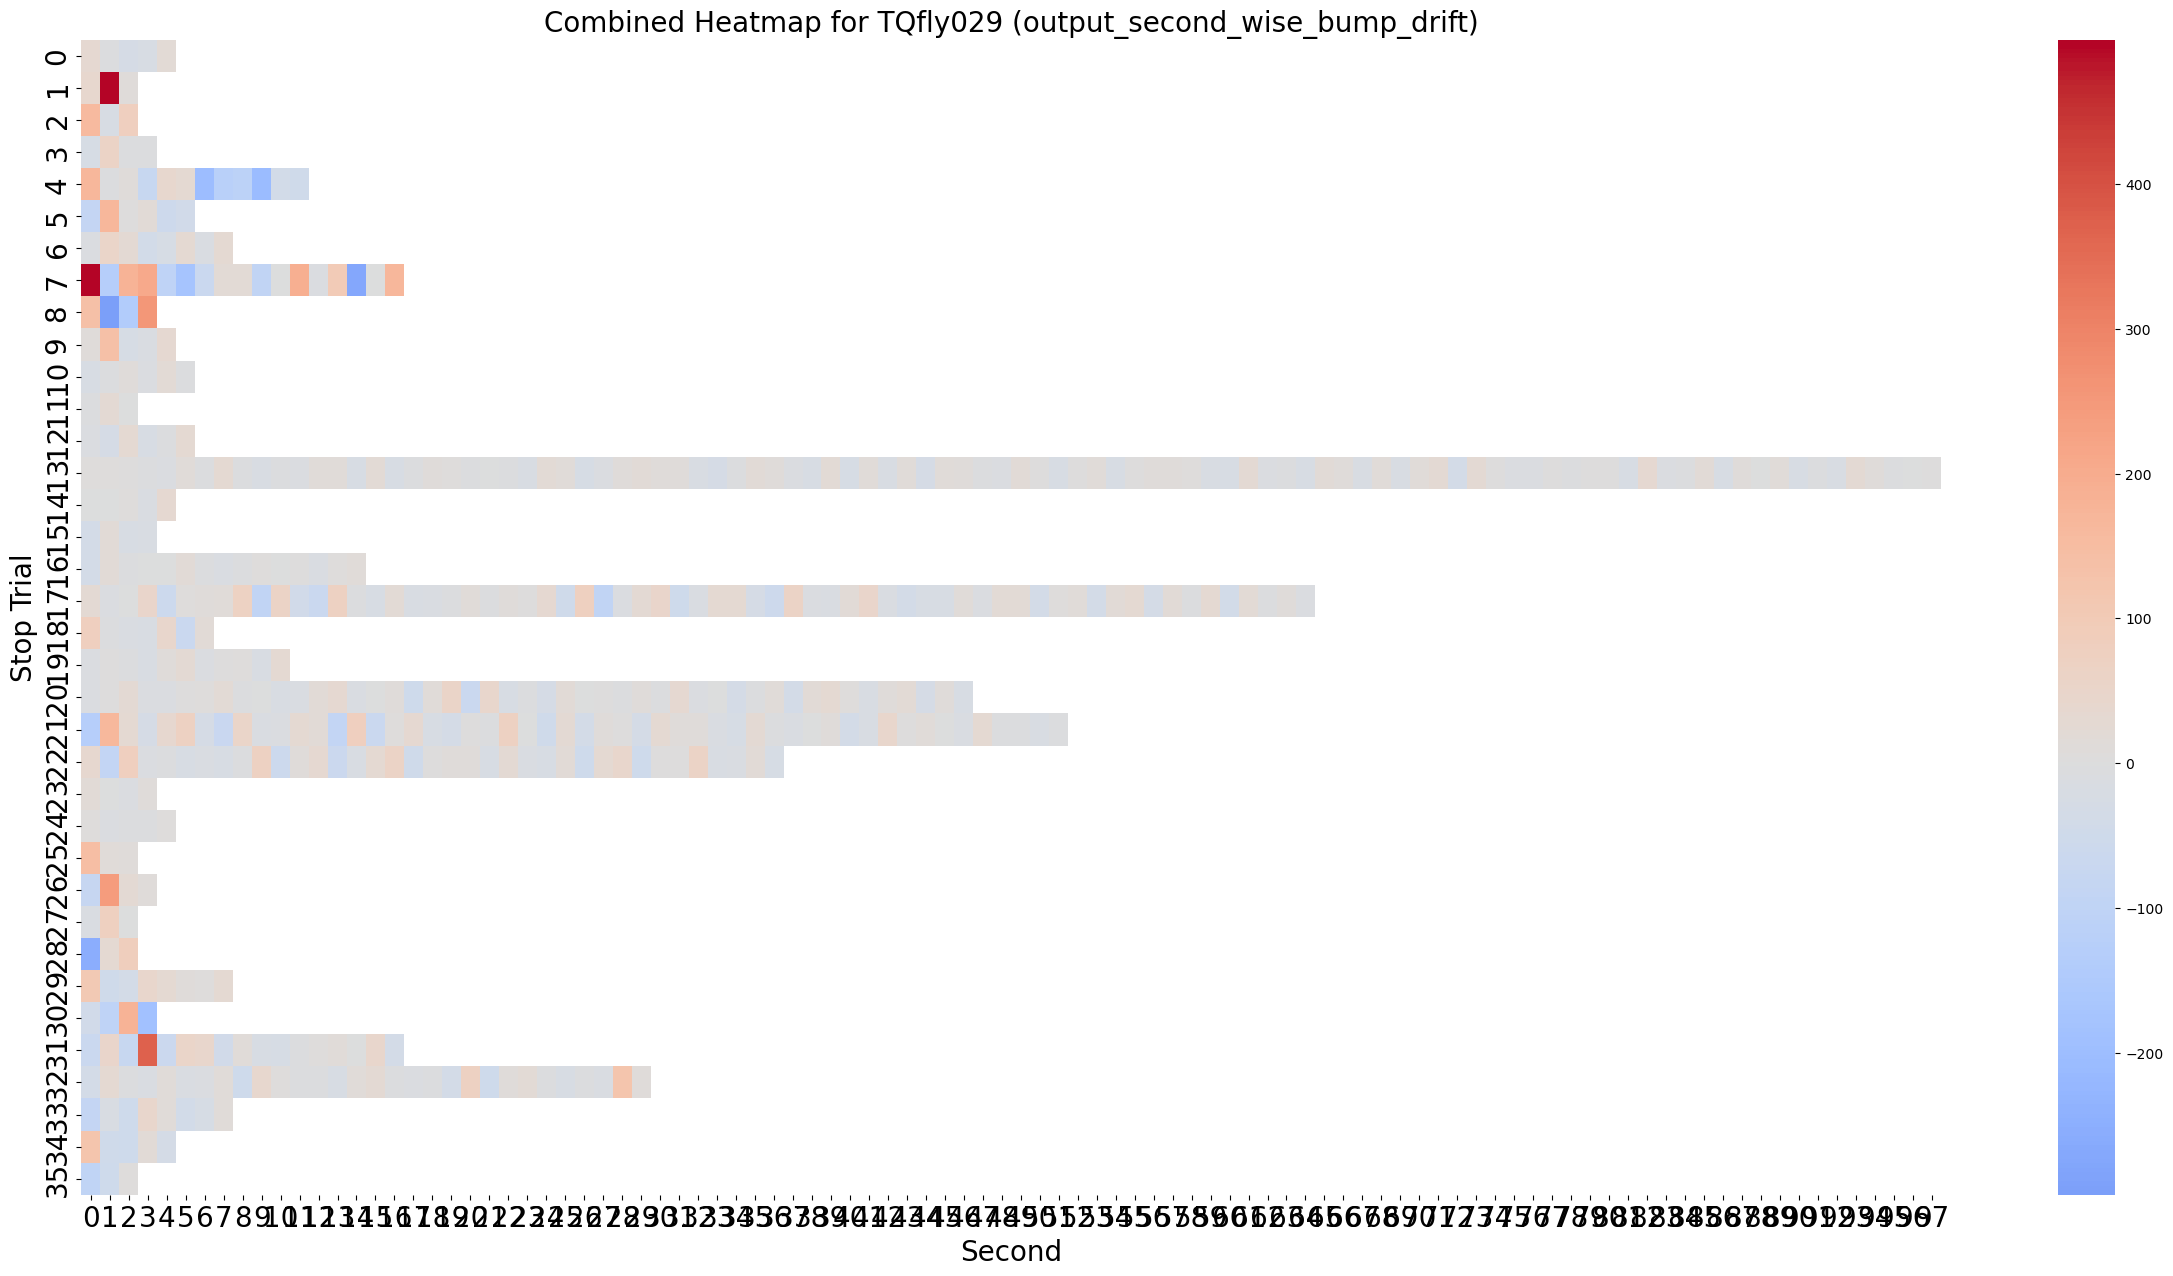

Processing experiment: TQfly052


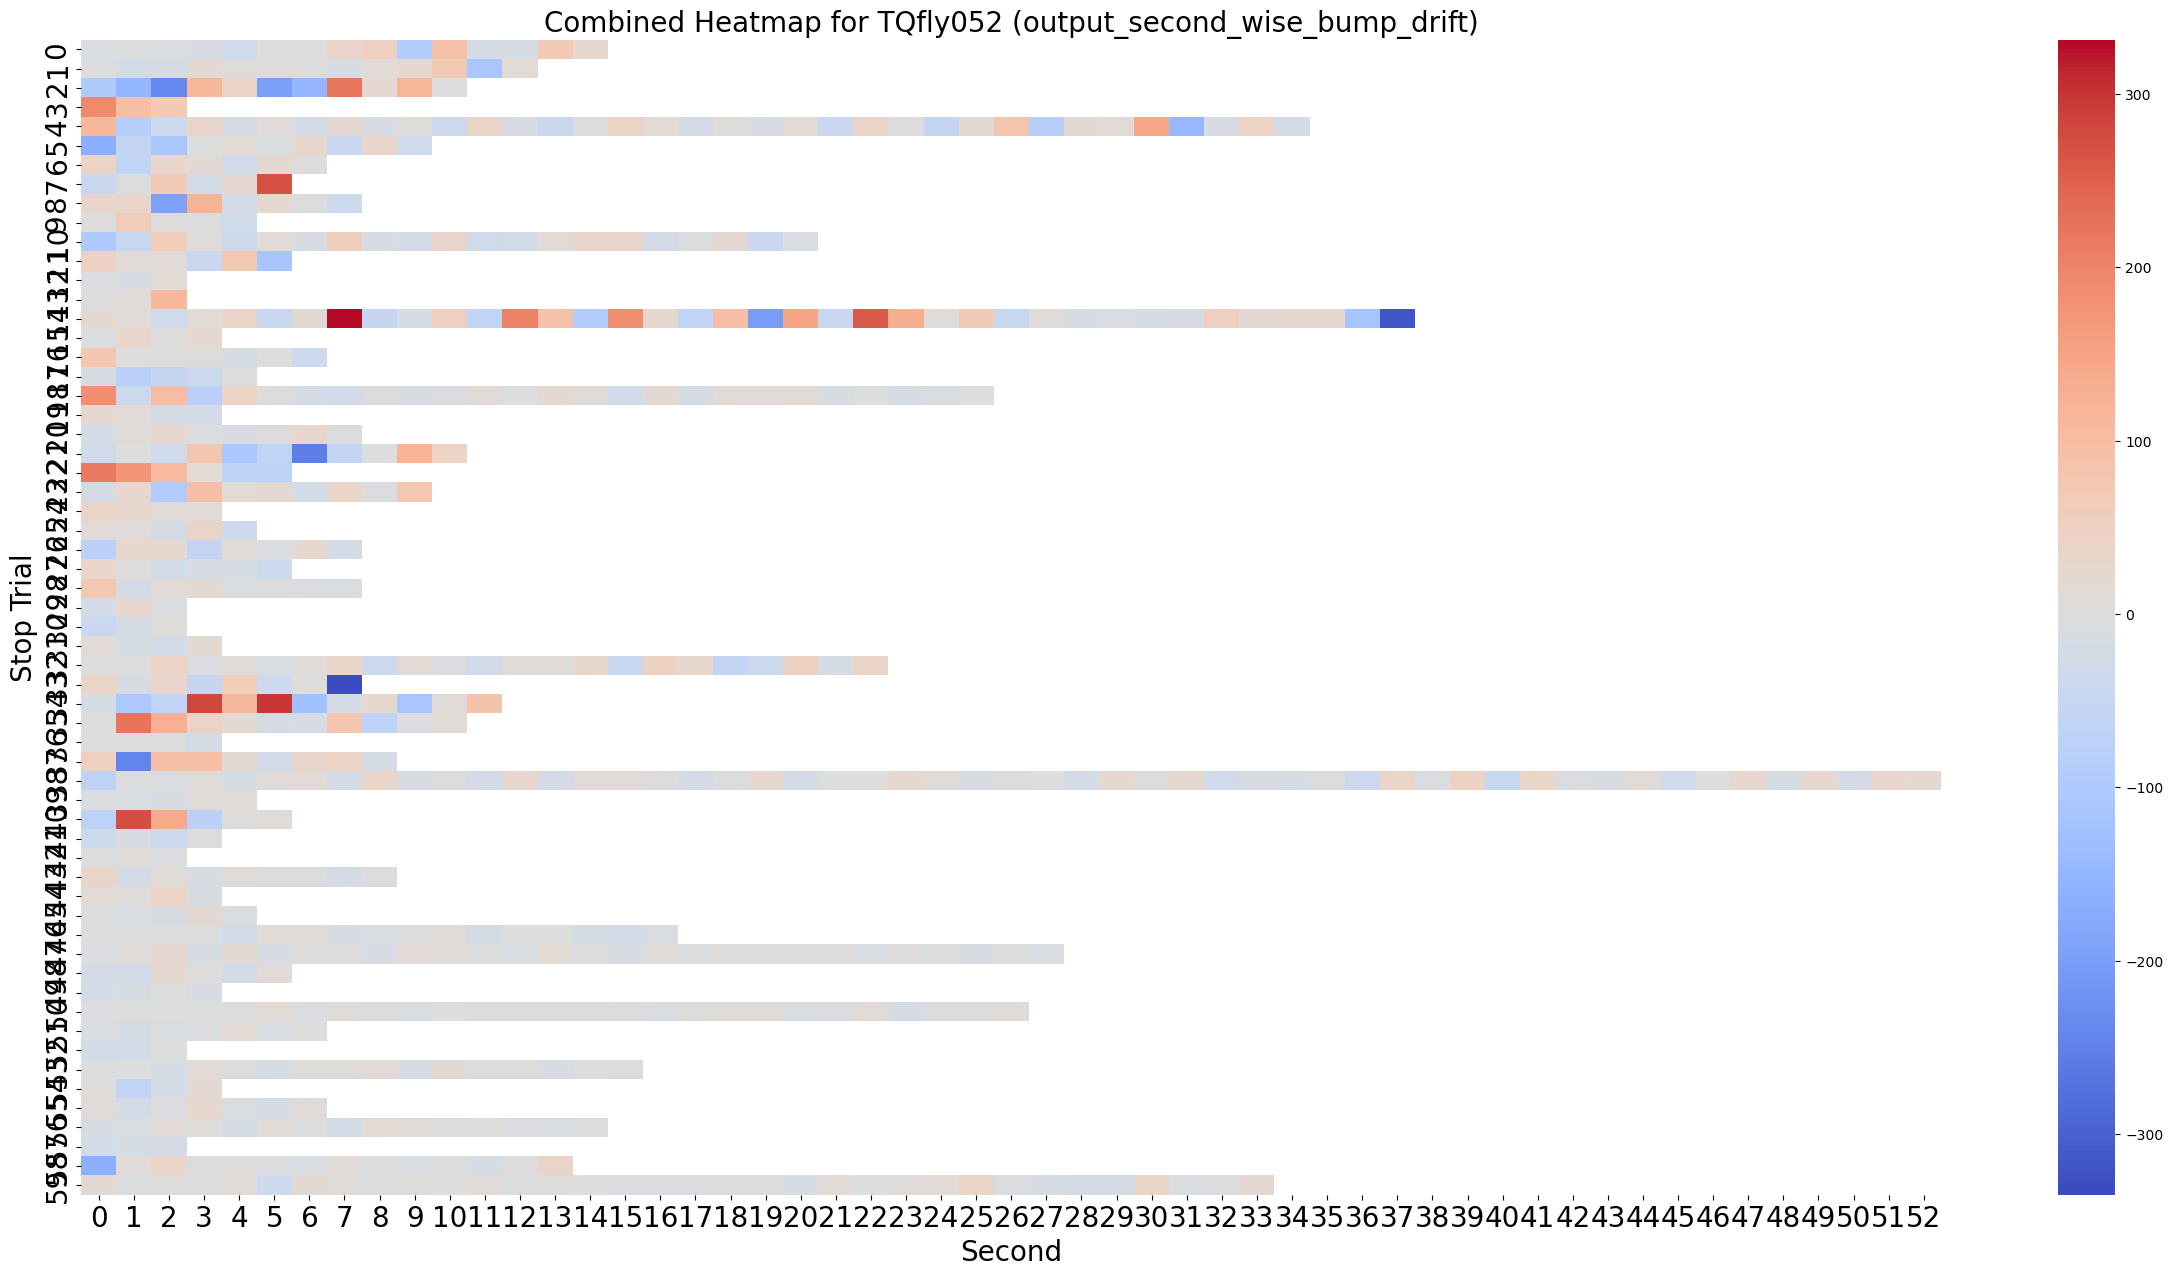

Processing experiment: TQfly048


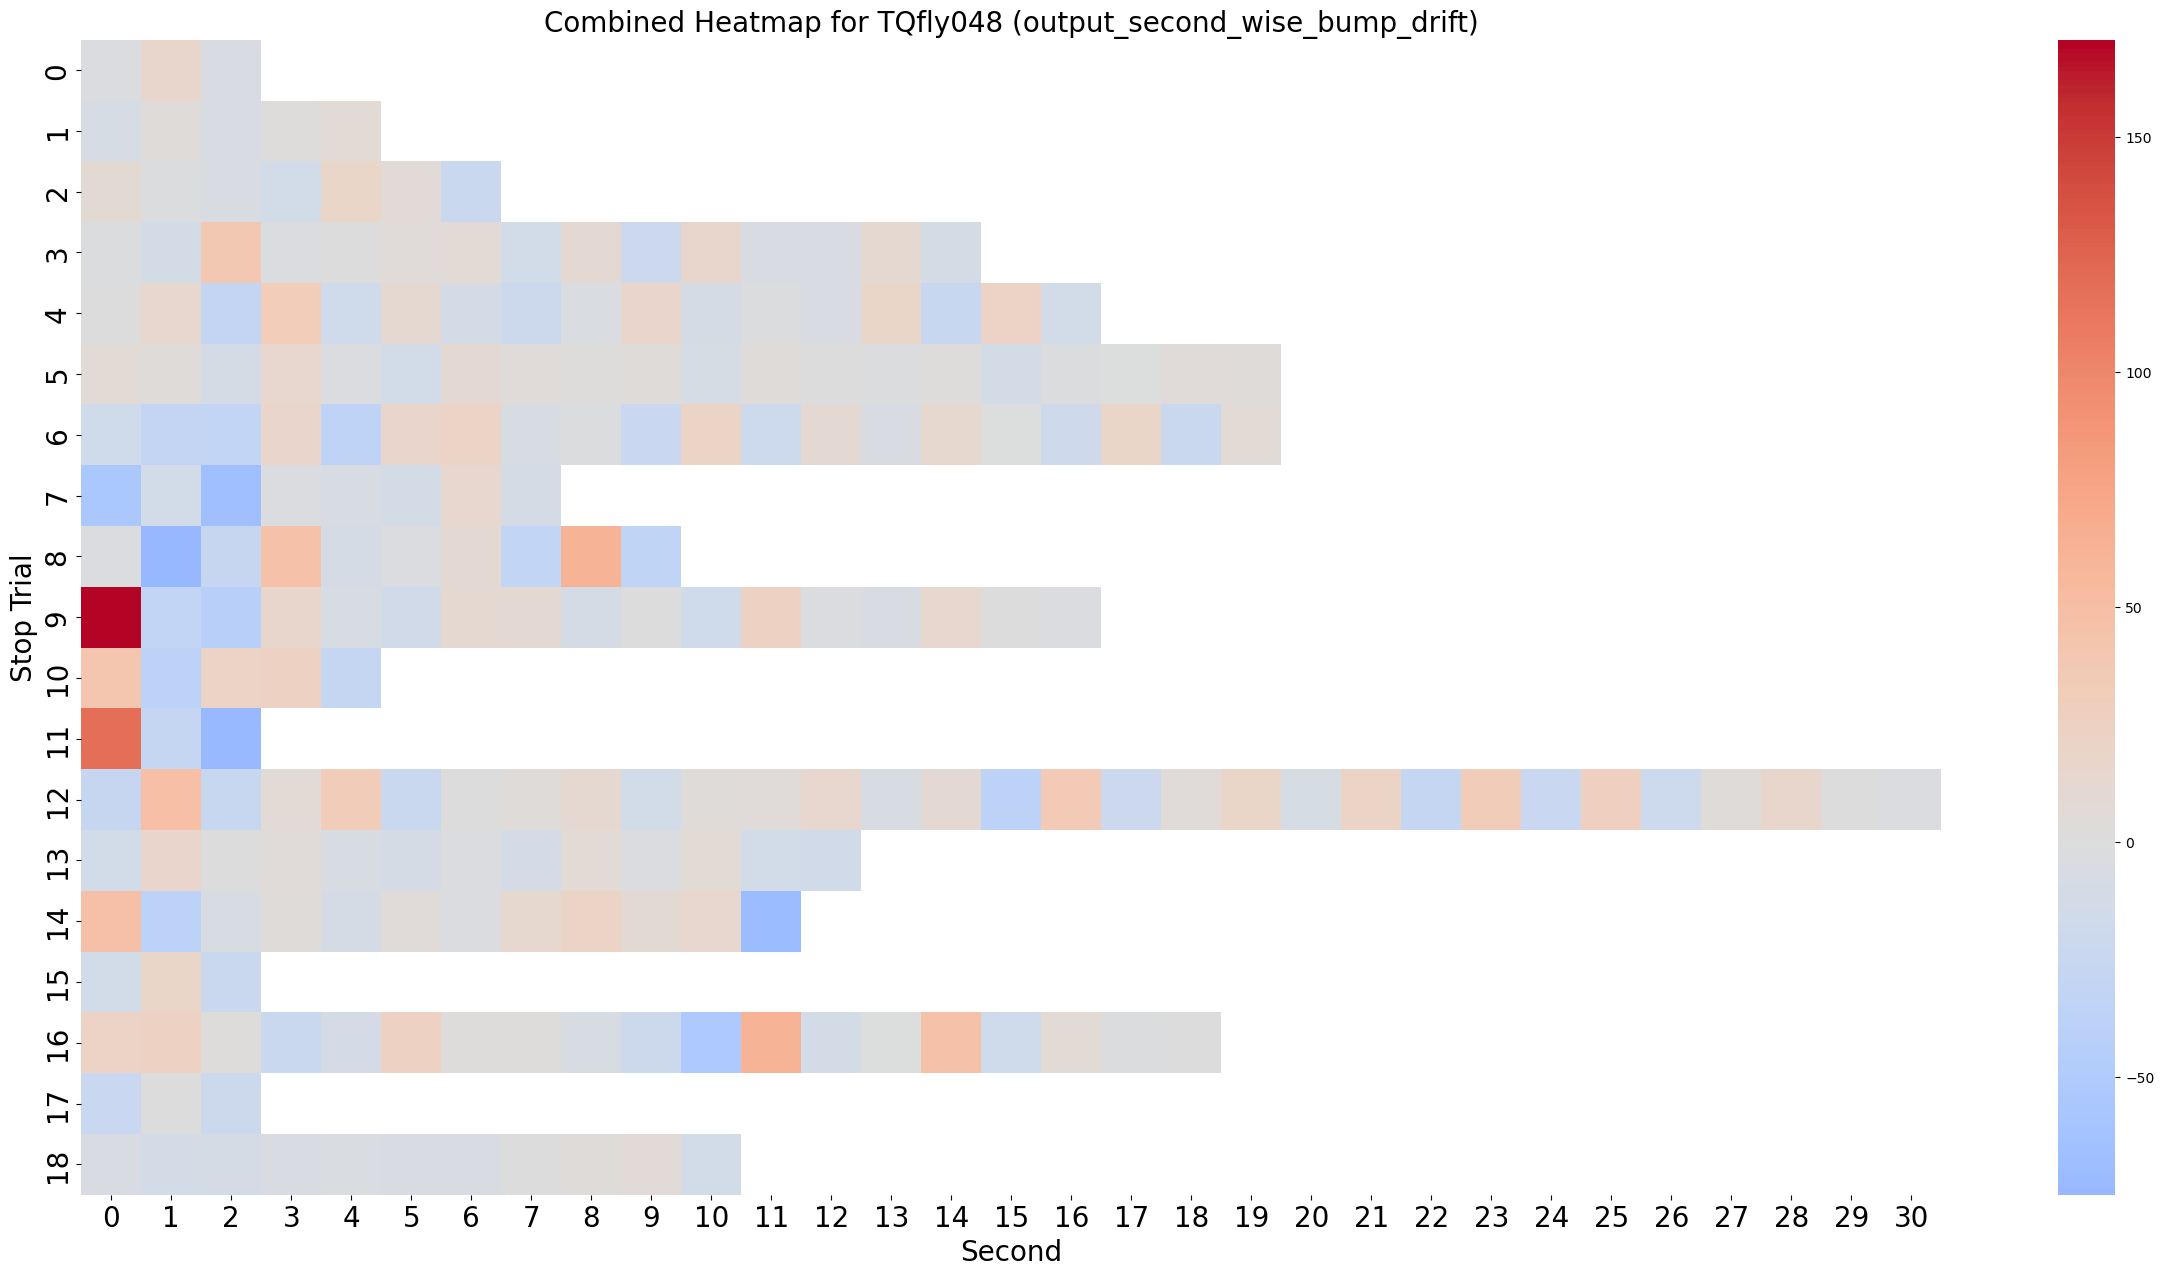

Processing experiment: TQfly049


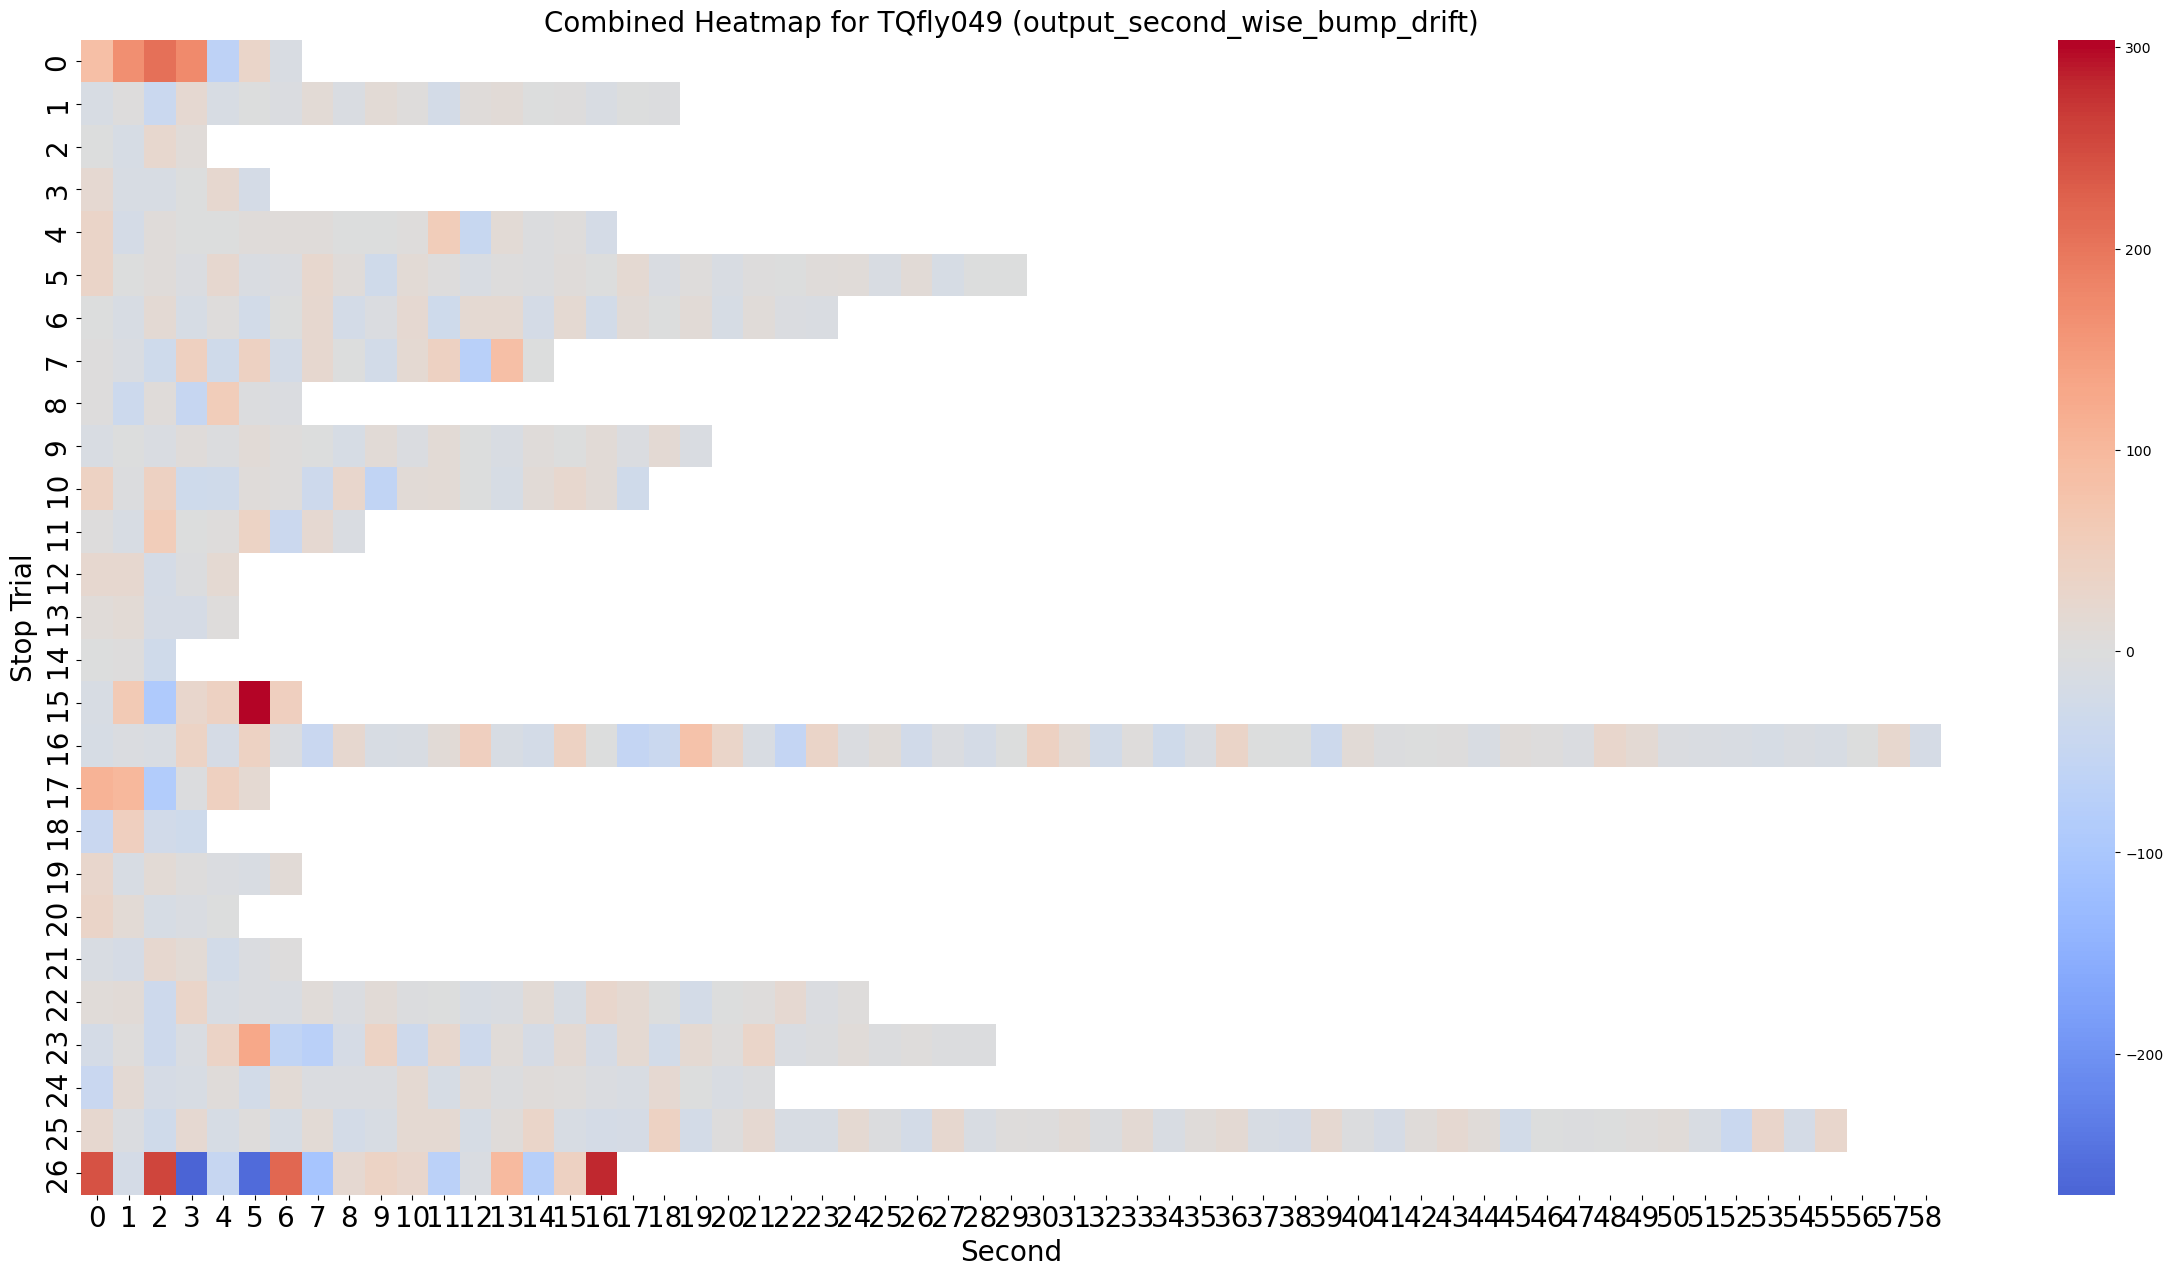

Processing experiment: TQfly025


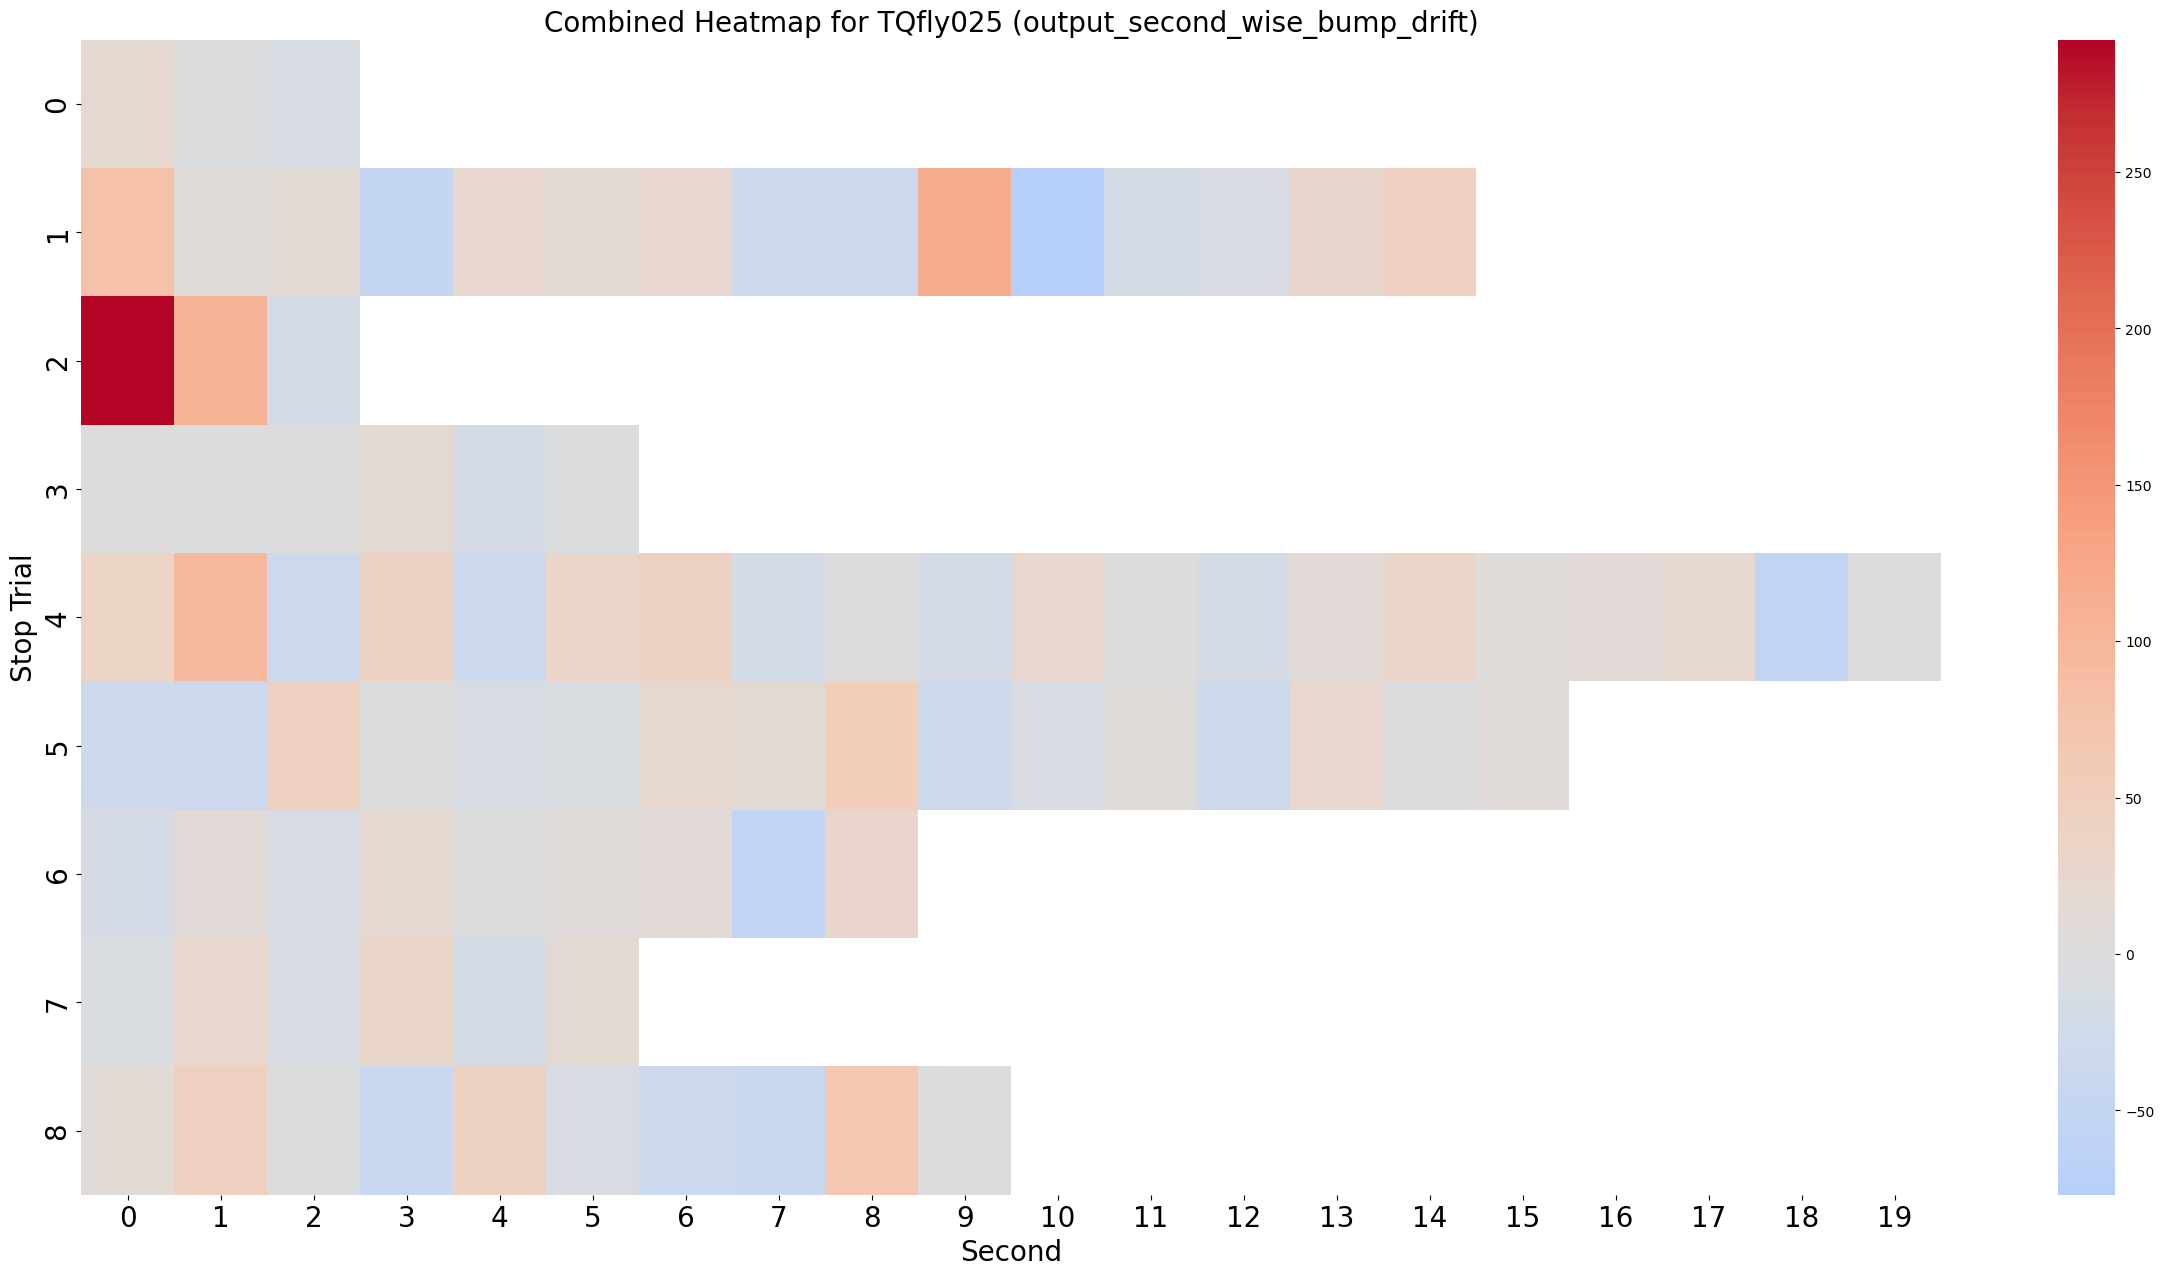

Done plotting heatmaps for output_second_wise_bump_drift.


In [9]:
plot_stop_drift_rate_heatmaps(data_all,"output_second_wise_bump_drift")

Processing dataset: output_second_wise_bump_drift_right_before_stop
Processing experiment: TQfly115


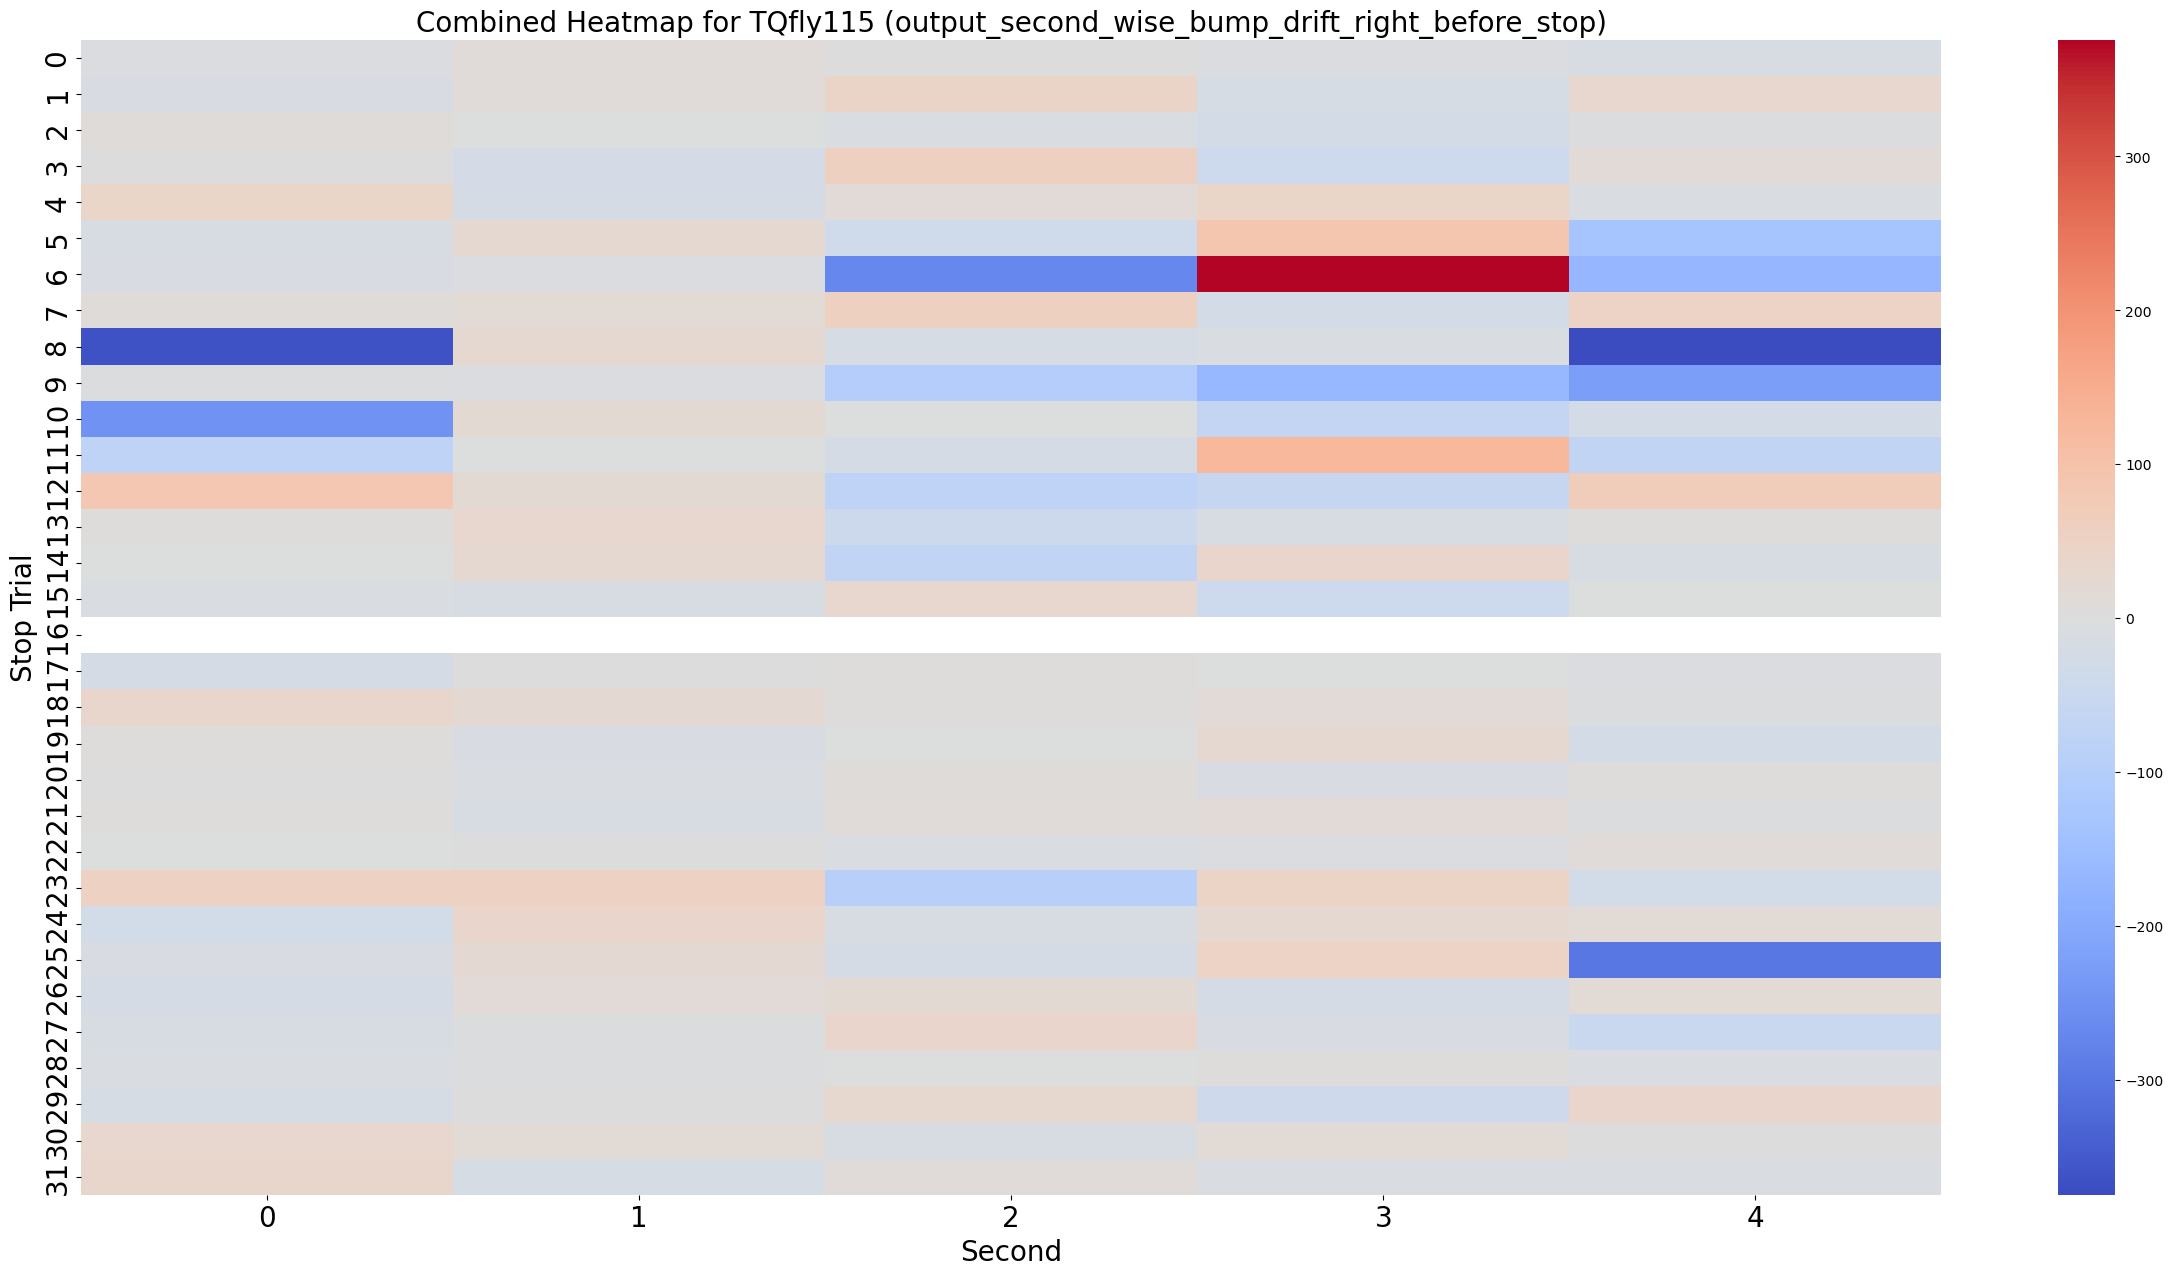

Processing experiment: TQfly109


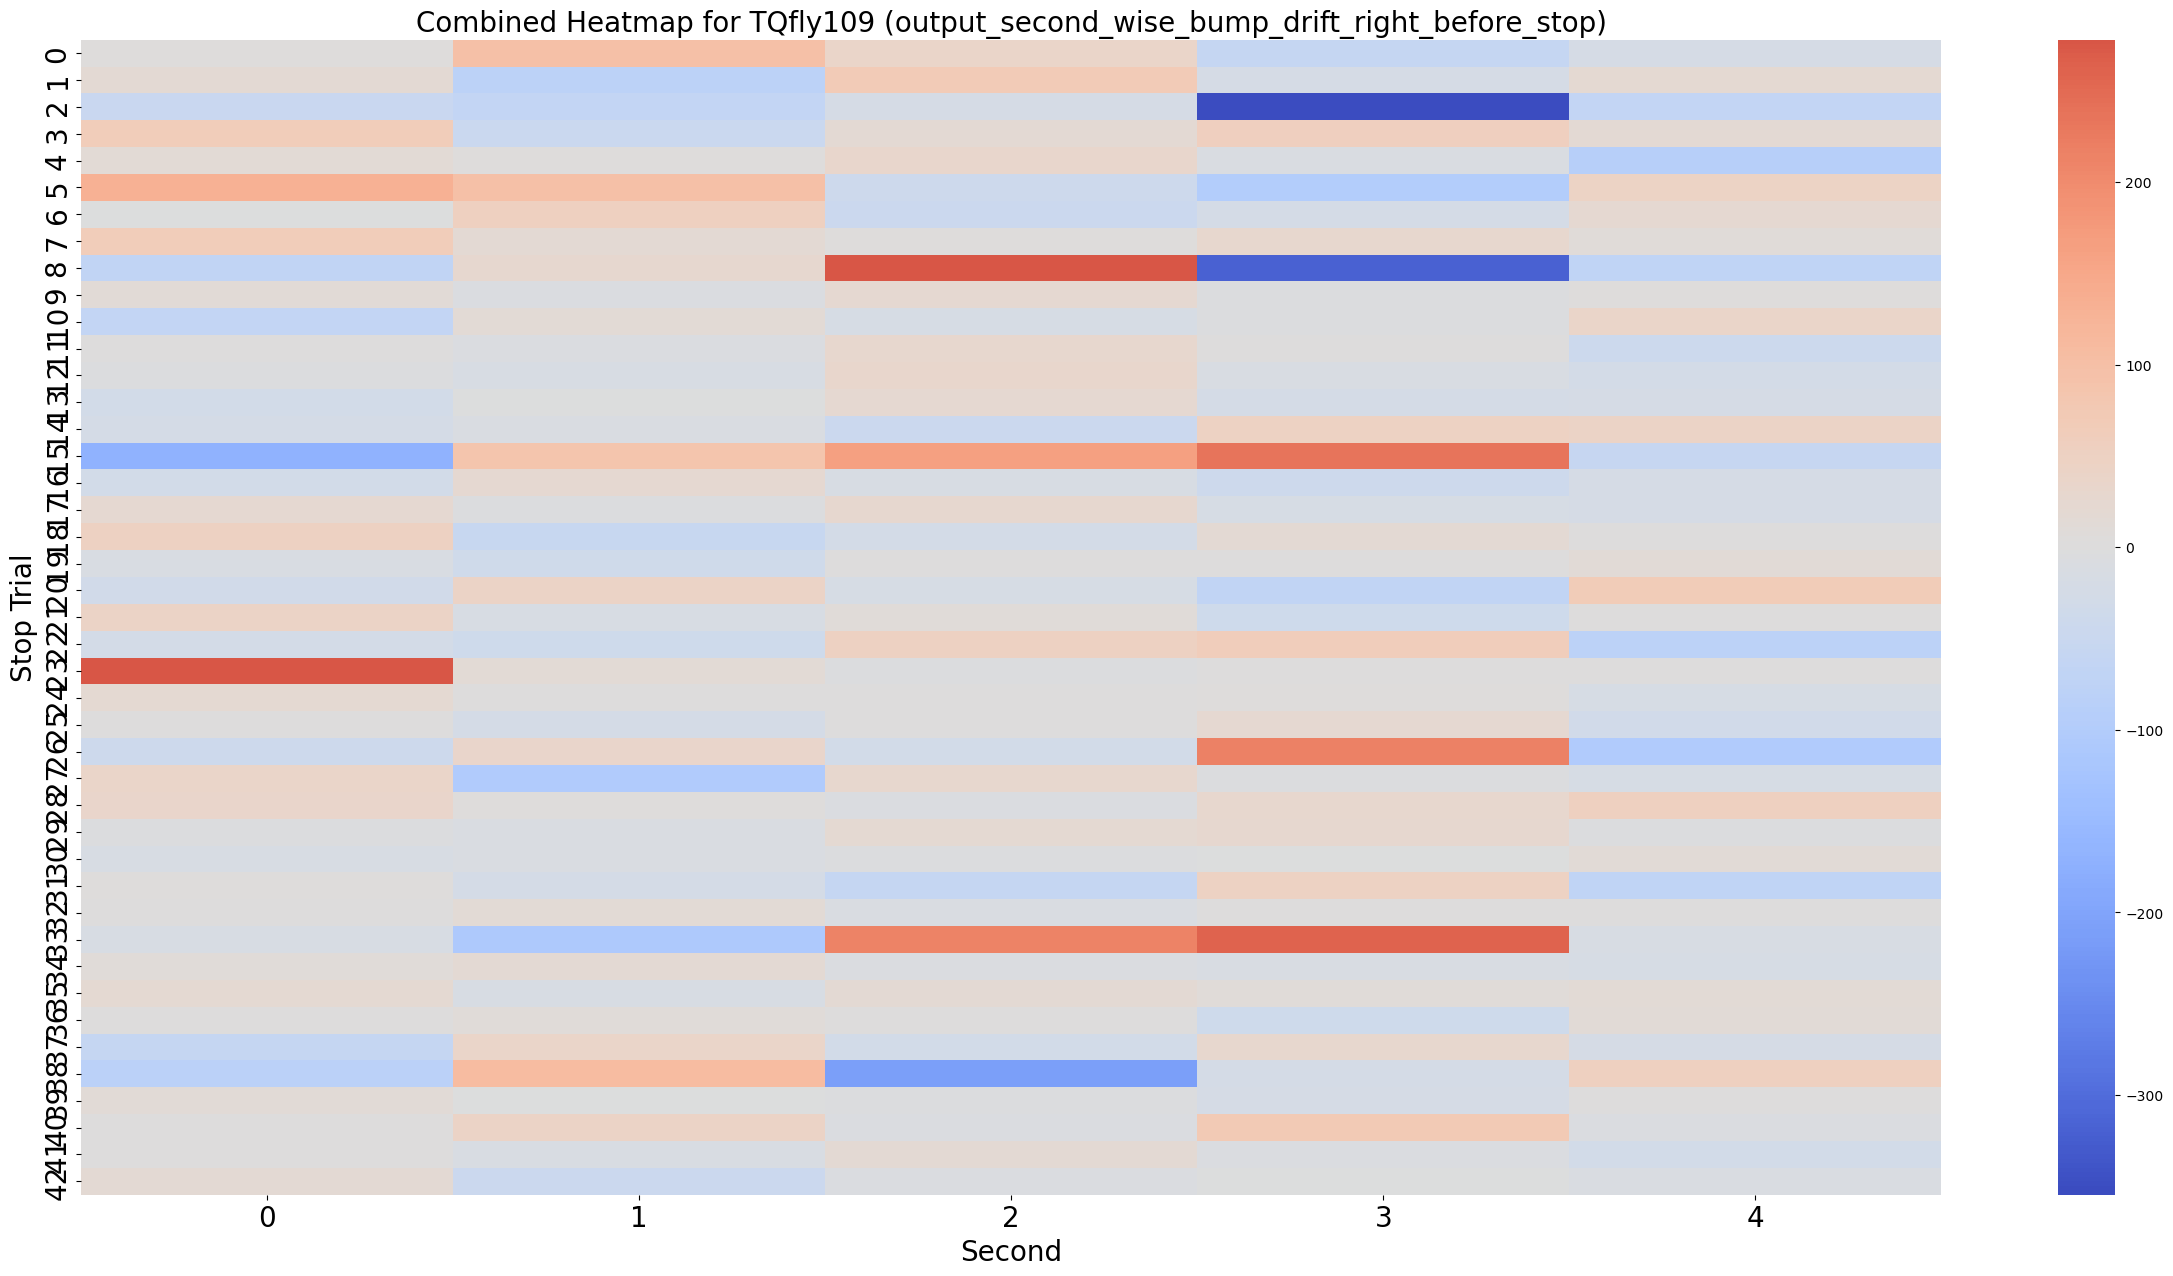

Processing experiment: TQfly116


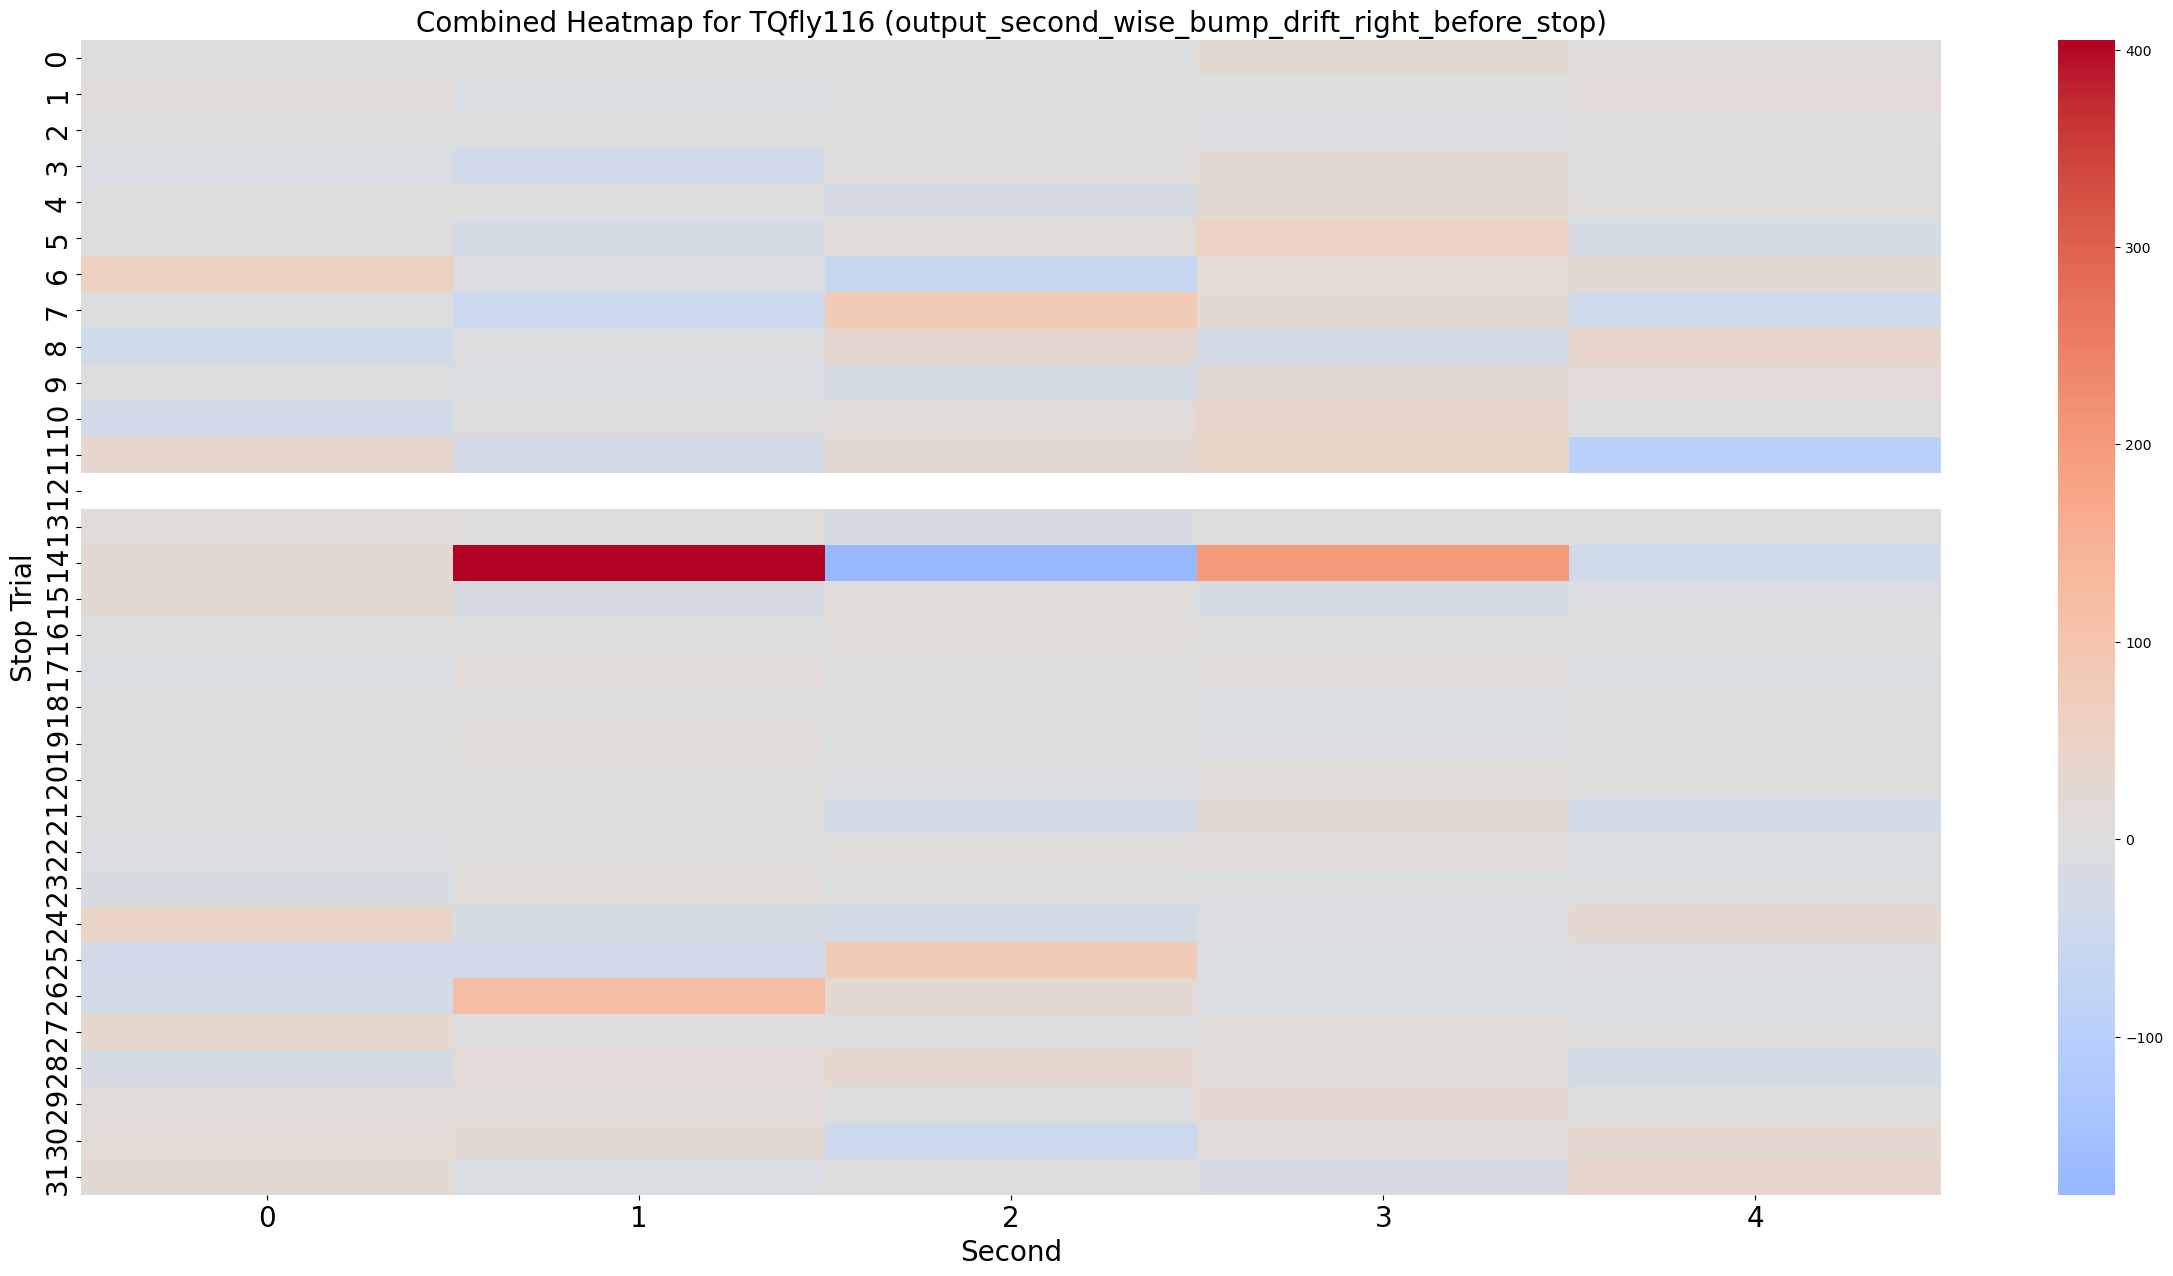

Processing experiment: TQfly113


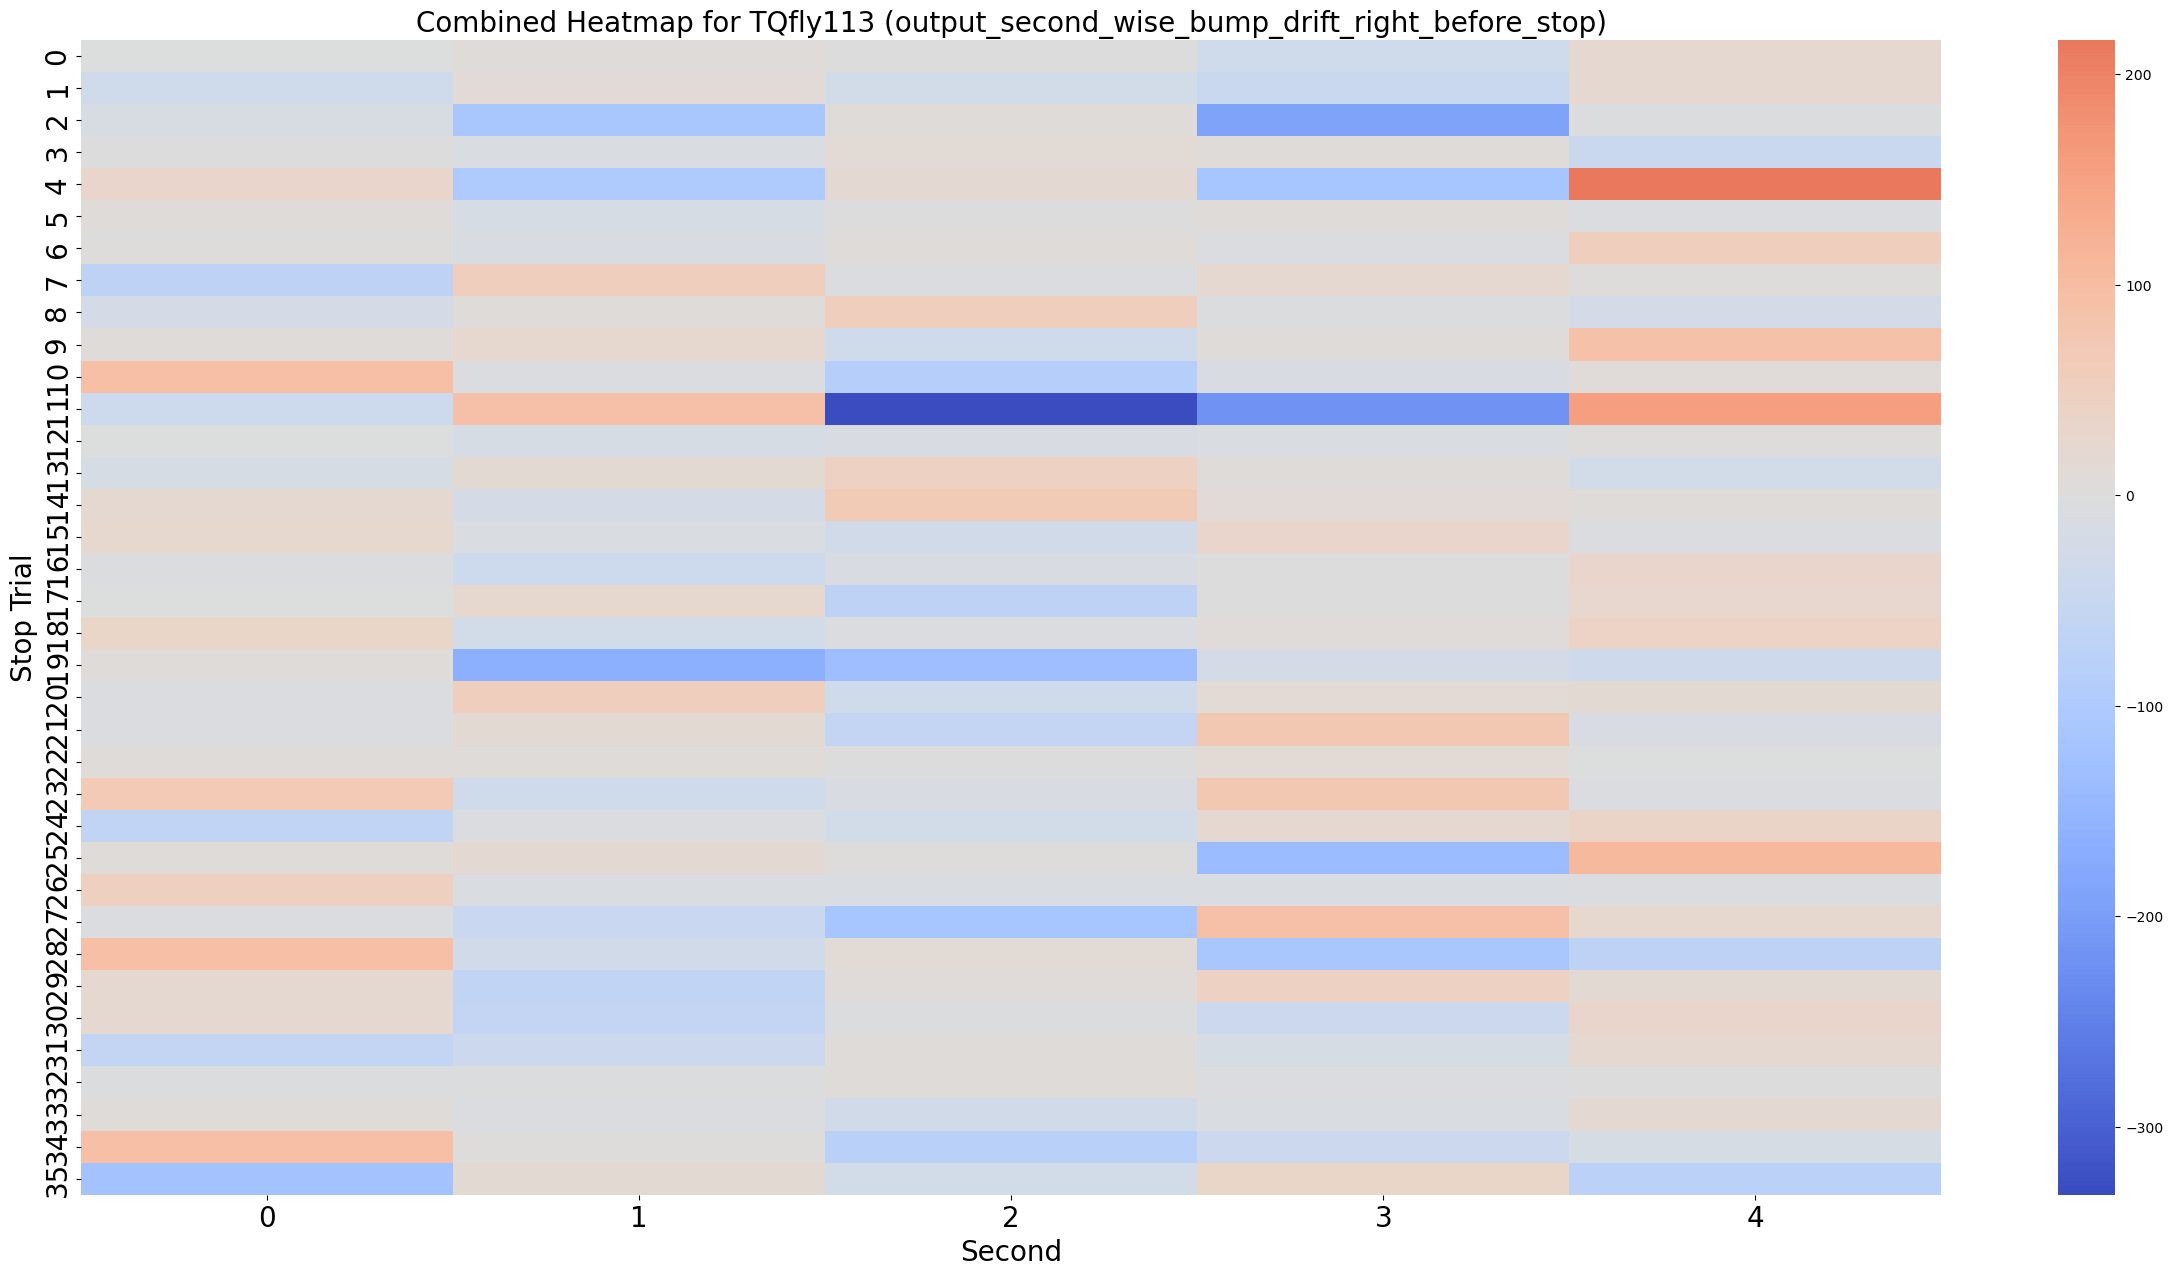

Processing experiment: TQfly111


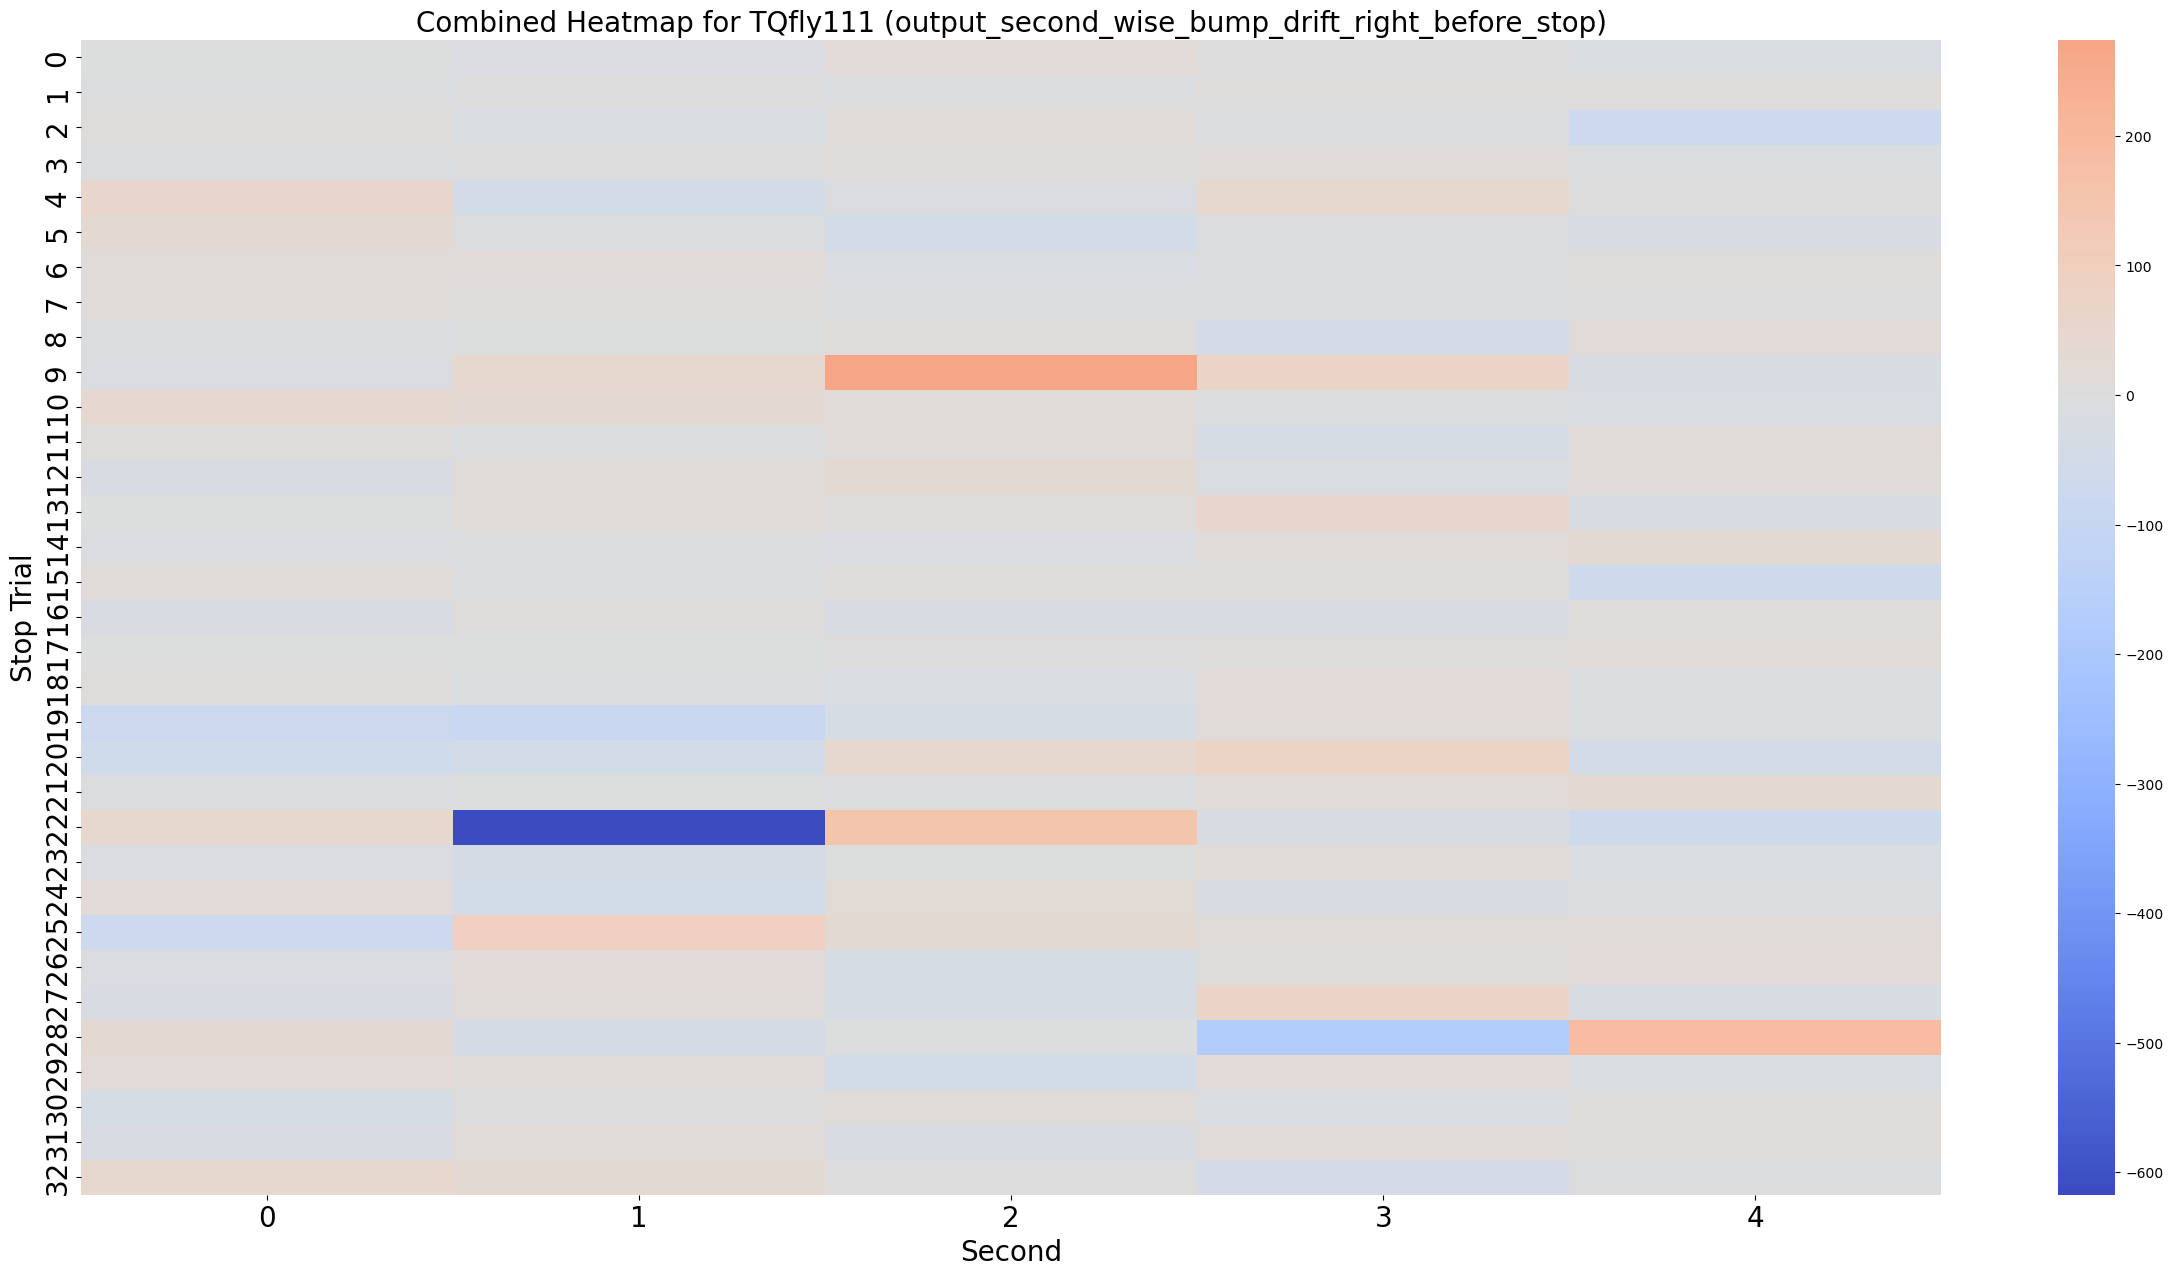

Processing experiment: TQfly118


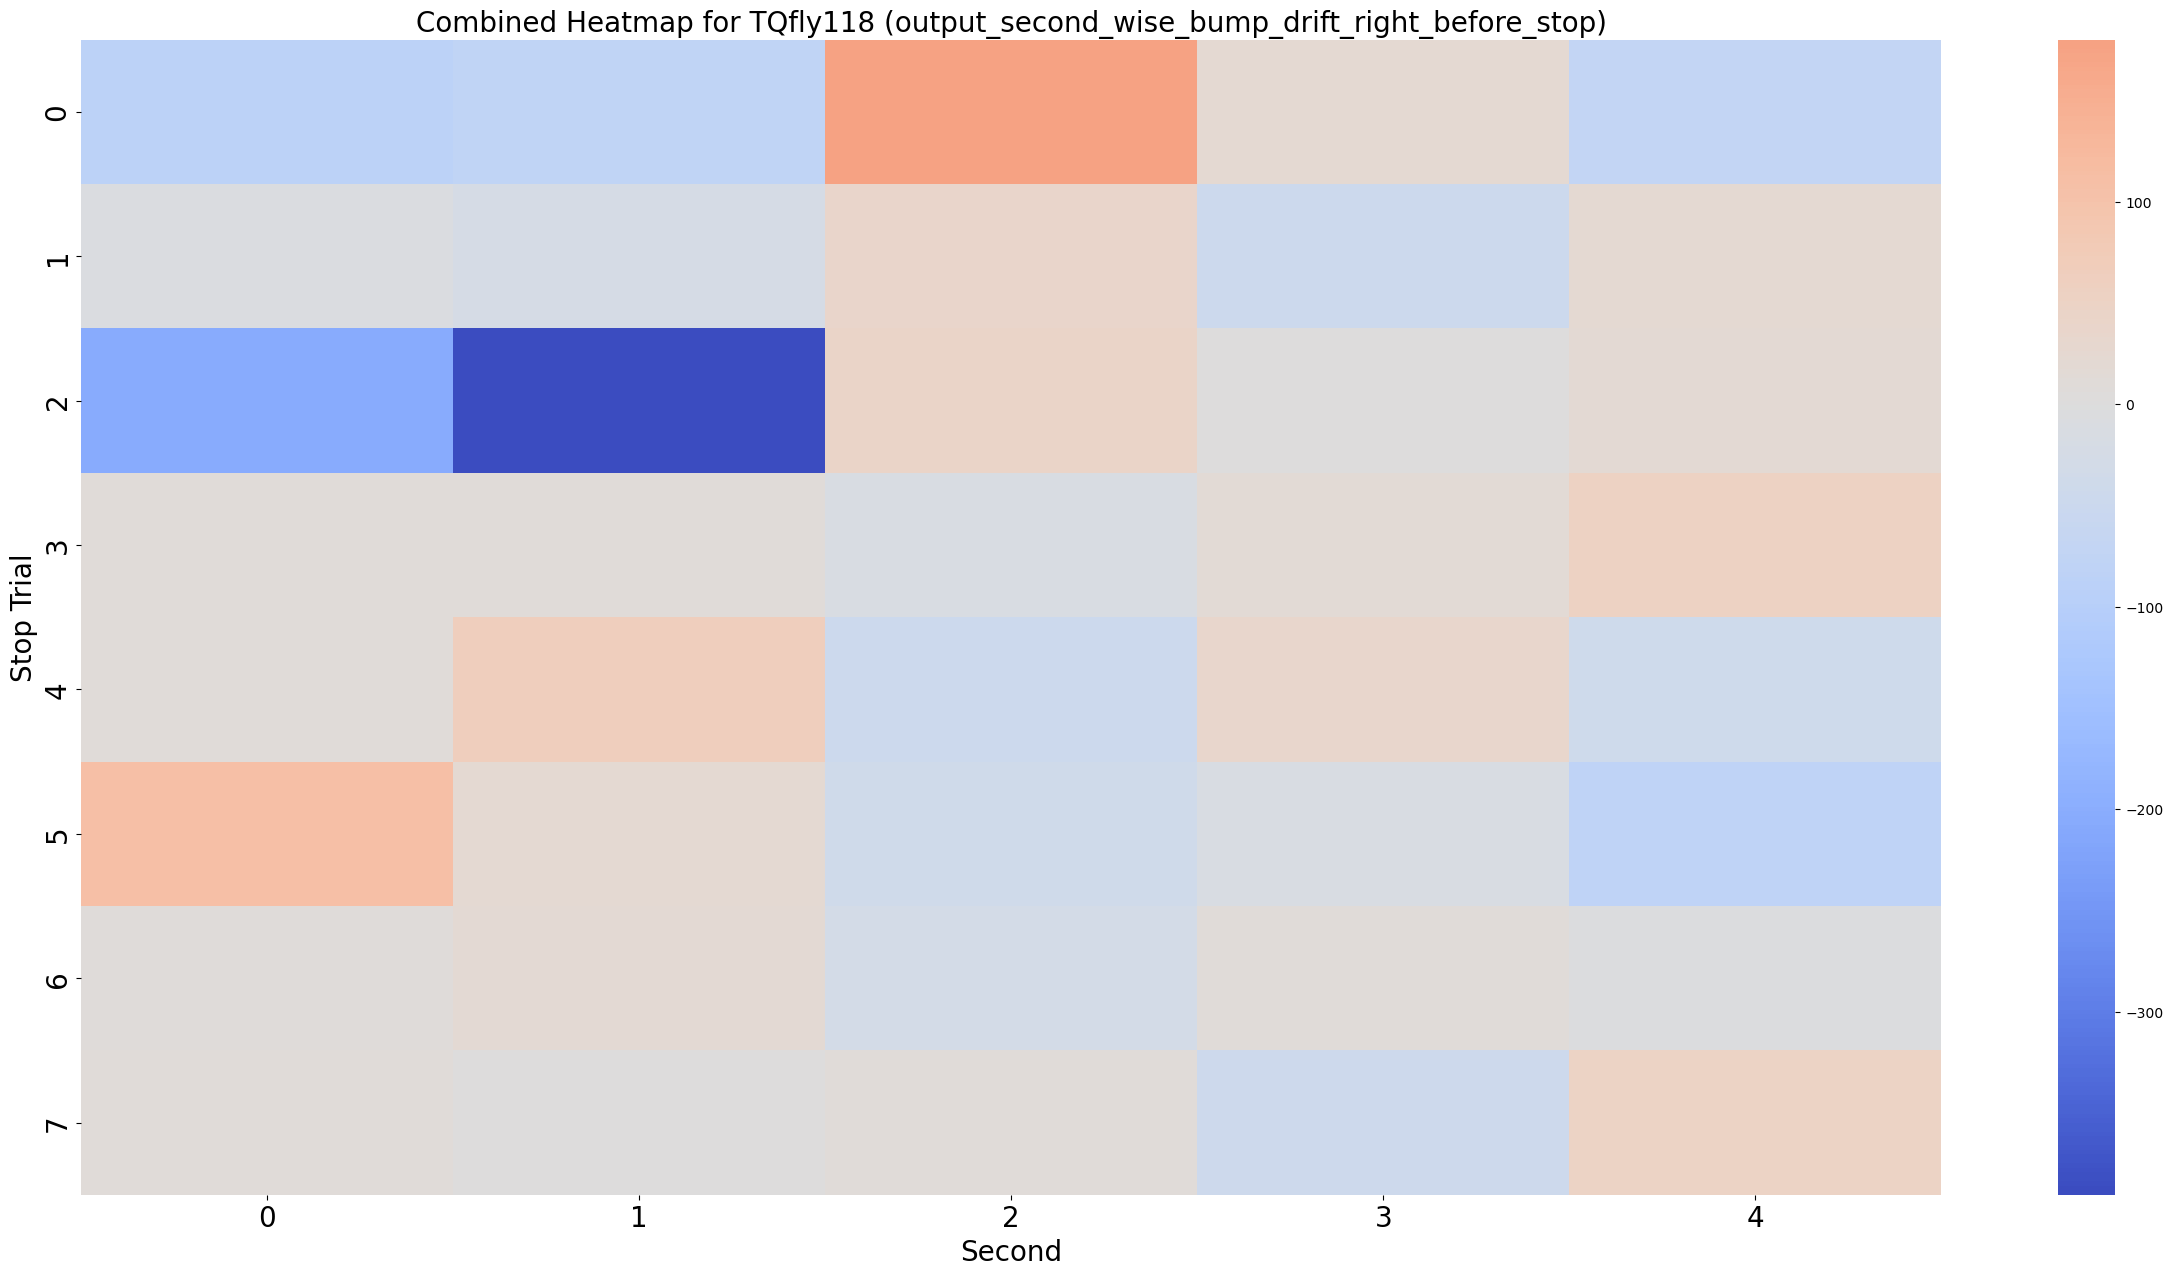

Processing experiment: TQfly105


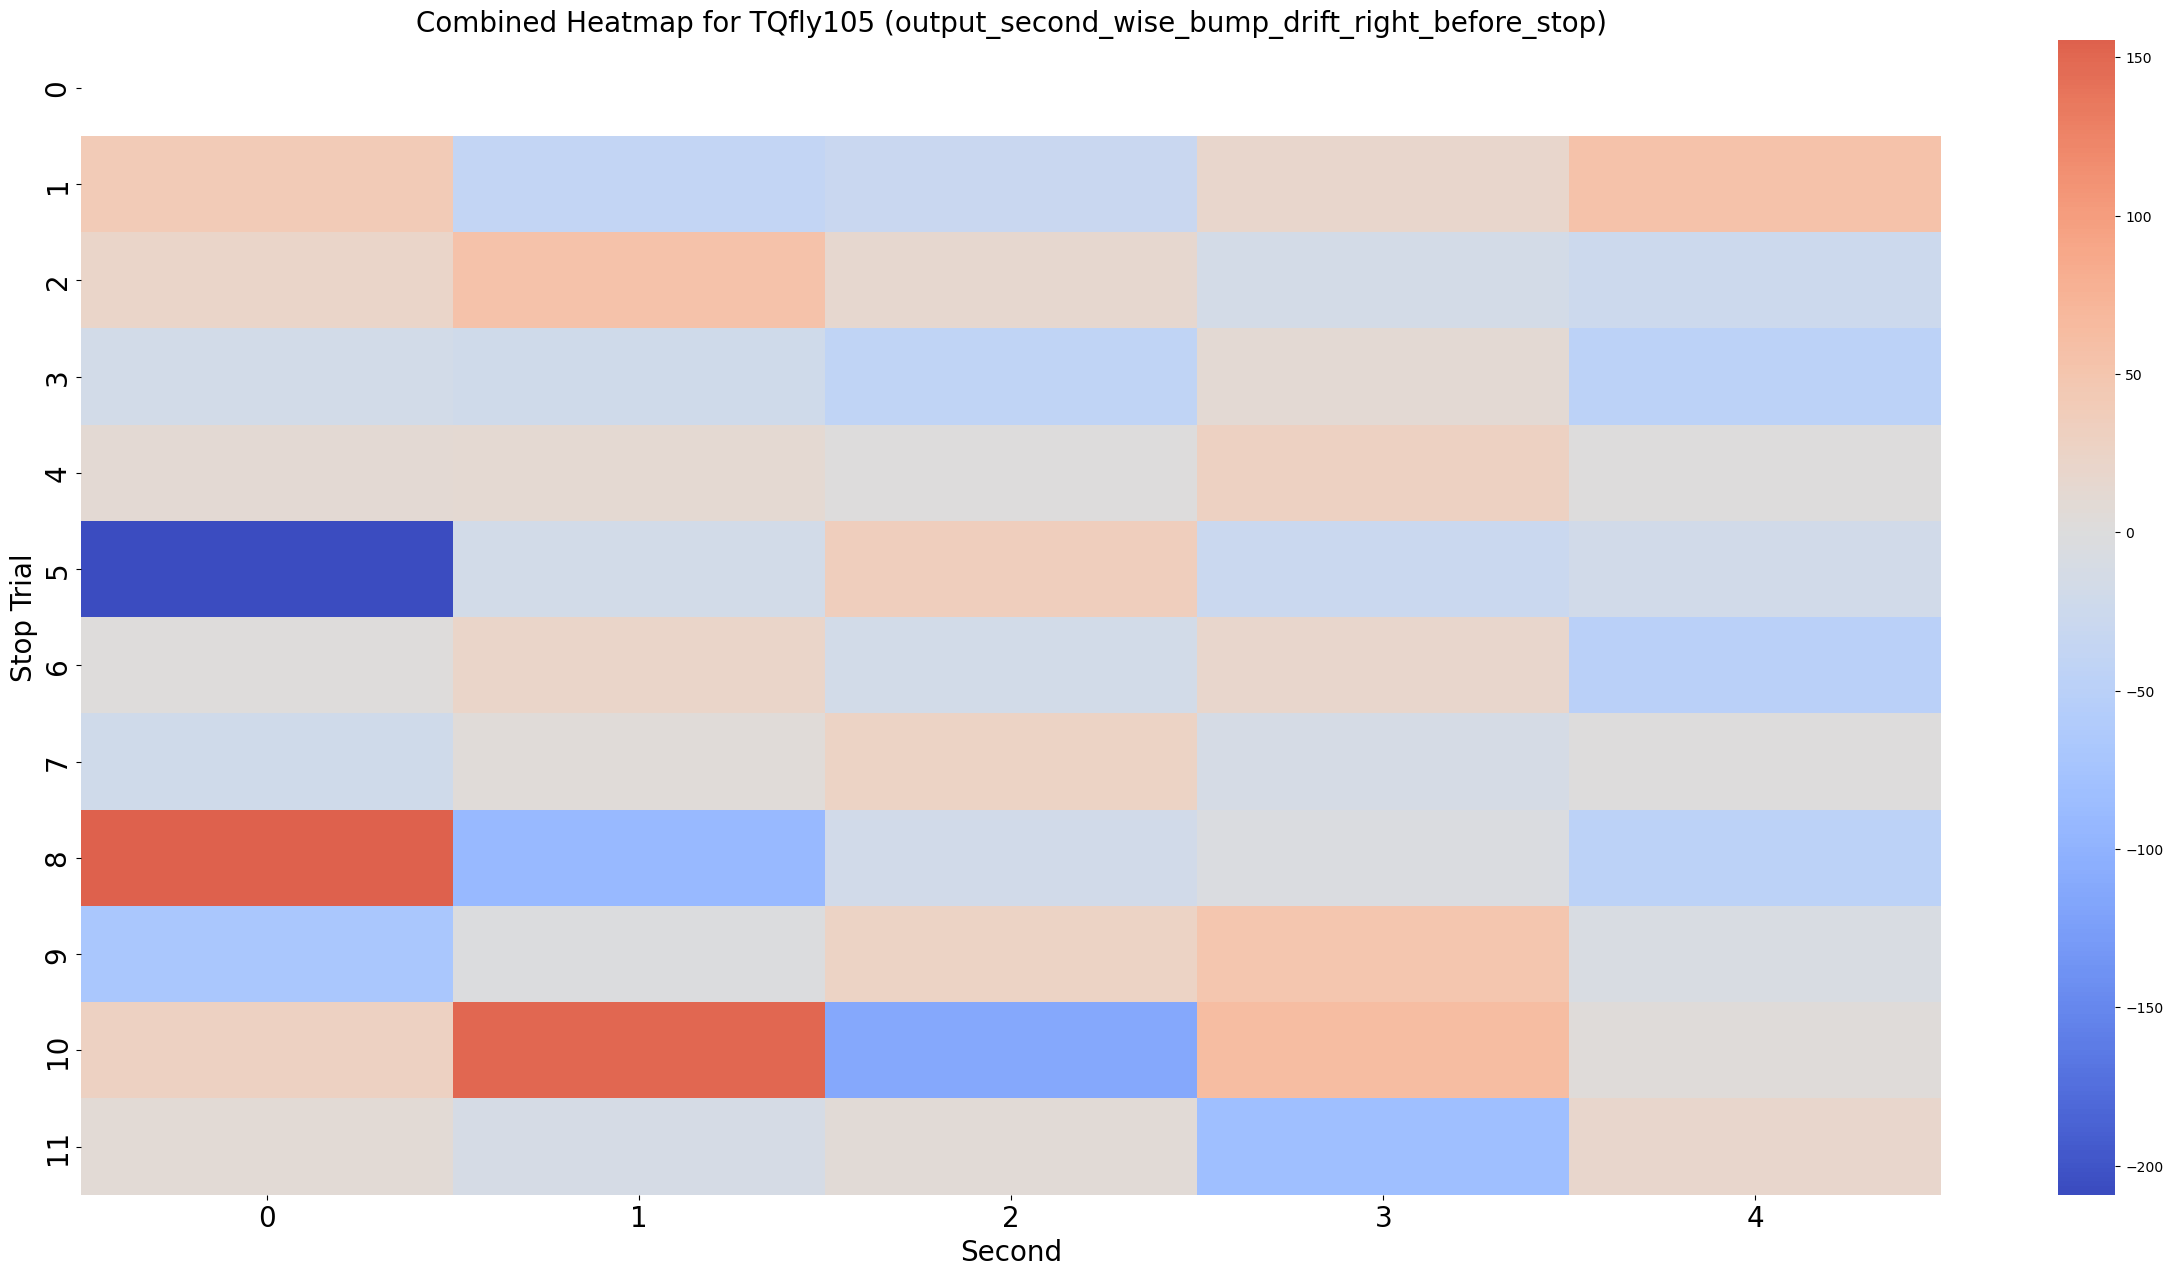

Processing experiment: TQfly110


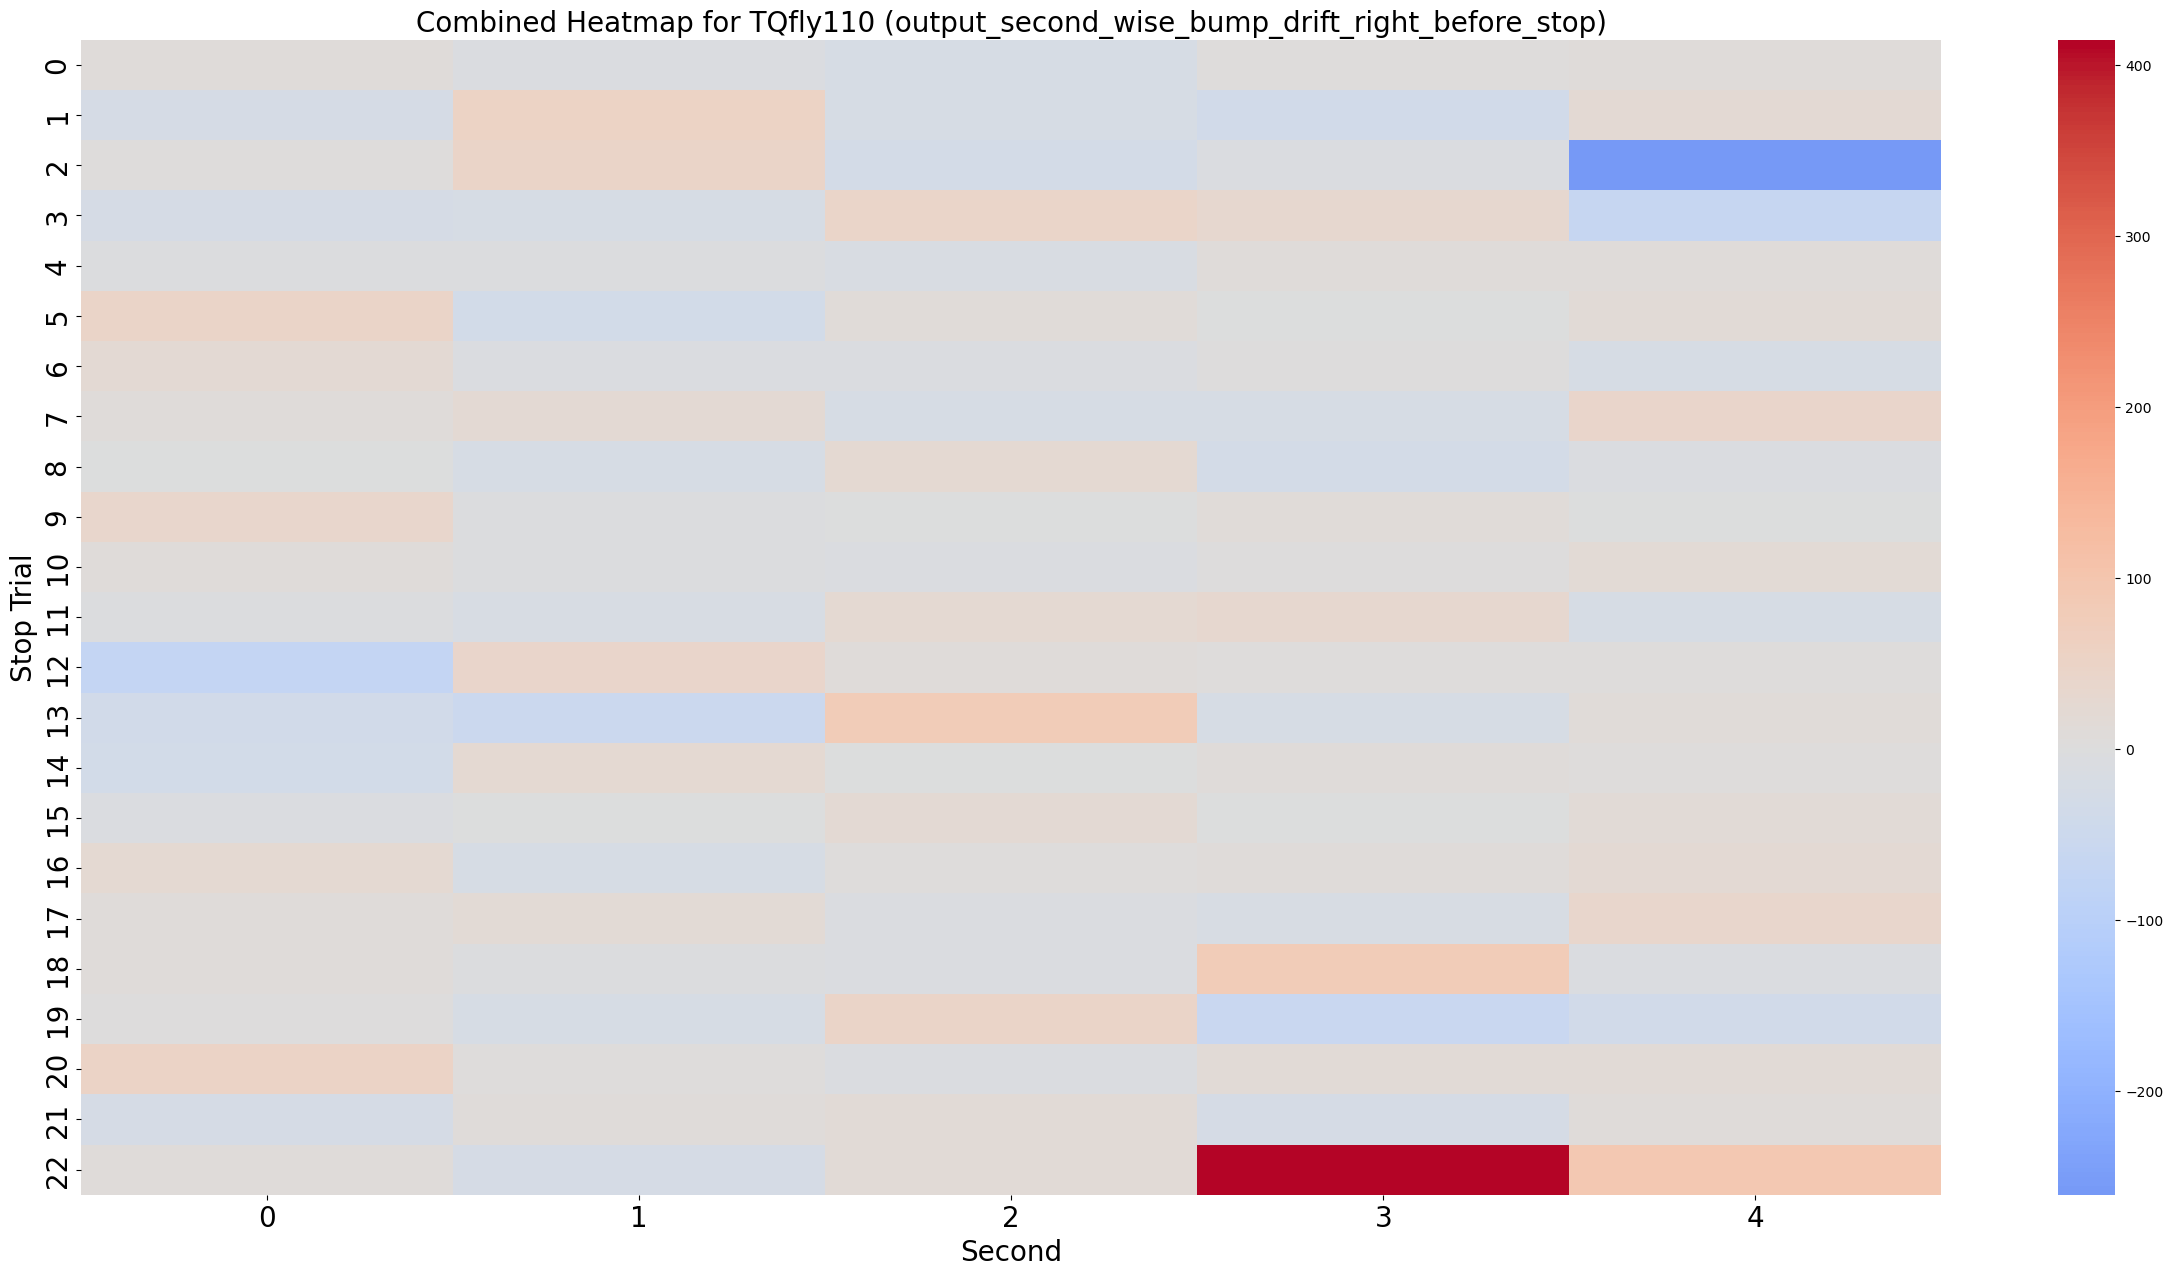

Done plotting heatmaps for output_second_wise_bump_drift_right_before_stop.


In [9]:
plot_stop_drift_rate_heatmaps(data_all,"output_second_wise_bump_drift_right_before_stop")

In [51]:
def analyze_bump_drift_correlation(
    data_before,
    data_during,
    strength_filter_data=None,
    strength_threshold=None,
    use_robust_regression=False,
    split_by_turn_direction=False,
    min_trial_duration=0,
    during_stop_window=(0, 100),
    angular_speed_threshold=None,
    save_as_svg='no'  # <- NEW PARAMETER
):
    before_means = []
    during_means = []
    turn_directions = []

    total_chunks = 0
    valid_chunks = 0
    filtered_out_chunks = 0

    for experiment in data_before:
        if experiment not in data_during:
            continue

        trials_before = data_before[experiment]
        trials_during = data_during[experiment]
        strength_trials = strength_filter_data.get(experiment) if strength_filter_data else None

        for trial_idx, (trial_before, trial_during) in enumerate(zip(trials_before, trials_during)):
            n_stops = min(len(trial_before), len(trial_during))
            strength_trial = strength_trials[trial_idx] if strength_trials else None

            for stop_idx in range(n_stops):
                total_chunks += 1

                drift_before = np.asarray(trial_before[stop_idx], dtype=float)
                drift_during = np.asarray(trial_during[stop_idx], dtype=float)

                if len(drift_during) < min_trial_duration:
                    filtered_out_chunks += 1
                    continue

                if angular_speed_threshold is not None:
                    mean_ang_speed = np.nanmean(np.abs(drift_before))
                    if np.abs(mean_ang_speed) < angular_speed_threshold:
                        filtered_out_chunks += 1
                        continue

                if during_stop_window == "all":
                    drift_during_slice = drift_during
                elif during_stop_window == "first 5":
                    drift_during_slice = drift_during[:5]
                elif during_stop_window == "last 5":
                    drift_during_slice = drift_during[-5:]
                elif isinstance(during_stop_window, int):
                    drift_during_slice = drift_during[:during_stop_window]
                elif isinstance(during_stop_window, tuple):
                    if len(drift_during) < during_stop_window[1]:
                        filtered_out_chunks += 1
                        continue
                    drift_during_slice = drift_during[during_stop_window[0]:during_stop_window[1]]
                else:
                    raise ValueError("Invalid during_stop_window input")

                if strength_trial and strength_threshold is not None:
                    strength = np.asarray(strength_trial[stop_idx], dtype=float)
                    if during_stop_window == "all":
                        strength_slice = strength
                    elif during_stop_window == "first 5":
                        strength_slice = strength[:5]
                    elif during_stop_window == "last 5":
                        strength_slice = strength[-5:]
                    elif isinstance(during_stop_window, int):
                        strength_slice = strength[:during_stop_window]
                    elif isinstance(during_stop_window, tuple):
                        strength_slice = strength[during_stop_window[0]:during_stop_window[1]]

                    valid_mask = strength_slice >= strength_threshold
                    if valid_mask.sum() == 0 or len(valid_mask) != len(drift_during_slice):
                        filtered_out_chunks += 1
                        continue
                    drift_during_slice = drift_during_slice[valid_mask]

                mean_before = np.nanmean(drift_before)
                mean_during = np.nanmean(drift_during_slice)

                if np.isnan(mean_before) or np.isnan(mean_during) or \
                   np.isinf(mean_before) or np.isinf(mean_during):
                    filtered_out_chunks += 1
                    continue

                before_means.append(mean_before)
                during_means.append(mean_during)
                turn_directions.append('left' if mean_before < 0 else 'right')
                valid_chunks += 1

    print(f"\nTotal stop chunks considered: {total_chunks}")
    print(f"Valid chunks used in correlation: {valid_chunks}")
    print(f"Filtered out chunks: {filtered_out_chunks}")

    df_results = pd.DataFrame({
        'Mean Drift Before Stop': before_means,
        'Mean Drift During Stop': during_means,
        'Turn Direction': turn_directions
    }).dropna()

    def annotate_stats(ax, x, y, cor, p, slope, color):
        ax.annotate(
            f"$r$ = {cor:.2f}\n$p$ = {p:.3f}\nSlope = {slope:.2f}",
            xy=(x, y),
            xycoords='axes fraction',
            color=color,
            fontsize=10,
            ha='left'
        )

    fig, ax = plt.subplots(figsize=(8, 6))

    if split_by_turn_direction:
        colors = {'left': 'tab:blue', 'right': 'tab:orange'}
        stats_dict = {}
        all_vals = []

        for direction, corner in zip(['left', 'right'], [(0.05, 0.05), (0.05, 0.85)]):
            subset = df_results[df_results['Turn Direction'] == direction].copy()
            subset['Abs Mean Drift Before Stop'] = np.abs(subset['Mean Drift Before Stop'])

            if len(subset) < 2:
                stats_dict[direction] = (np.nan, np.nan, np.nan)
                continue

            cor, p = pearsonr(subset['Abs Mean Drift Before Stop'], subset['Mean Drift During Stop'])

            if use_robust_regression:
                model = HuberRegressor().fit(
                    subset[['Abs Mean Drift Before Stop']],
                    subset['Mean Drift During Stop']
                )
                slope = model.coef_[0]
                intercept = model.intercept_
            else:
                slope, intercept, _, _, _ = linregress(
                    subset['Abs Mean Drift Before Stop'], subset['Mean Drift During Stop']
                )

            stats_dict[direction] = (cor, p, slope)

            ax.scatter(subset['Abs Mean Drift Before Stop'], subset['Mean Drift During Stop'],
                       alpha=0.7, edgecolor='k', label=f"{direction.capitalize()} Turn", color=colors[direction])

            x_vals = np.linspace(subset['Abs Mean Drift Before Stop'].min(),
                                 subset['Abs Mean Drift Before Stop'].max(), 100)
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, '--', color=colors[direction], label=f"{direction.capitalize()} Fit")

            annotate_stats(ax, *corner, cor, p, slope, colors[direction])
            all_vals += subset['Abs Mean Drift Before Stop'].tolist() + subset['Mean Drift During Stop'].tolist()

        ax.axhline(0, color='gray', linestyle='dashed')
        ax.axvline(0, color='gray', linestyle='dashed')
        ax.set_xlabel("Absolute Mean Drift Before Stop (deg/s)")
        ax.set_ylabel("Mean Drift During Stop (deg/s)")
        ax.set_title("Bump Drift Correlation by Turn Direction\nLeft Turns in Lower Half, Right Turns in Upper Half")
        ax.grid(True)

        max_val = max(np.abs(all_vals)) * 1.1 if all_vals else 1
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    else:
        correlation_value, p_value = pearsonr(df_results['Mean Drift Before Stop'], df_results['Mean Drift During Stop'])

        if use_robust_regression:
            model = HuberRegressor().fit(
                df_results[['Mean Drift Before Stop']],
                df_results['Mean Drift During Stop']
            )
            slope = model.coef_[0]
            intercept = model.intercept_
        else:
            slope, intercept, _, _, _ = linregress(
                df_results['Mean Drift Before Stop'], df_results['Mean Drift During Stop']
            )

        ax.scatter(df_results['Mean Drift Before Stop'], df_results['Mean Drift During Stop'],
                   alpha=0.7, edgecolor='k', label='Stop Chunks')

        x_vals = np.array(ax.get_xlim())
        y_vals = intercept + slope * x_vals
        ax.plot(x_vals, y_vals, '--r', label="Fit")

        annotate_stats(ax, 0.05, 0.85, correlation_value, p_value, slope, 'red')

        ax.set_xlabel("Mean Angular Velocity Before Stop (deg/s)")
        ax.set_ylabel("Mean Drift Rate During Stop (deg/s)")
        ax.set_title("Bump Drift Correlation")
        ax.axhline(0, color='gray', linestyle='dashed')
        ax.axvline(0, color='gray', linestyle='dashed')
        ax.grid(True)

        all_vals = before_means + during_means
        max_val = max(np.abs(all_vals)) * 1.1 if all_vals else 1
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()

    if save_as_svg != 'no':
        plt.savefig(save_as_svg, format='svg')
        print(f"Figure saved as: {save_as_svg}")

    plt.show()

    if split_by_turn_direction:
        return df_results, stats_dict['left'], stats_dict['right'], None
    else:
        return df_results, correlation_value, p_value, slope


Total stop chunks considered: 224
Valid chunks used in correlation: 14
Filtered out chunks: 210


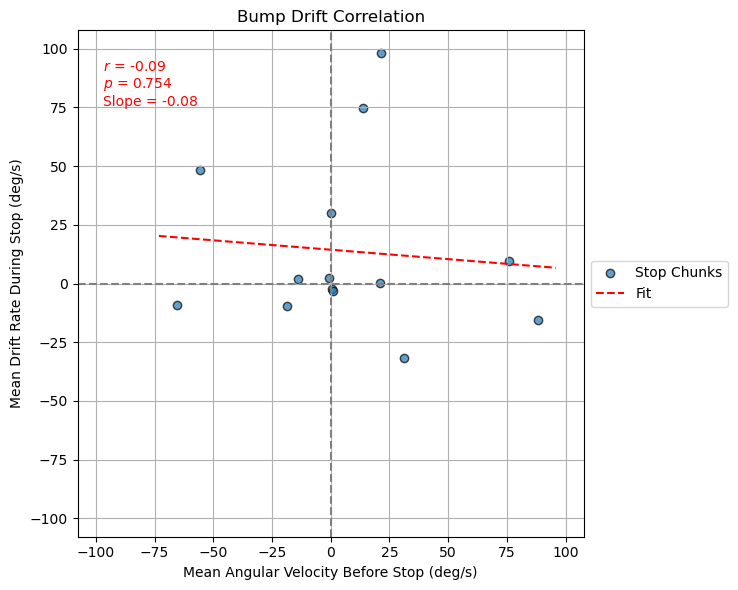

In [63]:
df, stats_left, stats_right, _ = analyze_bump_drift_correlation(
    data_all["output_second_wise_bump_drift_right_before_stop_thresholded"],
    data_all["output_second_wise_bump_drift_at_stop_thresholded"],
    strength_filter_data=data_all["output_second_wise_PVA_strength"],
    strength_threshold=0,
    use_robust_regression=False,
    split_by_turn_direction=False,
    min_trial_duration= 20,
    during_stop_window= (10,20),
    angular_speed_threshold=25,
    save_as_svg='no'
)

In [37]:
def find_nan_chunks(data_before, data_during):
    print("🔍 Scanning for NaNs in stop chunks...\n")
    nan_report = []

    for experiment in data_before.keys():
        if experiment not in data_during:
            continue

        trials_before = data_before[experiment]
        trials_during = data_during[experiment]

        for trial_idx, (before_trial, during_trial) in enumerate(zip(trials_before, trials_during)):
            for stop_idx, (before_chunk, during_chunk) in enumerate(zip(before_trial, during_trial)):
                before_chunk = np.array(before_chunk, dtype=float)
                during_chunk = np.array(during_chunk, dtype=float)

                has_nan_before = np.isnan(before_chunk).any()
                has_nan_during = np.isnan(during_chunk).any()

                if has_nan_before or has_nan_during:
                    print(f"⚠️ NaN detected — Experiment: {experiment}, Trial: {trial_idx}, Stop Chunk: {stop_idx}")
                    if has_nan_before:
                        print(f"   → NaN in 'before' chunk: {before_chunk}")
                    if has_nan_during:
                        print(f"   → NaN in 'during' chunk: {during_chunk}")
                    nan_report.append((experiment, trial_idx, stop_idx))

    if not nan_report:
        print("✅ No NaNs found in any chunk!")

    return nan_report

In [38]:
nan_chunks = find_nan_chunks(
    data_all["output_second_wise_bump_drift_right_before_stop"],
    data_all["output_second_wise_bump_drift"]
)

🔍 Scanning for NaNs in stop chunks...

⚠️ NaN detected — Experiment: TQfly047, Trial: 0, Stop Chunk: 0
   → NaN in 'before' chunk: [nan]
⚠️ NaN detected — Experiment: TQfly047, Trial: 1, Stop Chunk: 0
   → NaN in 'before' chunk: [nan]
⚠️ NaN detected — Experiment: TQfly047, Trial: 3, Stop Chunk: 0
   → NaN in 'before' chunk: [nan]
⚠️ NaN detected — Experiment: TQfly049, Trial: 1, Stop Chunk: 0
   → NaN in 'before' chunk: [nan]


In [17]:
consistency_values = []

# Loop through each experiment's combined data
for key, trials in data_all['output_second_wise_bump_drift'].items():
    combined_data = []
    
    for trial in trials:
        trial_data = []
        for array in trial:
            if len(array) > 0:
                trial_data.append(array)
        
        if len(trial_data) > 0:
            max_length = max(len(arr) for arr in trial_data)
            padded_data = np.array([np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan) for arr in trial_data])
            combined_data.extend(padded_data)
    
    # Convert to a DataFrame
    df = pd.DataFrame(combined_data)
    
    # Calculate the difference between consecutive 0.5-second intervals
    for i in range(0, df.shape[1] - 2, 2):  # Step by 2 to move through each second
        first_half = df.iloc[:, i]
        second_half = df.iloc[:, i + 1]
        
        # Calculate absolute difference and average
        difference = np.abs(first_half - second_half)
        avg_difference = np.nanmean(difference)
        
        consistency_values.append(avg_difference)

# Overall consistency measure
overall_consistency = np.mean(consistency_values)

print(f'Overall consistency across all experiments: {overall_consistency}')



Overall consistency across all experiments: 34.88365536211706


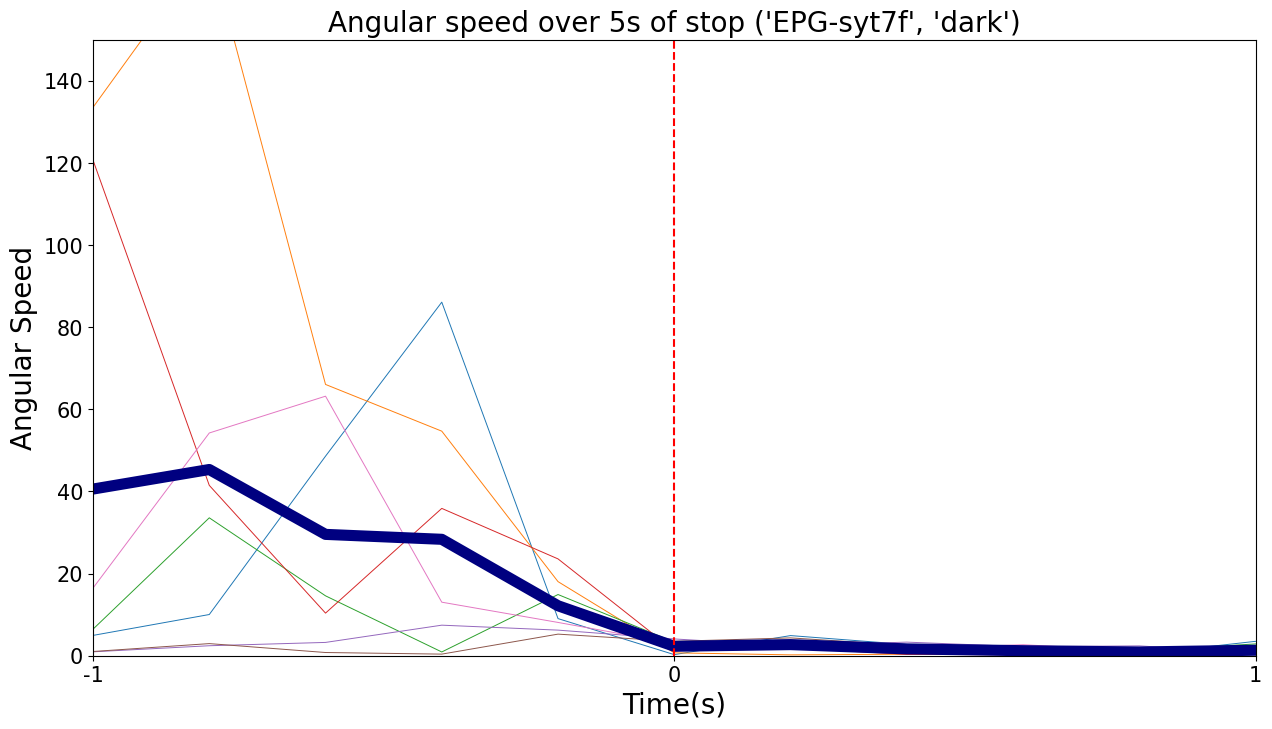

In [13]:
time_array_decay = np.arange(len(data_all['output_Angular_Speed_pooled'].mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(data_all['output_Angular_Speed_pooled'].columns)):
    plt.plot(time_array_decay,data_all['output_Angular_Speed_pooled'][i],linewidth = 0.7)
plt.plot(time_array_decay,data_all['output_Angular_Speed_pooled'].mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,2)
plt.ylim(0,150)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Angular Speed', fontsize=20)
plt.title(f"Angular speed over {bump_amplitude_stopping_duration}s of stop {celltype, trial_condition}",fontsize =20)
plt.show()


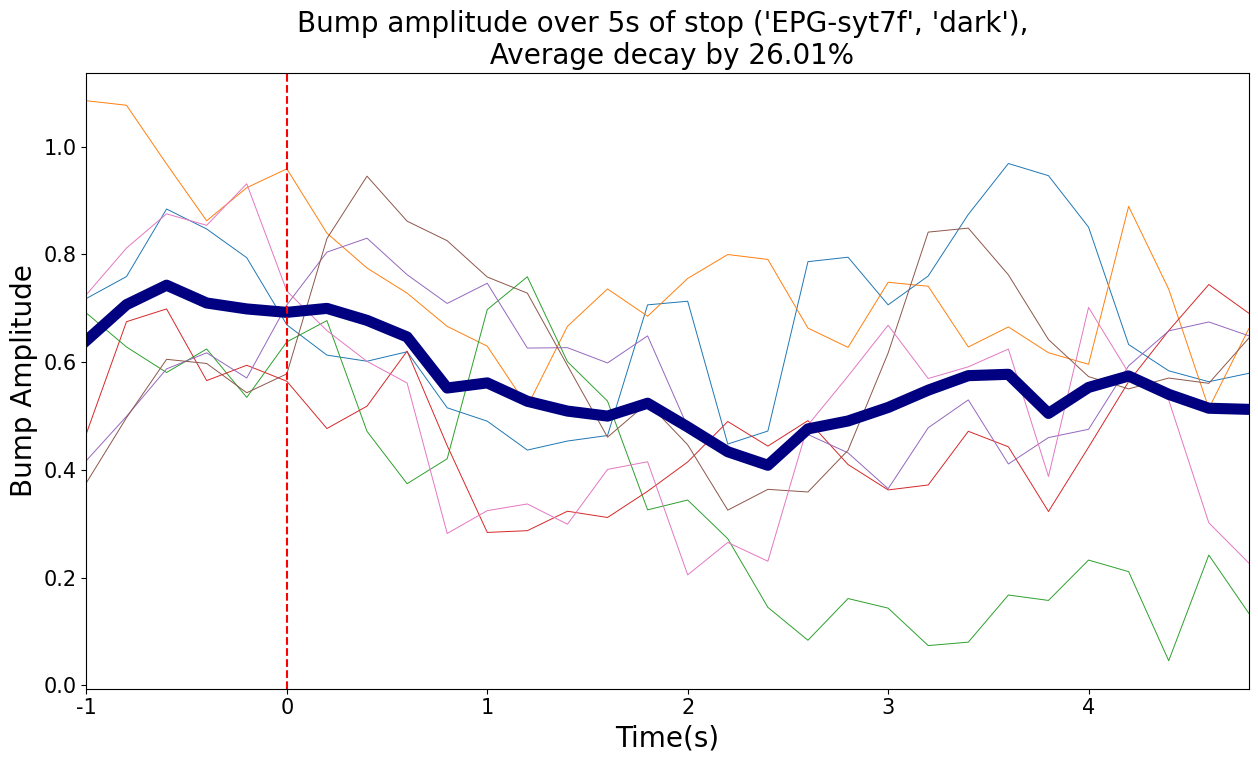

In [16]:
plot_stopping_period_signal(data_all['output_bump_amplitude_V3_pooled'],stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

In [19]:
if dual_imaging == 1:
    plot_stopping_period_signal(data_all['output_bump_amplitude_V4_pooled_red'],stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

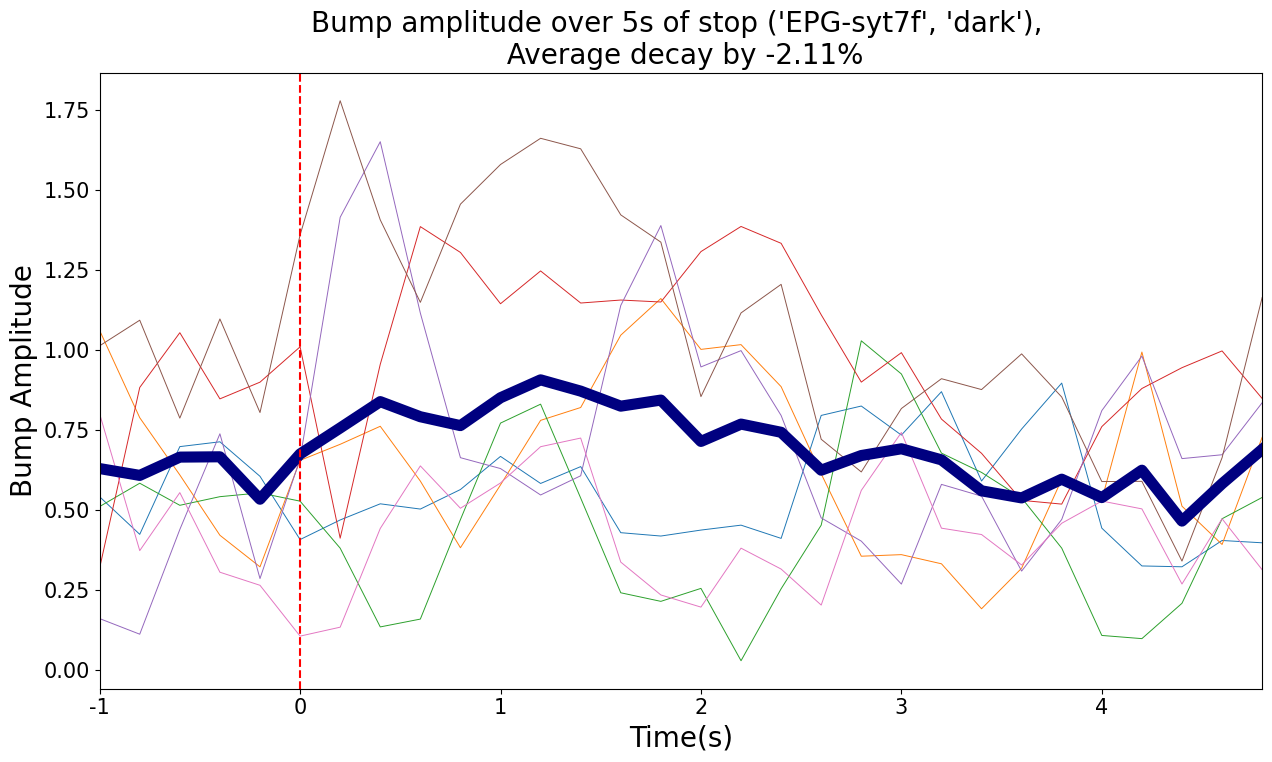

In [17]:
plot_stopping_period_signal(data_all['output_PVA_strength_pooled'] ,stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

In [22]:
fly_list = np.array(list(set(data_all['output_flytrial'])))

In [23]:
Bump_amp_V3_stable = pd.DataFrame()
Bump_amp_V3_unstable = pd.DataFrame()
for i in range(len(data_all['output_stable_PVA_index_pooled'])):
    if data_all['output_stable_PVA_index_pooled'][i] == 0:
        if i == 0:
            Bump_amp_V3_unstable = data_all['output_bump_amplitude_V3_pooled'][i]
        else:
            Bump_amp_V3_unstable = pd.concat([Bump_amp_V3_unstable,data_all['output_bump_amplitude_V3_pooled'][i]],ignore_index=True, axis =1)
    else:
        if i == 0:
            Bump_amp_V3_stable =data_all['output_bump_amplitude_V3_pooled'][i]
        else:
            Bump_amp_V3_stable = pd.concat([Bump_amp_V3_stable,data_all['output_bump_amplitude_V3_pooled'][i]],ignore_index=True, axis =1)          

In [14]:
output_bump_amplitude_V4_pooled_average_by_fly = calculate_stop_signal_in_separate_fly(output_bump_amplitude_V4_pooled,flylist = fly_list,trial_list=output_flytrial,stability_list=output_stable_PVA_index_pooled, separate_stableY_N=0)

NameError: name 'output_bump_amplitude_V4_pooled' is not defined

In [16]:
#output_bump_amplitude_V3_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V3_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V4_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V4_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)

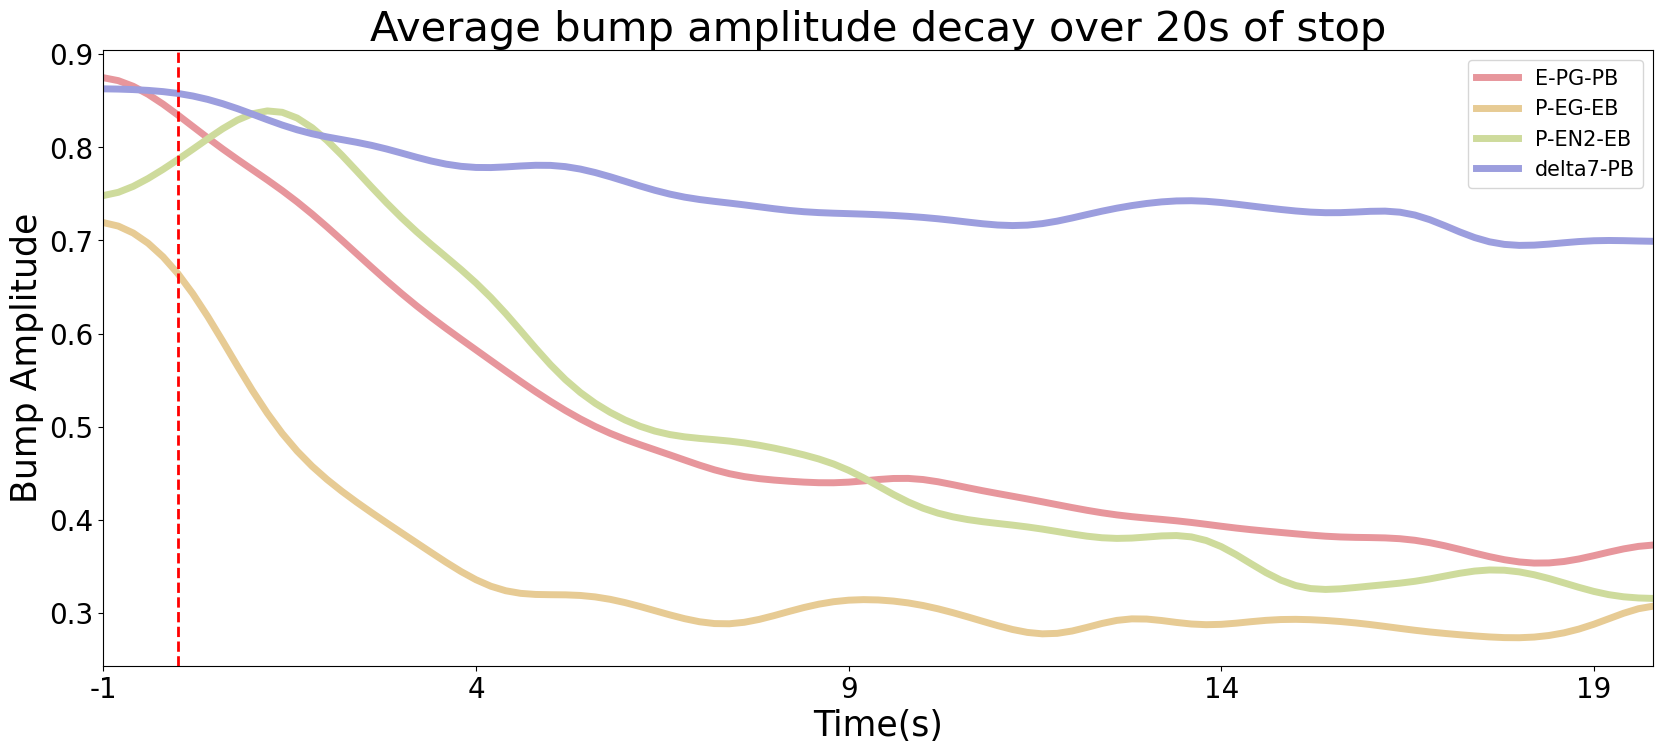

In [56]:
pooled_decay_df= pd.read_csv('/home/tianhaoqiu/Desktop/Average_Bump_amplitude_V3_decay_20s_syt7f_only.csv')
#new_column_names = [0,1,2,3,4,5,6]
new_column_names = [0,1,2,3]
pooled_decay_df.columns = new_column_names
palette = sns.color_palette("tab20b_r", len(pooled_decay_df.columns))

a =plt.figure(figsize=(20, 8))

for i in range(len(pooled_decay_df.columns)):
    if i >= 5:
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_df[i], sigma=3), linewidth=5, color=palette[i])
    else:
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_df[i],sigma=3), linewidth=5, color=palette[i])


# Add custom labels and legend
custom_labels = ['E-PG-PB',  'P-EG-EB', 'P-EN2-EB', 'delta7-PB']
#custom_labels = ['E-PG-PB', 'E-PG-EB', 'P-EG-EB', 'PFNd-FB','P-EN2-EB', 'delta7-PB','delta7-iGlu']
plt.legend(custom_labels, fontsize=15)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,bump_amplitude_stopping_duration+0.8)
plt.axvline(x= 1, color = 'r',linestyle ='--',linewidth=2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average bump amplitude decay over {bump_amplitude_stopping_duration}s of stop",fontsize =30)
plt.show()
#a.savefig('Bump_abplitude_V4_dark_20s_syt7f', format ='svg')

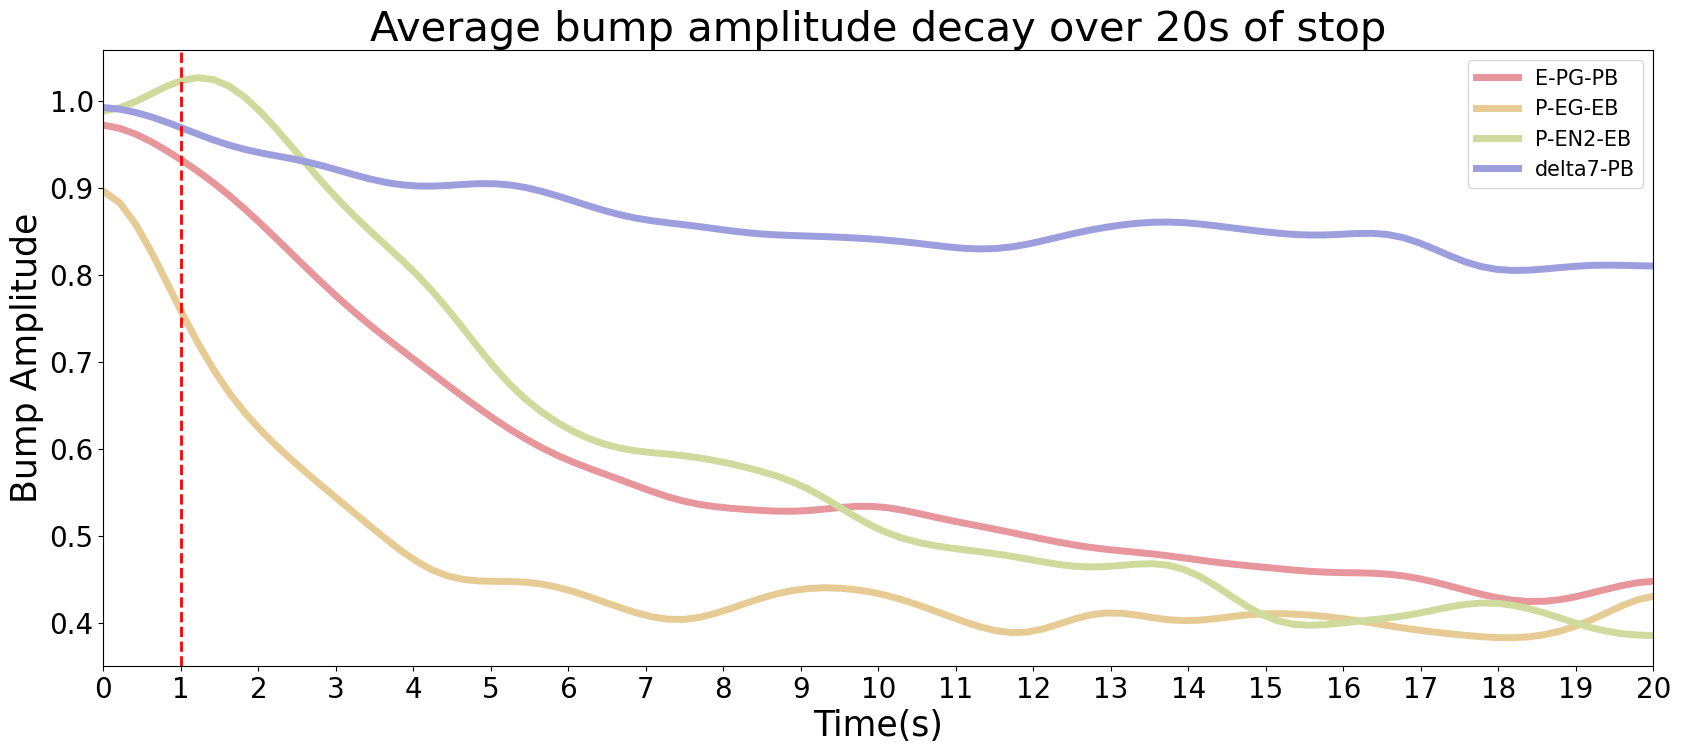

In [57]:
# Load data
pooled_decay_df = pd.read_csv('/home/tianhaoqiu/Desktop/Average_Bump_amplitude_V3_decay_20s_syt7f_only.csv')
new_column_names = [0, 1, 2, 3]  # Update column names as needed
pooled_decay_df.columns = new_column_names

# Generate time array from -1 to 20 seconds in 200ms intervals (105 points)
time_array_decay = np.linspace(-1, 20, len(pooled_decay_df))

# Find the index where time is 0 (200ms intervals means index 5 if starting from -1)
zero_index = np.where(time_array_decay >= 0)[0][0]  # Index where time = 0

# Scale each signal to 1 at 0 seconds
for i in pooled_decay_df.columns:
    pooled_decay_df[i] = pooled_decay_df[i] / pooled_decay_df[i][zero_index]

# Select data from 0 to 20 seconds only
pooled_decay_df = pooled_decay_df.iloc[zero_index:]
time_array_decay = time_array_decay[zero_index:]

# Set up colors and plot
palette = sns.color_palette("tab20b_r", len(pooled_decay_df.columns))
plt.figure(figsize=(20, 8))

# Plot each column with smoothing and normalized scaling
for i in range(len(pooled_decay_df.columns)):
    plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_df[i], sigma=3), linewidth=5, color=palette[i])

# Add custom labels and legend
custom_labels = ['E-PG-PB', 'P-EG-EB', 'P-EN2-EB', 'delta7-PB']
plt.legend(custom_labels, fontsize=15)
plt.xticks(
    ticks=np.arange(0, time_array_decay[-1] + 1, 1),
    labels=np.arange(0, time_array_decay[-1] + 1, 1, dtype=int),
    fontsize=20
)
plt.yticks(fontsize=20)
plt.xlim(0, 20)
plt.axvline(x=1, color='r', linestyle='--', linewidth=2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average bump amplitude decay over 20s of stop", fontsize=30)
plt.show()

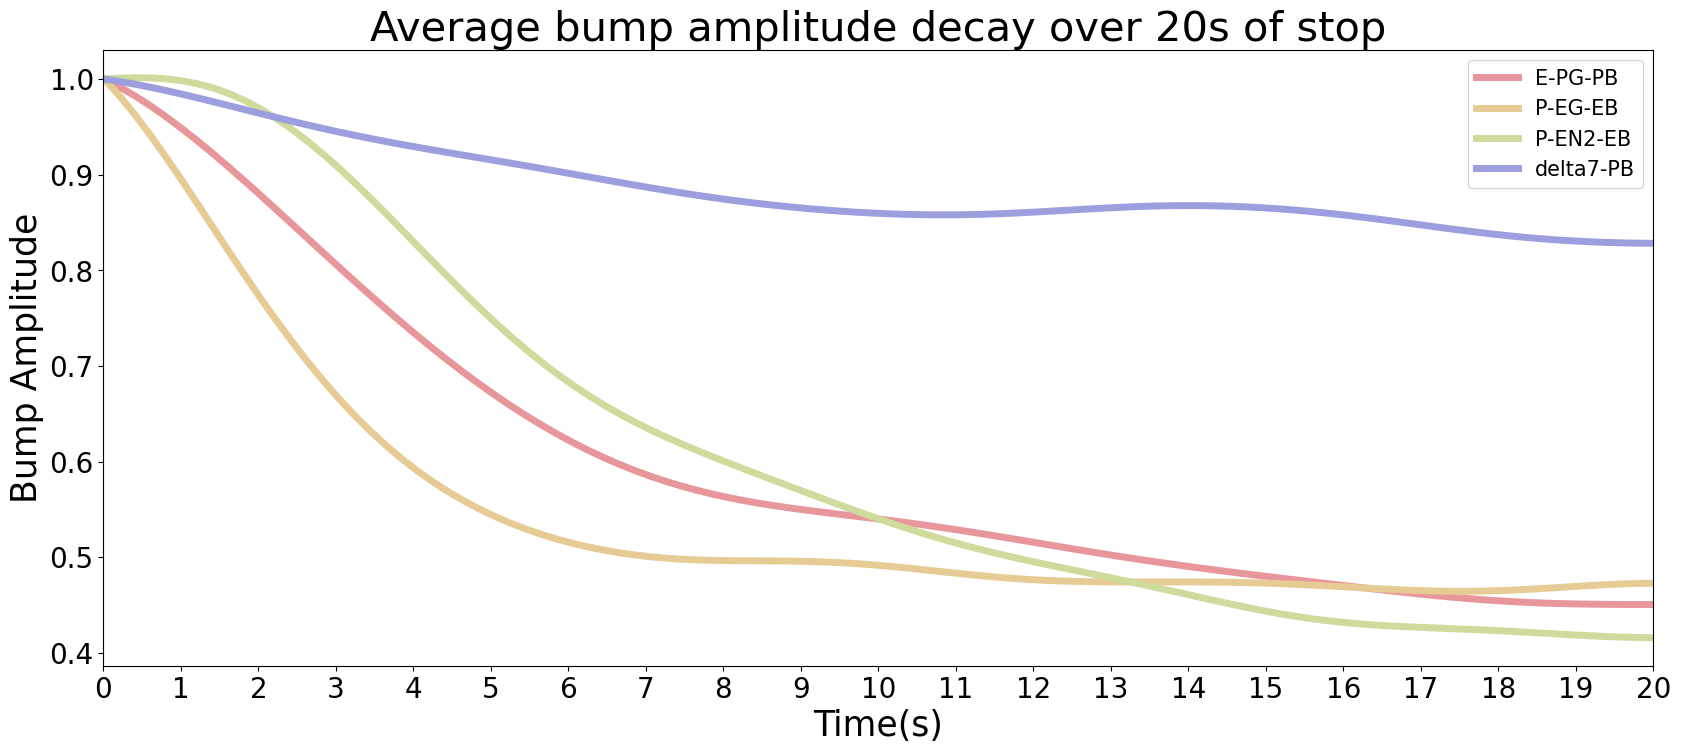

In [79]:
# Load data
pooled_decay_df = pd.read_csv('/home/tianhaoqiu/Desktop/Average_Bump_amplitude_V3_decay_20s_syt7f_only.csv')
new_column_names = [0, 1, 2, 3]  # Update column names as needed
pooled_decay_df.columns = new_column_names

# Generate time array from -1 to 20 seconds in 200ms intervals (105 points)
time_array_decay = np.linspace(-1, 20, len(pooled_decay_df))

# Find the index where time is 0
zero_index = np.where(time_array_decay >= 0)[0][0]  # Index where time = 0

# Apply Gaussian filtering first and store smoothed values
smoothed_df = pooled_decay_df.apply(lambda col: gaussian_filter1d(col, sigma=8))

# Normalize each column by its value at 0 seconds
for i in smoothed_df.columns:
    smoothed_df[i] = smoothed_df[i] / smoothed_df[i][zero_index]

# Select data from 0 to 20 seconds only
smoothed_df = smoothed_df.iloc[zero_index:]
time_array_decay = time_array_decay[zero_index:]

# Set up colors and plot
palette = sns.color_palette("tab20b_r", len(smoothed_df.columns))
plt.figure(figsize=(20, 8))

# Plot each smoothed and normalized column
for i in range(len(smoothed_df.columns)):
    plt.plot(time_array_decay, smoothed_df[i], linewidth=5, color=palette[i])

# Add custom labels and legend
custom_labels = ['E-PG-PB', 'P-EG-EB', 'P-EN2-EB', 'delta7-PB']
plt.legend(custom_labels, fontsize=15)
plt.xticks(
    ticks=np.arange(0, time_array_decay[-1] + 1, 1),
    labels=np.arange(0, time_array_decay[-1] + 1, 1, dtype=int),
    fontsize=20
)
plt.yticks(fontsize=20)
plt.xlim(0, 20)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average bump amplitude decay over 20s of stop", fontsize=30)
plt.savefig('Bump_abplitude_V3_dark_0_20s_normalize_to_1_at_zero_smooth_syt7f.svg', format='svg')
plt.show()



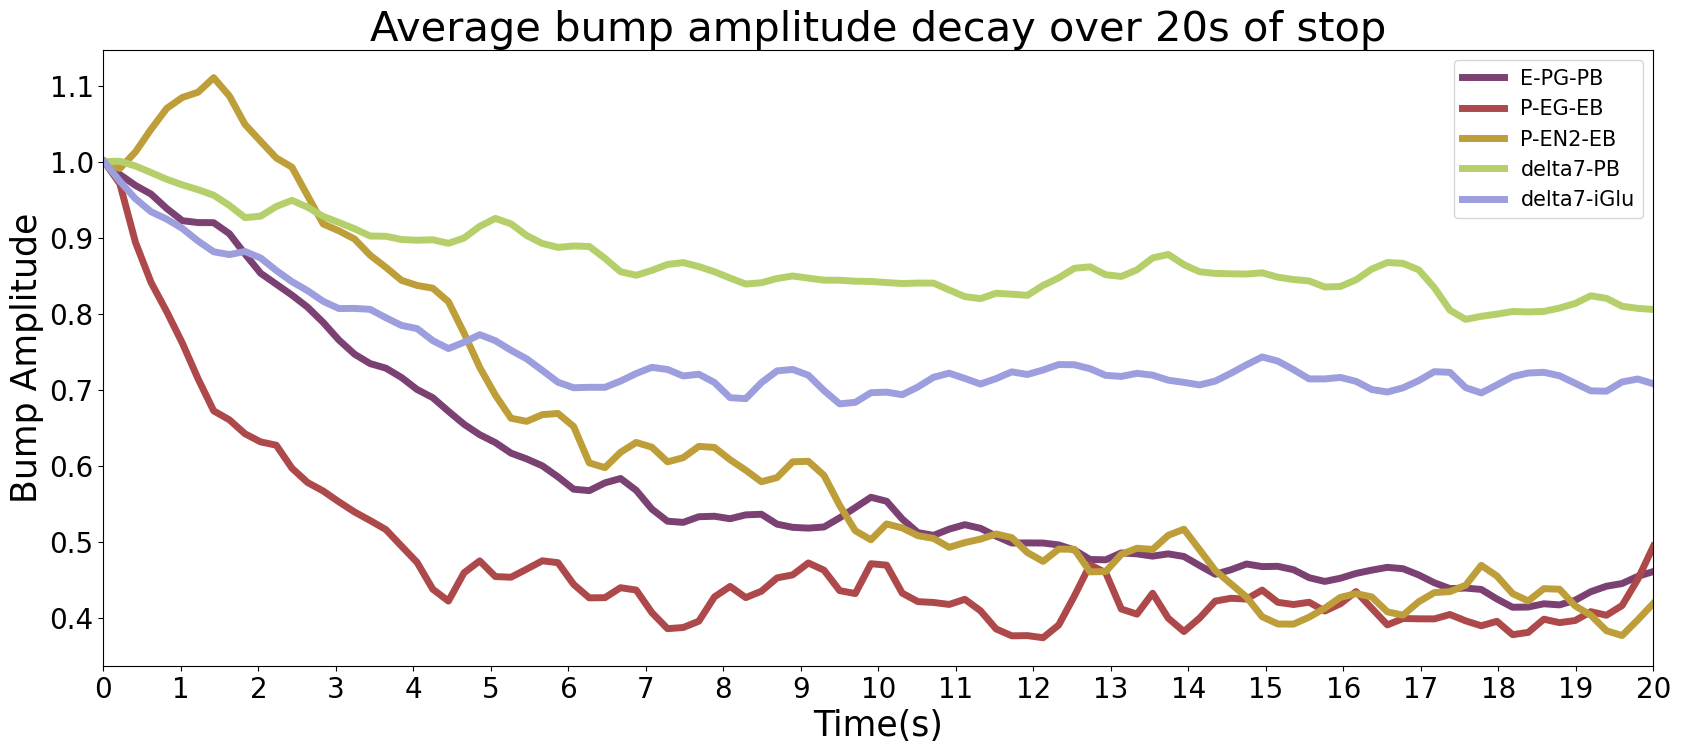

In [92]:
# Load data
pooled_decay_df = pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v3(should not use)/Average_Bump_amplitude_V3_decay_20s_syt7f_and_iGluSnFR.csv')
new_column_names = [0, 1, 2, 3,4]  # Update column names as needed
pooled_decay_df.columns = new_column_names

# Generate time array from -1 to 20 seconds in 200ms intervals (105 points)
time_array_decay = np.linspace(-1, 20, len(pooled_decay_df))

# Find the index where time is 0
zero_index = np.where(time_array_decay >= 0)[0][0]  # Index where time = 0

# Apply Gaussian filtering first and store smoothed values
smoothed_df = pooled_decay_df.apply(lambda col: gaussian_filter1d(col, sigma=0.8))

# Normalize each column by its value at 0 seconds
for i in smoothed_df.columns:
    smoothed_df[i] = smoothed_df[i] / smoothed_df[i][zero_index]

# Select data from 0 to 20 seconds only
smoothed_df = smoothed_df.iloc[zero_index:]
time_array_decay = time_array_decay[zero_index:]

# Set up colors and plot
palette = sns.color_palette("tab20b_r", len(smoothed_df.columns))
plt.figure(figsize=(20, 8))

# Plot each smoothed and normalized column
for i in range(len(smoothed_df.columns)):
    plt.plot(time_array_decay, smoothed_df[i], linewidth=5, color=palette[i])

# Add custom labels and legend
custom_labels = ['E-PG-PB', 'P-EG-EB', 'P-EN2-EB', 'delta7-PB','delta7-iGlu']
plt.legend(custom_labels, fontsize=15)
plt.xticks(
    ticks=np.arange(0, time_array_decay[-1] + 1, 1),
    labels=np.arange(0, time_array_decay[-1] + 1, 1, dtype=int),
    fontsize=20
)
plt.yticks(fontsize=20)
plt.xlim(0, 20)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average bump amplitude decay over 20s of stop", fontsize=30)
plt.savefig('Bump_abplitude_V3_dark_0_20s_normalize_to_1_at_zero_smooth_0.8_syt7f_iglu.svg', format='svg')
plt.show()

In [74]:
data_all['output_df_pooled'].columns

Index(['FlyTrial', 'Genotype', 'TrialType', 'Period_duration',
       'PVA_before_stop', 'PVA_before_stop_average_5_frames_after',
       'PVA_at_restart', 'PVA_100ms_before_restart',
       'PVA_500ms_before_restart', 'PVA_in_middle', 'PVA_2s_before_restart',
       'PVA_3s_after_stop', 'PVA_5s_after_stop', 'PVA_10s_after_stop',
       'PVA_10s_after_stop_average_5_frames_before', 'PVA_20s_after_stop',
       'PVA_20s_after_stop_average_5_frames_before', 'PVA_35s_after_stop',
       'PVA_60s_after_stop', 'PVA_angle_drift_per_second',
       'PVA_angle_drift_per_second_2', 'forward_speed_before_stop',
       'forward_speed_at_restart', 'forward_speed_100ms_before_restart',
       'forward_speed_500ms_before_restart', 'forward_speed_in_middle',
       'forward_speed_2s_before_restart', 'forward_speed_3s_after_stop',
       'forward_speed_5s_after_stop', 'forward_speed_10s_after_stop',
       'forward_speed_20s_after_stop', 'forward_speed_35s_after_stop',
       'bump_amplitude_before_st

In [75]:
data_all['output_df_pooled']['FlyTrialGroup'] = data_all['output_df_pooled']['FlyTrial'].apply(lambda x: x.split('-')[0])

In [76]:
data_all['output_df_pooled']['angle difference start/5s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_5s_after_stop']))
data_all['output_df_pooled']['angle difference start/10s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_10s_after_stop']))
data_all['output_df_pooled']['angle difference start/20s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_20s_after_stop']))
data_all['output_df_pooled']['angle difference start/10s_5_frame_average'] = calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop_average_5_frames_after'],data_all['output_df_pooled']['PVA_10s_after_stop_average_5_frames_before'])
data_all['output_df_pooled']['angle difference start/20s_5_frame_average'] = calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop_average_5_frames_after'],data_all['output_df_pooled']['PVA_20s_after_stop_average_5_frames_before'])
data_all['output_df_pooled']['angle difference start/restart'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled']['PVA_before_stop'],data_all['output_df_pooled']['PVA_at_restart']))

if dual_imaging == 1:
    data_all['output_df_pooled_red']['angle difference start/5s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_5s_after_stop']))
    data_all['output_df_pooled_red']['angle difference start/10s'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_10s_after_stop']))
    data_all['output_df_pooled_red']['angle difference start/restart'] = np.abs(calculate_angle_difference_between_two_time_point(data_all['output_df_pooled_red']['PVA_before_stop'],data_all['output_df_pooled_red']['PVA_at_restart']))

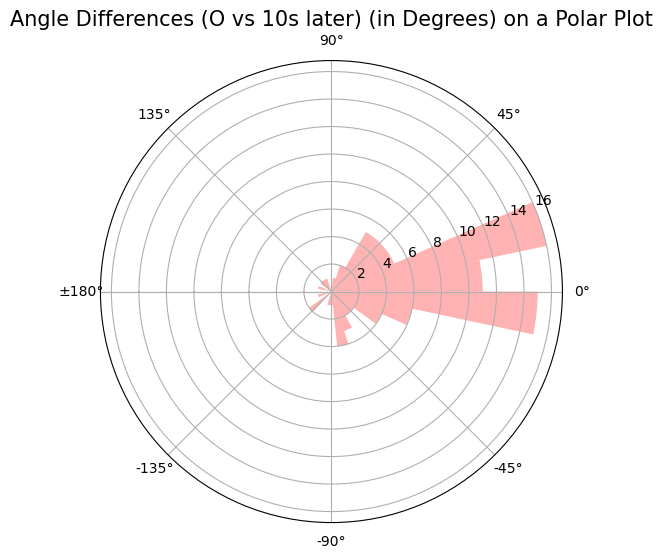

In [77]:
# Remove NaN values
angles_degrees = data_all['output_df_pooled']['angle difference start/10s_5_frame_average'].dropna()

# Convert angles from degrees to radians and map to the range [-π, π]
angles_radians = np.deg2rad(angles_degrees)

# Convert any angles > 180 degrees to the negative range (i.e., map from 0 to -π)
angles_radians = np.where(angles_radians > np.pi, angles_radians - 2 * np.pi, angles_radians)

# Create a polar plot
plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='polar')

# Define the bin edges for the histogram, ensuring the range is [-π, π]
num_bins = 30
bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)

# Plot the histogram
ax.hist(angles_radians, bins=bin_edges, color='red', alpha=0.3)

# Set the angular range to show -π to π
ax.set_thetalim(-np.pi, np.pi)


# Manually set the tick labels for the angular axis (to show -180° to 180°)
ax.set_xticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'', r'-135°', r'-90°', r'-45°', r'0°', r'45°', r'90°', r'135°', r'±180°'])

# Set the title and show the plot
ax.set_title("Angle Differences (O vs 10s later) (in Degrees) on a Polar Plot", fontsize=15)

plt.show()

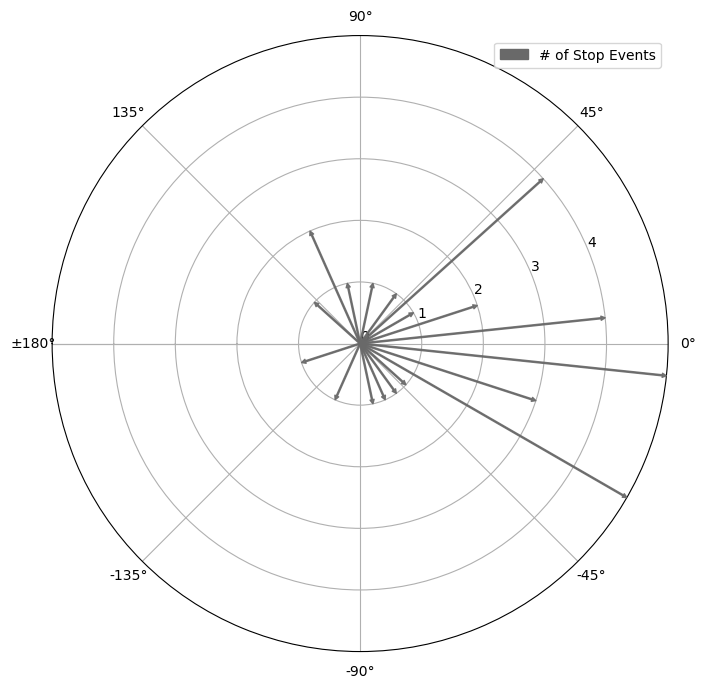

In [78]:
# Remove NaN values
angles_degrees = data_all['output_df_pooled']['angle difference start/20s_5_frame_average'].dropna()

# Convert angles from degrees to radians and map to the range [-π, π]
angles_radians = np.deg2rad(angles_degrees)
angles_radians = np.where(angles_radians > np.pi, angles_radians - 2 * np.pi, angles_radians)

# Create a polar plot
a= plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='polar')

# Define fixed bin edges to ensure consistent bin sizes
num_bins = 30
bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)

# Create the histogram manually to get the bin counts and edges
n, bins = np.histogram(angles_radians, bins=bin_edges)

# Set the maximum count for scaling the arrows
max_count = np.max(n)

# Plot arrows at each bin where the count is greater than zero
for i in range(len(bins) - 1):
    if n[i] > 0:
        # Get the middle of the bin for angle positioning
        angle = (bins[i] + bins[i + 1]) / 2
        count = n[i]  # Use the actual count for the arrow length

        # Draw an arrow for each bin
        ax.annotate('', xy=(angle, count), xytext=(angle, 0),
                    arrowprops=dict(facecolor='dimgray', edgecolor='dimgray', alpha=0.9, shrink=0, 
                                    width=0.8, headwidth=3, headlength=3))

# Set the angular range to show -π to π
ax.set_thetalim(-np.pi, np.pi)

# Manually set the tick labels for the angular axis (to show -180° to 180°)
ax.set_xticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax.set_xticklabels([r'', r'-135°', r'-90°', r'-45°', r'0°', r'45°', r'90°', r'135°', r'±180°'])

# Set the radial ticks to display the bin counts (instead of 0.2, 0.4, etc.)
ax.set_rticks([i for i in range(0, 5,1)])
ax.set_rlim(0, 5)



# Create a proxy artist for the legend (r ticks are indicating stop trial counts)
import matplotlib.patches as mpatches
proxy = mpatches.Patch(color='dimgray', label='# of Stop Events')
# Add the legend
ax.legend(handles=[proxy], loc='upper right')


# Set the title and show the plot
#ax.set_title("Angle Differences (0° to 180°) on a Polar Plot", fontsize=15)

plt.show()
a.savefig('EPG_syt7f_PB_dark_Polar_plot_0_20s', format ='svg')

In [47]:
len(data_all['output_df_pooled']['angle difference start/10s_5_frame_average'].dropna())


58

(array([81., 49., 32., 16.,  9.,  7., 10.,  2.,  0.,  2.]),
 array([  2.1698888 ,  16.62692901,  31.08396923,  45.54100944,
         59.99804965,  74.45508987,  88.91213008, 103.36917029,
        117.82621051, 132.28325072, 146.74029094]),
 <BarContainer object of 10 artists>)

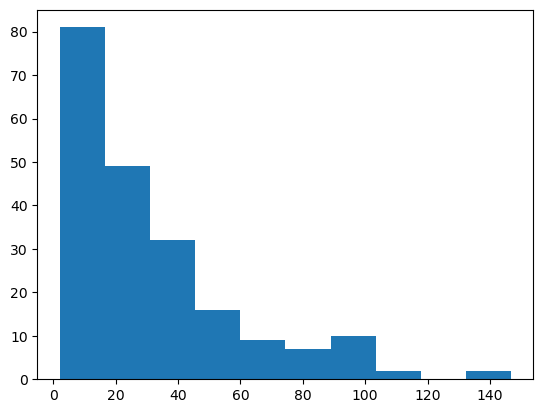

In [19]:
plt.hist(data_all['output_df_pooled']['PVA_angle_drift_per_second'])

(array([136.,  31.,  16.,  11.,   0.,   2.,   6.,   3.,   1.,   2.]),
 array([ 1.17521646,  3.97519285,  6.77516924,  9.57514563, 12.37512202,
        15.17509841, 17.9750748 , 20.77505118, 23.57502757, 26.37500396,
        29.17498035]),
 <BarContainer object of 10 artists>)

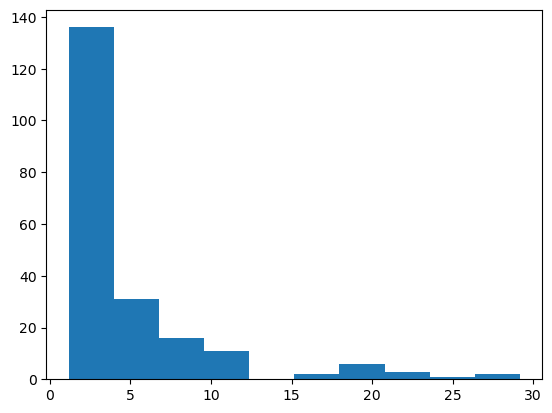

In [20]:
plt.hist(data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])

In [21]:
np.mean(data_all['output_df_pooled']['PVA_angle_drift_per_second'])

31.124421916521246

In [22]:
np.mean(data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])

5.081203548918272

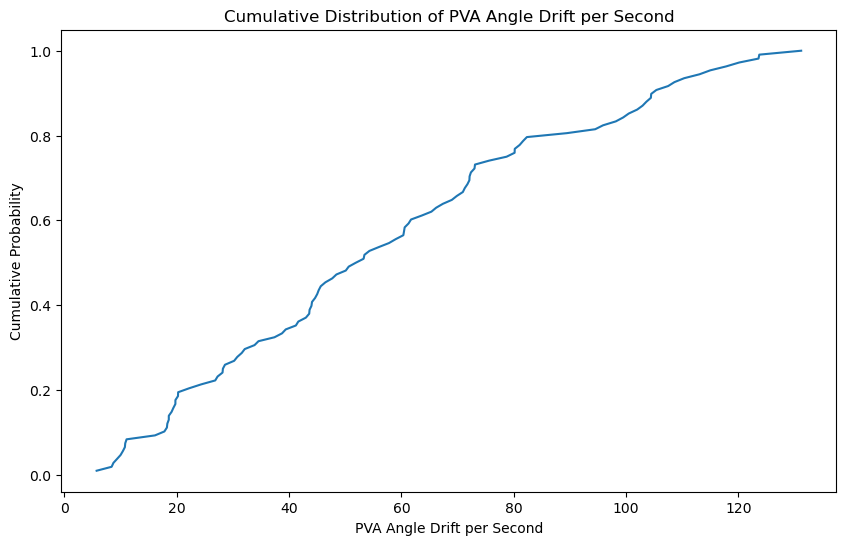

In [18]:
# Extract the series
accumulate_data = data_all['output_df_pooled']['PVA_angle_drift_per_second']

# Sort the data
accumulate_data_sort = np.sort(accumulate_data)

# Compute the cumulative distribution
cdf = np.arange(1, len(accumulate_data_sort) + 1) / len(accumulate_data_sort)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(accumulate_data_sort, cdf)
plt.title('Cumulative Distribution of PVA Angle Drift per Second')
plt.xlabel('PVA Angle Drift per Second')
plt.ylabel('Cumulative Probability')
plt.show()

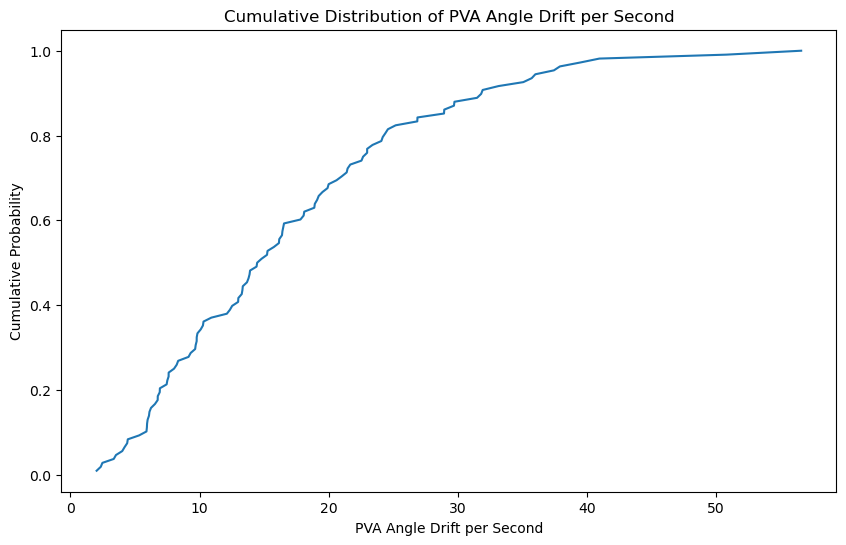

In [19]:
# Extract the series
accumulate_data = data_all['output_df_pooled']['PVA_angle_drift_per_second_2']

# Sort the data
accumulate_data_sort = np.sort(accumulate_data)

# Compute the cumulative distribution
cdf = np.arange(1, len(accumulate_data_sort) + 1) / len(accumulate_data_sort)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(accumulate_data_sort, cdf)
plt.title('Cumulative Distribution of PVA Angle Drift per Second')
plt.xlabel('PVA Angle Drift per Second')
plt.ylabel('Cumulative Probability')
plt.show()

In [25]:
data_all['output_df_pooled']['PVA_angle_drift_per_second'].shape

(208,)

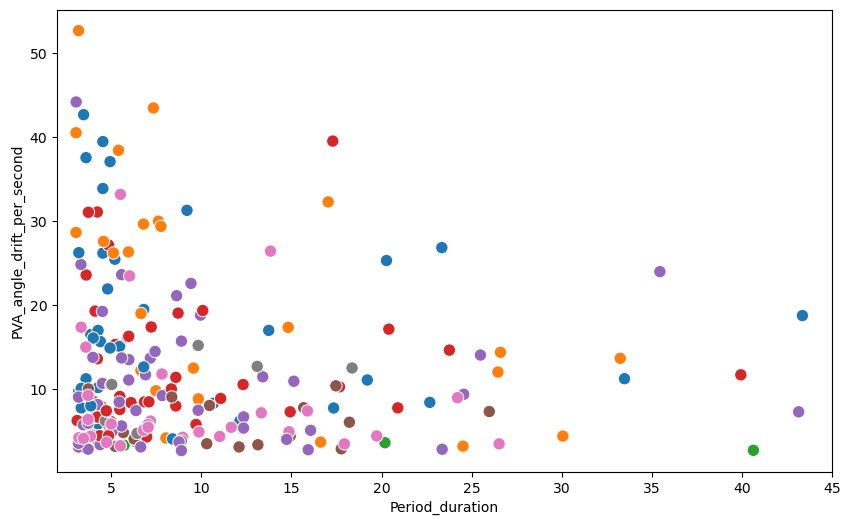

In [45]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='Period_duration', y='PVA_angle_drift_per_second_2',  s =80,hue = 'FlyTrialGroup',legend=False)
plt.ylabel('PVA_angle_drift_per_second')
plt.xlim(2,45)
plt.show()

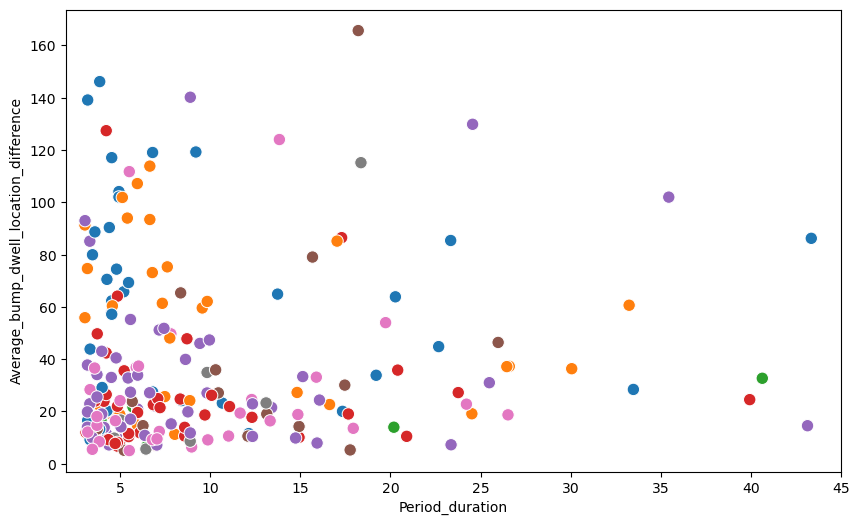

In [46]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='Period_duration', y='PVA_angle_drift_per_second',  s =80,hue = 'FlyTrialGroup',legend=False)
plt.ylabel('Average_bump_dwell_location_difference')
plt.xlim(2,45)
plt.show()

Pearson correlation coefficient: 0.65, p-value: 2.27e-28


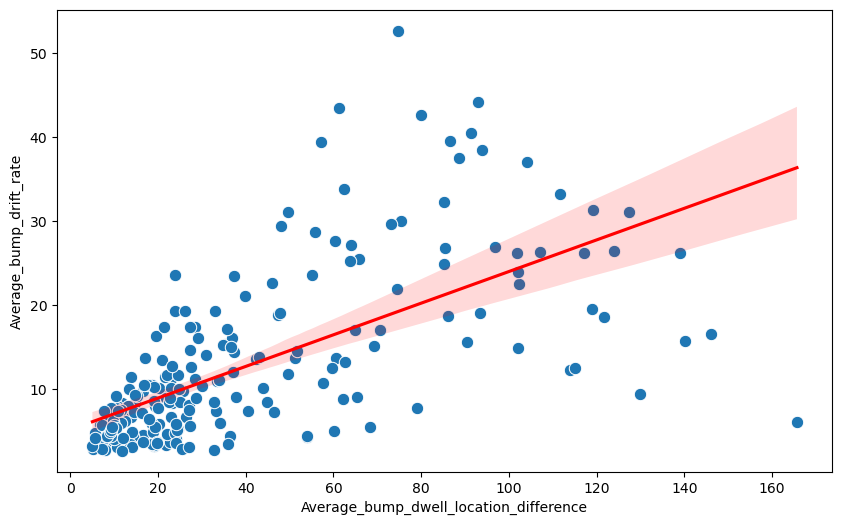

In [47]:
# Create kdeplot (density plot)
plt.figure(figsize=(10, 6))
corr_coef, p_value = pearsonr(data_all['output_df_pooled']['PVA_angle_drift_per_second'], data_all['output_df_pooled']['PVA_angle_drift_per_second_2'])
print(f"Pearson correlation coefficient: {corr_coef:.2f}, p-value: {p_value:.2e}")
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data=data_all['output_df_pooled'], x='PVA_angle_drift_per_second', y='PVA_angle_drift_per_second_2',  s =80)
# Add regression line
sns.regplot(data=data_all['output_df_pooled'], x='PVA_angle_drift_per_second', y='PVA_angle_drift_per_second_2', scatter=False, color='r')
plt.xlabel('Average_bump_dwell_location_difference')
plt.ylabel('Average_bump_drift_rate')
#plt.xlim(2,25)
plt.show()

In [37]:
data_all['output_df_pooled'].to_csv('/home/tianhaoqiu/Pictures/Screenshots/output_signal_at_stop_point_EPG_7b_empty_shi_31_dark.csv',encoding = 'utf-8', index=False)

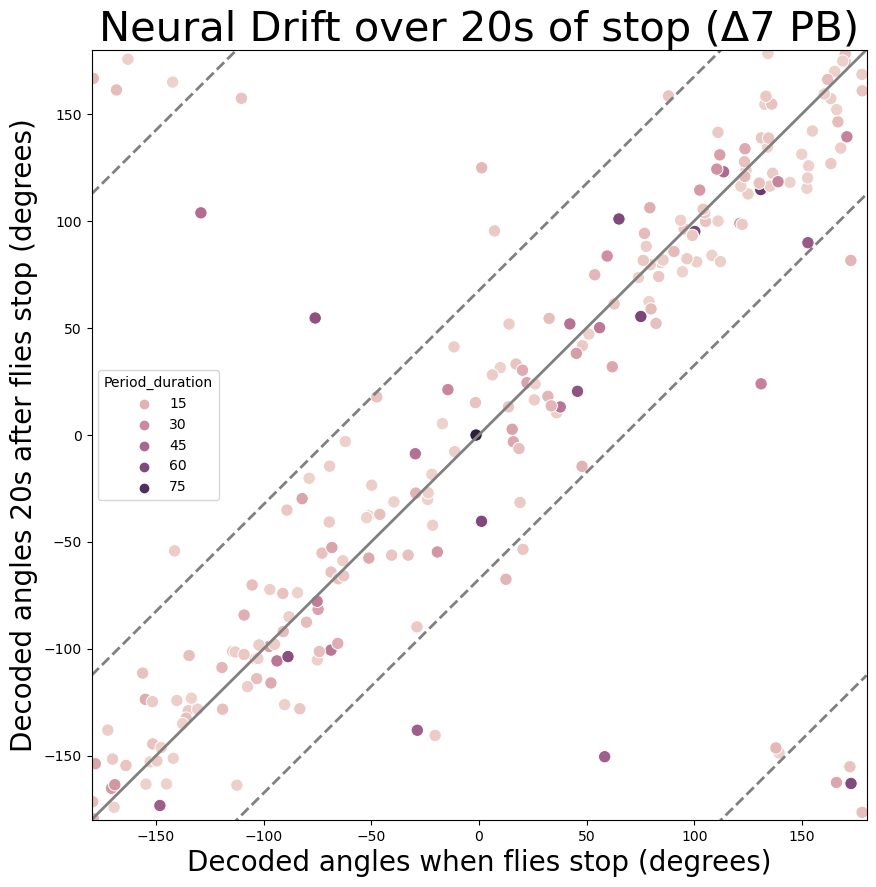

In [29]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = data_all['output_df_pooled'], x='PVA_before_stop', y='PVA_at_restart', s =80, hue = 'Period_duration')
#snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
#snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_20s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
#snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural Drift over 20s of stop (Δ7 PB)', fontsize =30)
plt.ylabel('Decoded angles 20s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
#plt.grid()
plt.show()
#a.savefig('Δ7_syt7f_PB_Bump_Angle_20s_after_dark_no_hue', format ='svg')

In [19]:
if dual_imaging == 1:
    a = plt.figure(figsize= (10,10))
    cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
    snsplot = sns.scatterplot(data = data_all['output_df_pooled_red'], x='PVA_before_stop', y='PVA_20s_after_stop', s =80)
    #snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
    #snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_20s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
    #snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
    X_plot = np.linspace(-180, 180, 100)
    Y_plot = X_plot
    plt.plot(X_plot,Y_plot, color='grey', linewidth =2)
    plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =2)
    plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =2)
    plt.ylim(-180, 180)
    plt.xlim(-180, 180)
    plt.title('Neural Drift over 20s of stop (Δ7 PB)', fontsize =30)
    plt.ylabel('Decoded angles 20s after flies stop (degrees)',fontsize= 20)
    plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
    #plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
    #plt.grid()
    plt.show()

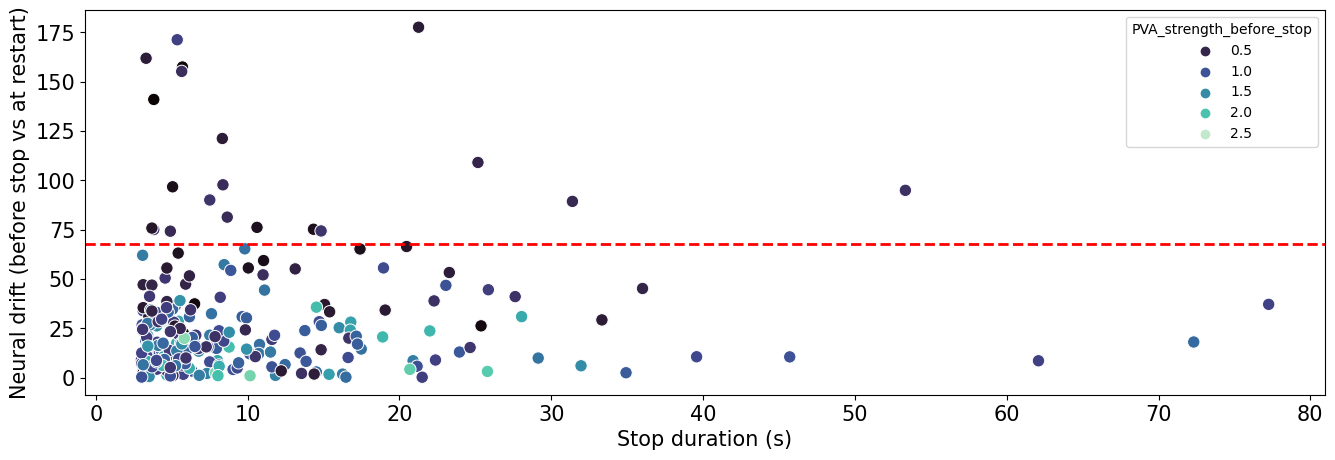

In [20]:
#filtered_data =data_all['output_df_pooled']['Period_duration'] >= 10]
filtered_data = data_all['output_df_pooled']
a = plt.figure(figsize= (16,5))
snsplot = sns.scatterplot(data = filtered_data , x='Period_duration', y='angle difference start/restart', s =80, hue = 'PVA_strength_before_stop', palette='mako',legend=True)
plt.ylabel('Neural drift (before stop vs at restart)',fontsize= 15)
plt.xlabel('Stop duration (s)',fontsize= 15)
plt.axhline(y= 67.5, color = 'r',linestyle ='--',linewidth=2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()
#a.savefig('Δ7_syt7f_EB_Bump_Angle_difference_10s_at_least_dark', format ='svg')

In [38]:
data_all['output_df_pooled']

FlyTrial   Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly263-004  R27F02>7b      dark          8.74152       123.072615  \
1    TQfly263-004  R27F02>7b      dark          9.35712       -24.733078   
2    TQfly263-004  R27F02>7b      dark          4.80168        31.490006   
3    TQfly263-004  R27F02>7b      dark          5.41728        30.916865   
4    TQfly263-004  R27F02>7b      dark          4.06296       137.456378   
..            ...        ...       ...              ...              ...   
203  TQfly262-008  R27F02>7b      dark          5.89352        94.627860   
204  TQfly262-008  R27F02>7b      dark          5.25292       146.911629   
205  TQfly262-008  R27F02>7b      dark          7.94344      -140.564506   
206  TQfly262-008  R27F02>7b      dark          4.61232      -139.980754   
207  TQfly262-008  R27F02>7b      dark          7.30284        25.151865   

     PVA_before_stop_average_5_frames_after  PVA_at_restart   
0                                112.973331       57.328003  \
1                                -22.073810       11.605701   
2                                 42.422437       53.262846   
3                                 36.450653       45.148947   
4                                137.175883       88.612125   
..                                      ...             ...   
203                              106.660811     -121.444182   
204                              152.270043      157.125268   
205                             -179.819347     -128.206236   
206                              157.320724       79.482888   
207                               24.326487       21.860977   

     PVA_100ms_before_restart  PVA_500ms_before_restart  PVA_in_middle  ...   
0                   58.010057                 65.303257      72.180807  ...  \
1                   10.393462                 12.570861       1.839769  ...   
2                   55.772338                 50.975366      55.216062  ...   
3                   44.708857                 44.846721      46.373506  ...   
4                   89.077677                101.431064     113.032417  ...   
..                        ...                       ...            ...  ...   
203               -110.999340               -128.799473     104.727730  ...   
204                173.214280               -145.175617    -135.386081  ...   
205               -119.334184               -128.468352      47.170774  ...   
206                 82.129075                117.311543    -136.607196  ...   
207                  5.550440                 -9.970015     -30.716872  ...   

     PVA_strength_10s_after_stop  PVA_strength_20s_after_stop   
0                            NaN                          NaN  \
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   
..                           ...                          ...   
203                          NaN                          NaN   
204                          NaN                          NaN   
205                          NaN                          NaN   
206                          NaN                          NaN   
207                          NaN                          NaN   

     PVA_strength_35s_after_stop  FlyTrialGroup  angle difference start/5s   
0                            NaN       TQfly263                  73.217385  \
1                            NaN       TQfly263                  24.280335   
2                            NaN       TQfly263                        NaN   
3                            NaN       TQfly263                  12.425134   
4                            NaN       TQfly263                        NaN   
..                           ...            ...                        ...   
203                          NaN       TQfly262                

In [39]:
if dual_imaging == 1:
    filtered_data_red = data_all['output_df_pooled_red'][data_all['output_df_pooled_red']['Period_duration'] >= 10]
    a = plt.figure(figsize= (16,5))
    snsplot = sns.scatterplot(data = filtered_data_red , x='Period_duration', y='angle difference start/restart', s =80)
    plt.ylabel('Neural drift (before stop vs at restart)',fontsize= 15)
    plt.xlabel('Stop duration (s)',fontsize= 15)
    plt.axhline(y= 67.5, color = 'r',linestyle ='--',linewidth=2)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.show()

(array([56., 54., 28., 18., 19.,  6.,  8.,  6.,  3.,  3.,  1.,  6.]),
 array([1.31848072e-01, 1.47773709e+01, 2.94228937e+01, 4.40684166e+01,
        5.87139394e+01, 7.33594622e+01, 8.80049851e+01, 1.02650508e+02,
        1.17296031e+02, 1.31941554e+02, 1.46587076e+02, 1.61232599e+02,
        1.75878122e+02]),
 <BarContainer object of 12 artists>)

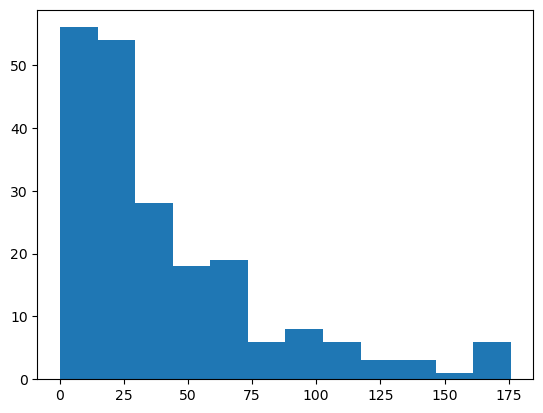

In [40]:
plt.hist(filtered_data['angle difference start/restart'] ,bins='auto')
#plt.hist(filtered_data_red['angle difference start/restart'] ,bins='auto')

In [41]:
# Count the number of values larger than 22.5 in the column 'angle difference start/restart'
num_values_larger_than_22_5 = (filtered_data['angle difference start/20s'] <= 22.5).sum()

print("Number of values larger than 22.5:", num_values_larger_than_22_5)

Number of values larger than 22.5: 0


In [42]:
# Count the number of non-NaN values in the column 'angle difference start/20s'
num_non_nan_values = filtered_data['angle difference start/20s'].notna().sum()

print("Number of non-NaN values:", num_non_nan_values)

Number of non-NaN values: 1


In [43]:
num_non_nan_values = filtered_data['angle difference start/restart'].notna().sum()

/home/tianhaoqiu/anaconda3/envs/SessionTools/lib/python3.10/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


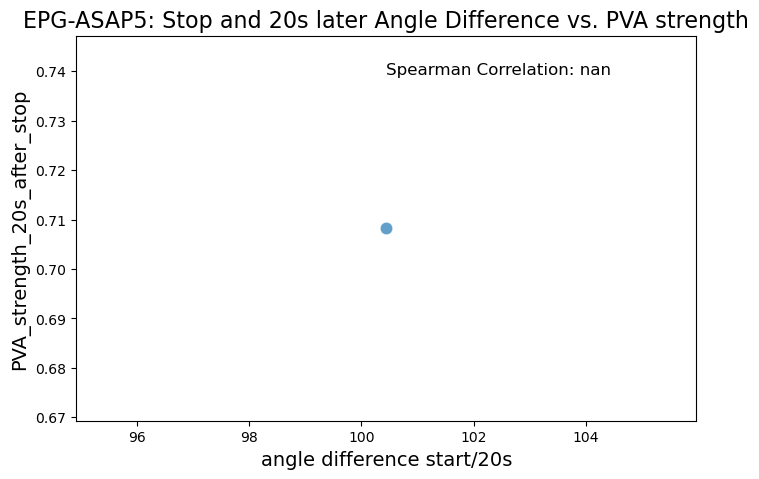

In [44]:
from matplotlib.cm import ScalarMappable


output_df_pooled_cleaned = data_all['output_df_pooled'].dropna(subset=['angle difference start/20s', 'PVA_strength_20s_after_stop'])
# Create a scatter plot with the 'viridis' colormap
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('PVA strength 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. PVA strength', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['PVA_strength_20s_after_stop']
regression_model.fit(X, y)

sns.regplot(
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    data=output_df_pooled_cleaned,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')


#Calculate Spearman correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['PVA_strength_20s_after_stop'])
# Display Spearman correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')


# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

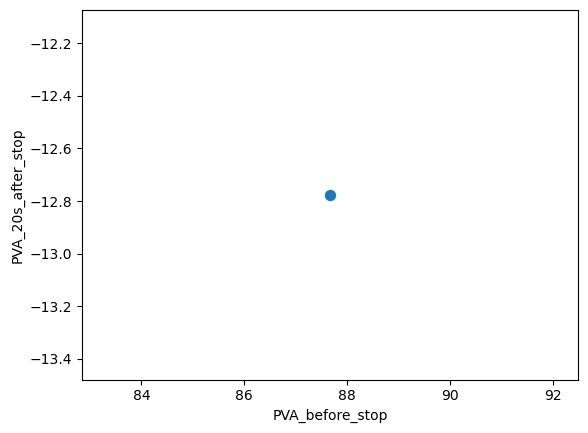

In [45]:
snsplot = sns.scatterplot(data = data_all['output_df_pooled'], x='PVA_before_stop', y='PVA_20s_after_stop', s =80)

NameError: name 'output_df_pooled' is not defined

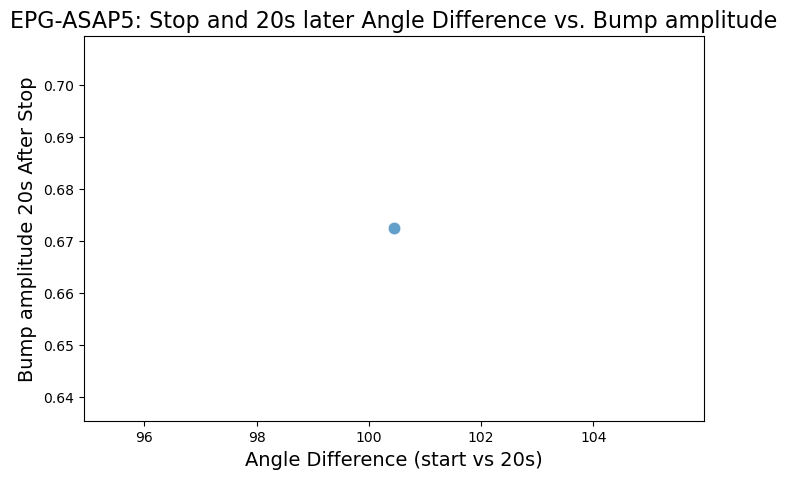

In [46]:
# Create a scatter plot with the 'viridis' colormap
output_df_pooled_cleaned = data_all['output_df_pooled'].dropna(subset=['angle difference start/20s', 'bump_amplitude_20s_after_stop'])
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('Bump amplitude 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. Bump amplitude', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['bump_amplitude_20s_after_stop']
regression_model.fit(X, y)


sns.regplot(
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    data=output_df_pooled,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Calculate Pearson correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['bump_amplitude_20s_after_stop'])

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')

# Display Pearson correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')

# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

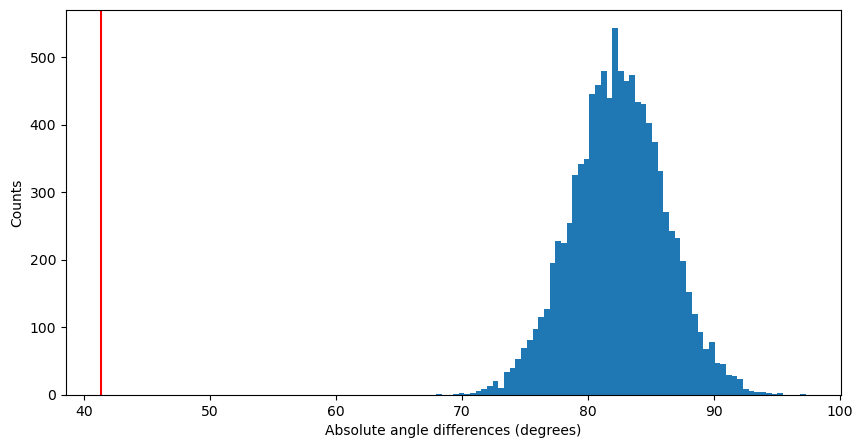

In [47]:
dark_stop_period_start_20s = np.zeros(len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0)))
dark_stop_period_end_20s = np.zeros(len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0))) 
long_trial_index = np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_at_restart'])==0)
for i in range(len(dark_stop_period_start_20s )):
    dark_stop_period_start_20s[i] = data_all['output_df_pooled']['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_20s[i] =  data_all['output_df_pooled']['PVA_at_restart'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_20s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_20s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_20s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_20s ,dark_stop_period_end_20s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     

a = plt.figure(figsize=(10, 5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()
#a.savefig('PEN-2_syt7f_EB_Shuffle_analysos_Bump_Angle_10s_after_dark', format ='svg')

In [43]:
#df = pd.DataFrame(bootstrap_mean_angle_differences_10000, columns=['Column_Name'])
#df.to_csv('/home/tianhaoqiu/a.csv',encoding = 'utf-8', index=False) 

In [45]:
len(np.argwhere(np.isnan(data_all['output_df_pooled']['PVA_60s_after_stop'])==0))

1

In [46]:
actual_mean_absolute_angle_diff_dark     

58.71134551869345

In [47]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.038)

78.72402994869272

In [11]:
pooled_bump_amplitude_V4_allGenotypes_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4.csv')

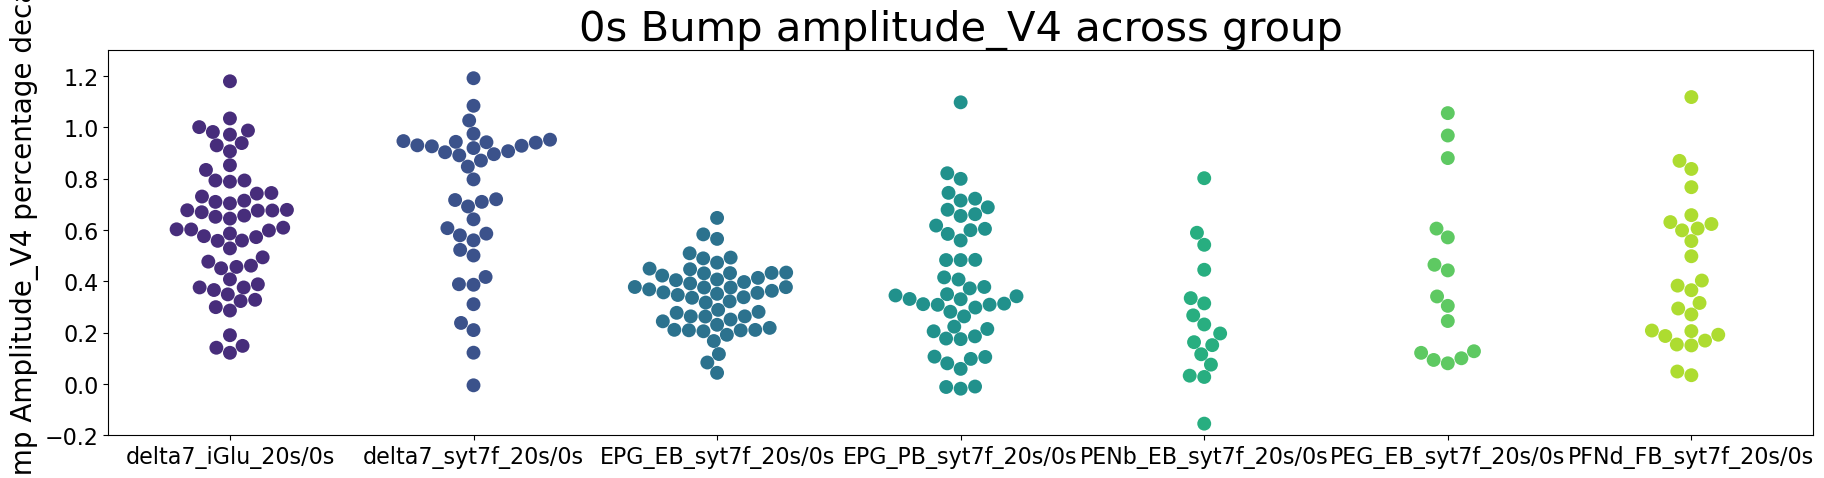

In [15]:

pooled_bump_amplitude_V4_allGenotypes_df

columns_to_plot_v4_percentage_20s = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']


# Create a swarm plot
plt.figure(figsize=(22, 5))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_df[columns_to_plot_v4_percentage_20s ], palette='viridis', size=10)

plt.title('0s Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4 percentage decat',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.2,1.3)
plt.show()

In [16]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_df,columns_to_plot_v4_percentage_20s)

One-way ANOVA Result:
F-statistic: 13.962474353592452
p-value: 1.1188452538118769e-13
Adjusted df between: 6
Adjusted df within: 248
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0547 0.9298 -0.0942 0.2036  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0869 0.9005 -0.1317 0.3054  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0815 0.9162 -0.2947 0.1317  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.1274 0.3303 -0.0493 0.3041  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s   0.2723    0.0  0.1297 0.4149   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.3708    0.0  0.2131 0.5285   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0322 0.9995 -0.1889 0.2532  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.1362 0.4973  -0.352 0

In [19]:
pooled_bump_amplitude_V4_allGenotypes_byfly_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4_averagebyfly_dark.csv')

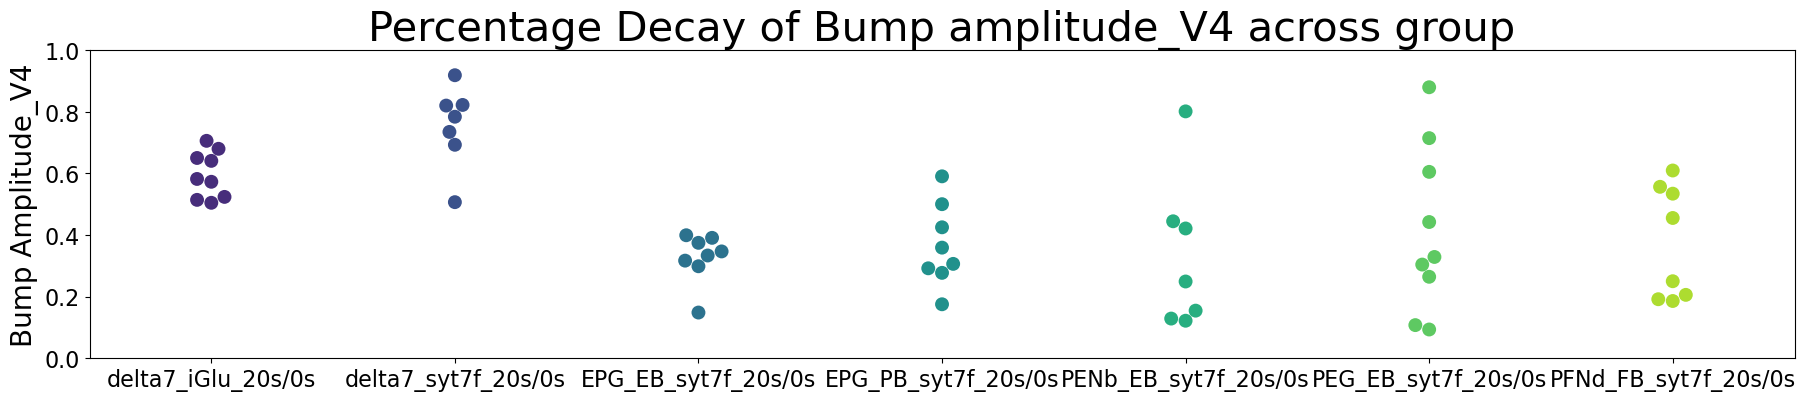

In [22]:
columns_to_plot_v4_percentage_20s_by_fly = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']

# Create a swarm plot
plt.figure(figsize=(22, 4))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_byfly_df[columns_to_plot_v4_percentage_20s_by_fly ], palette='viridis', size=10)

plt.title('Percentage Decay of Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1)
plt.show()

In [23]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_byfly_df,columns_to_plot_v4_percentage_20s_by_fly)

One-way ANOVA Result:
F-statistic: 6.4179827051628795
p-value: 4.882139037796809e-05
Adjusted df between: 6
Adjusted df within: 49
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0396 0.9993 -0.2293 0.3084  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0894 0.9387 -0.1718 0.3507  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s   0.0055    1.0 -0.2728 0.2838  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.0475  0.998 -0.2214 0.3163  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s    0.271 0.0374  0.0098 0.5323   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.4282 0.0004  0.1499 0.7065   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0498 0.9969 -0.2114 0.3111  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0341 0.9998 -0.3123 0.2

In [47]:
pooled_PVA_strength_delta7_shi_df= pd.read_csv('/home/tianhaoqiu/Desktop/mean_PVA_strength_per_trial.csv')

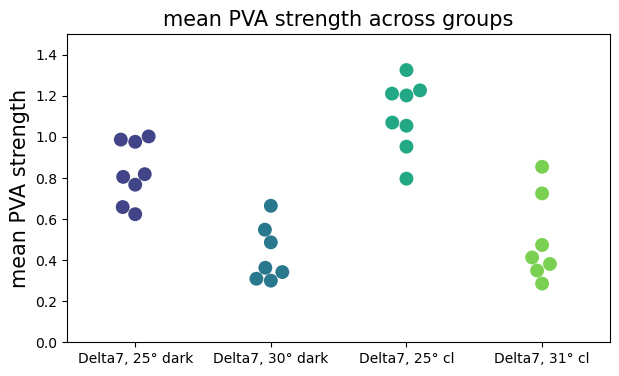

In [48]:
columns_to_plot_PVA_strength = ['Delta7, 25° dark', 'Delta7, 30° dark','Delta7, 25° cl','Delta7, 31° cl']


# Create a swarm plot
plt.figure(figsize=(7, 4))
sns.swarmplot(data=pooled_PVA_strength_delta7_shi_df[columns_to_plot_PVA_strength], palette='viridis', size=10)

plt.title('mean PVA strength across groups', fontsize = 15)
plt.ylabel('mean PVA strength',fontsize =15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,1.5)
plt.show()

In [49]:
run_ANOVA_for_comparing_across_genotypes(pooled_PVA_strength_delta7_shi_df,columns_to_plot_PVA_strength)

One-way ANOVA Result:
F-statistic: 25.82005175722778
p-value: 5.8414032476720313e-08
Adjusted df between: 3
Adjusted df within: 26
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
  Delta7, 25° cl Delta7, 25° dark  -0.2749 0.0156 -0.5067 -0.0432   True
  Delta7, 25° cl Delta7, 30° dark  -0.6744    0.0 -0.9142 -0.4345   True
  Delta7, 25° cl   Delta7, 31° cl  -0.6074    0.0 -0.8472 -0.3675   True
Delta7, 25° dark Delta7, 30° dark  -0.3994 0.0006 -0.6393 -0.1596   True
Delta7, 25° dark   Delta7, 31° cl  -0.3324 0.0041 -0.5723 -0.0926   True
Delta7, 30° dark   Delta7, 31° cl    0.067 0.8792 -0.1807  0.3147  False
------------------------------------------------------------------------


In [50]:
pooled_PVA_strength_glucl_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/60d05-glucl/60D05_glucl_mean_PVA_strength_per_fly.csv')

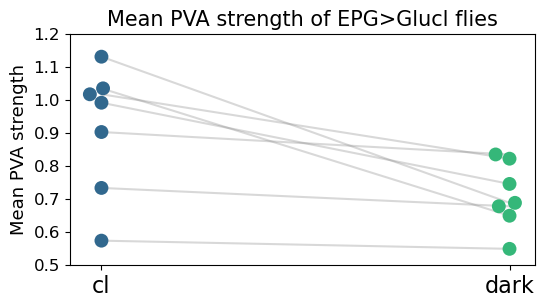

T-statistic: -3.237197374647247
P-value: 0.017749246362167615
Reject the null hypothesis; there is a significant difference between the groups.


In [59]:
from scipy.stats import ttest_rel

# Your list of columns
columns_to_plot_PVA_strength_glucl = ['cl', 'dark']

# Create a swarm plot
plt.figure(figsize=(6, 3))
ax = sns.swarmplot(data=pooled_PVA_strength_glucl_df[columns_to_plot_PVA_strength_glucl], palette='viridis', size=10)

# Connect corresponding dots with lines
for i in range(len(pooled_PVA_strength_glucl_df)):
    plt.plot([0, 1], pooled_PVA_strength_glucl_df.loc[i, columns_to_plot_PVA_strength_glucl].values, color='gray', alpha=0.3)

plt.title('Mean PVA strength of EPG>Glucl flies', fontsize=15)
plt.ylabel('Mean PVA strength', fontsize=13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0.5, 1.2)
plt.show()

# Perform paired sample t-test
t_statistic, p_value = ttest_rel(pooled_PVA_strength_glucl_df['dark'], pooled_PVA_strength_glucl_df['cl'])

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the groups.")

In [ ]:

# Beautify the histogram
plt.figure(figsize=(10, 6))  # Set the figure size

combined_data = a  + b
bin_edges = 'auto'

# Histogram plot with customization
plt.hist(a, bins=bin_edges , color='tomato', edgecolor='black', alpha=0.6)  # Alpha controls transparency
plt.hist(b, bins=bin_edges , color='royalblue', edgecolor='black', alpha=0.6)  
plt.title('Distribution of Strong PVA Chunk (at least 2s)', fontsize = 20)  # Add title
plt.xlabel('Duration(s)', fontsize = 15)  # Label x-axis
plt.ylabel('Counts',fontsize = 15)  # Label y-axis
plt.xlim(2,25)
plt.ylim(0,150)

plt.legend([ 'empty>shi, 31°','E-PG>shi, 31°'],fontsize=12)
# Shw the plot
plt.show()